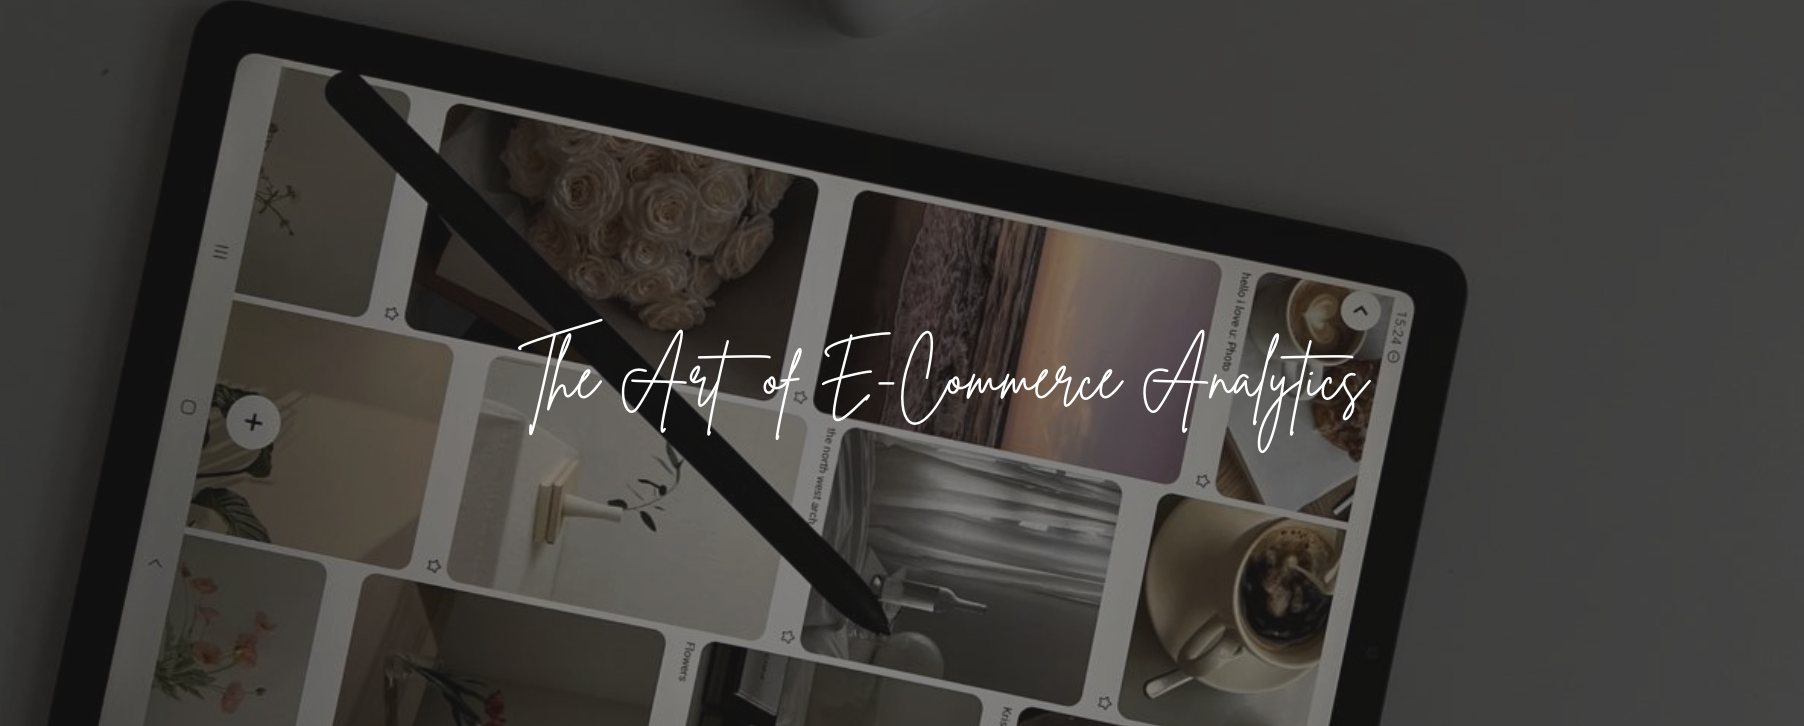

In [1]:
from IPython.display import Image
Image(filename='/kaggle/input/e-commerce-design/Screenshot 2025-09-13 at 23.08.34.png')


# Predicting Session Value in E-Commerce 🛒 

## Problem Definition

In an e-commerce platform, every user session can include multiple actions: viewing products, adding items to the cart, removing items, and eventually making purchases.
One of the key challenges is to **estimate the monetary value of each session (`session_value`)**, since this helps in:

* Understanding which sessions are more profitable
* Prioritizing high-value customers
* Detecting anomalies (e.g., abnormally high or zero-value sessions)
* Improving business strategies like remarketing and personalized offers

However, predicting session value is complex because:

* Many sessions include **only views** without purchases
* Event sequences can be inconsistent (e.g., purchase without cart)
* User behaviors vary widely, from one-time visitors to loyal repeat buyers

##  Project Objective

The main purpose of this project is to **detect and predict `session_value` for each session** using behavioral and event-based features.
Our approach includes:

1. Performing **EDA** to understand user, session, and product-level activities
2. Identifying **anomalies** (unusual sessions, order inconsistencies, suspicious behaviors)
3. Engineering meaningful features from session sequences
4. Training machine learning models Catboost and (AutoGluon) to predict `session_value`


This notebook combines **data exploration, anomaly detection, Catboost and AutoML modeling** to generate actionable insights on **session-level revenue prediction**.


# 1. Essential Libraries

This notebook makes use of essential libraries for analysing e-commerce data. Below is a short overview of each library, along with installation instructions for any Python environment.

## 1.1 AutoGluon

[AutoGluon](https://auto.gluon.ai) is an open-source AutoML (Automated Machine Learning) toolkit developed by Amazon. It simplifies the process of training and tuning machine learning models by automatically handling:



In [1]:
%%capture 
!pip install autogluon

## 1.2 Squarify

[Squarify](https://github.com/laserson/squarify) is a small Python library used for creating **treemaps** that is a type of visualization that displays hierarchical data as a set of nested rectangles.  Each rectangle’s size is proportional to a given value, making it useful for showing proportions and part-to-whole relationships.

In [2]:
%%capture
!pip install squarify

## 1.3 Nbformat

`nbformat` is the Python library that defines the structure of Jupyter Notebook (`.ipynb`) files and allows reading, writing, and upgrading them between different versions.


In [3]:
%%capture
!pip install --upgrade nbformat

## 1.4 Ipywidgets

`ipywidgets` is a Python library that provides interactive HTML widgets for Jupyter notebooks, enabling sliders, dropdowns, buttons, and other UI elements to make notebooks interactive.

In [4]:
%%capture
!pip install ipywidgets

With an overview of the key libraries covered, we can now proceed to import the specific libraries required for this notebook.

In [48]:

# Core Libraries
import numpy as np
import pandas as pd
from datetime import datetime
import warnings

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.express as px
import plotly.io as pio
from plotly.offline import init_notebook_mode


# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from pathlib import Path

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from autogluon.tabular import TabularPredictor, TabularDataset
from autogluon.features.generators import AutoMLPipelineFeatureGenerator


# Settings
SAMPLE = False
LOG_SCALE = False

# Suppress warnings
warnings.filterwarnings("ignore")

# Enable Plotly offline mode
init_notebook_mode(connected=True)
#pio.renderers.default = "notebook_connected"
pio.renderers.default = "notebook"



# 2. Getting Started

To begin working with the dataset, we first need to load the provided CSV files into pandas DataFrames.  
The competition provides three main files:

- **`train.csv`** → Contains the training data with features and target labels.  
- **`test.csv`** → Contains the test data where predictions will be made.  
- **`sample_submission.csv`** → A template submission file showing the required format for predictions.  

We can load these files as follows:

In [ ]:
train=pd.read_csv('datathon-2025/train.csv')
test=pd.read_csv('datathon-2025/test.csv')
submission=pd.read_csv('datathon-2025/sample_submission.csv')

**Head of data**

In [50]:
train.head(5)

event_time event_type   product_id category_id      user_id  \
0  2025-06-19 10:23:07+00:00   ADD_CART  PROD_011223   CAT_00054  USER_097562   
1  2025-06-07 21:34:45+00:00   ADD_CART  PROD_005519   CAT_00144  USER_006535   
2  2025-06-21 21:29:09+00:00   ADD_CART  PROD_000577   CAT_00273  USER_047199   
3  2025-06-09 09:10:20+00:00   ADD_CART  PROD_019235   CAT_00442  USER_082028   
4  2025-06-19 11:13:58+00:00   ADD_CART  PROD_001702   CAT_00025  USER_096574   

     user_session  session_value  
0  SESSION_158779          90.29  
1  SESSION_029987          16.39  
2  SESSION_022134          64.27  
3  SESSION_161308          41.67  
4  SESSION_182859          86.11

**Data Types**

In [51]:
train.dtypes

event_time        object
event_type        object
product_id        object
category_id       object
user_id           object
user_session      object
session_value    float64
dtype: object

The dataset comprises 6 categorical variables and 1 numerical variable.



**Checking Null Values**

In [52]:
train.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
user_id          0
user_session     0
session_value    0
dtype: int64

There isn't null values in data.

**Checking Duplicated Values**

In [53]:
train.duplicated().sum()

np.int64(670)

There are 670 duplicated values in train data.

In [54]:
test.duplicated().sum()

np.int64(299)

There are 299 duplicated values in test data

**Descriptive Statistics**

`.describe()` provides a summary of descriptive statistics for your dataset, including measures of central tendency (mean, median), dispersion (standard deviation, min, max), and distribution (percentiles). It excludes NaN values and works with both numeric and object data types. The output adapts based on the data type of the columns analyzed.

In [55]:
train.describe()

session_value
count  141219.000000
mean       75.348539
std       121.794683
min         5.380000
25%        23.780000
50%        40.950000
75%        86.440000
max      2328.660000

- Most sessions have relatively low values (as shown by the median of ~41).  
- A few sessions contribute **extremely high values** (max = 2328.66), which pull the mean upward.  
- The data is **right-skewed** (long tail of high values).  

**Information About the Data**

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141219 entries, 0 to 141218
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     141219 non-null  object 
 1   event_type     141219 non-null  object 
 2   product_id     141219 non-null  object 
 3   category_id    141219 non-null  object 
 4   user_id        141219 non-null  object 
 5   user_session   141219 non-null  object 
 6   session_value  141219 non-null  float64
dtypes: float64(1), object(6)
memory usage: 7.5+ MB


- **Objects**: Most columns are stored as `object` (strings). Some of these, like `event_time`, should be converted into more useful types (`datetime`) for analysis.  
- **Numerical**: Only `session_value` is numeric (`float64`), suitable for aggregations and statistical analysis.  
- **Completeness**: All columns have **141,219 non-null entries**, so there are no missing values in this dataset.

**Unique Variables**

In [57]:
train.nunique()

event_time       128357
event_type            4
product_id        26470
category_id         448
user_id           51821
user_session      70736
session_value     12719
dtype: int64

- **High Cardinality**: Columns like `product_id`, `user_id`, and `event_time` have very high uniqueness, which may need encoding or aggregation for modelling.  
- **Low Cardinality**: `event_type` has only 4 unique values, making it ideal for categorical analysis and grouping.  
- **Business Relevance**: The distribution of unique `session_value` entries highlights that many sessions generate distinct values, showing diverse customer spending behaviour.  

# 3. Exploratory Data Analysis (EDA) 🔍¶

In this section, we will analyze the dataset using visualizations to uncover patterns, trends, and insights.These visualizations help us better understand the data before modeling.


## 3.1 Categorical Variable 📊

**Distribution of Event Types**

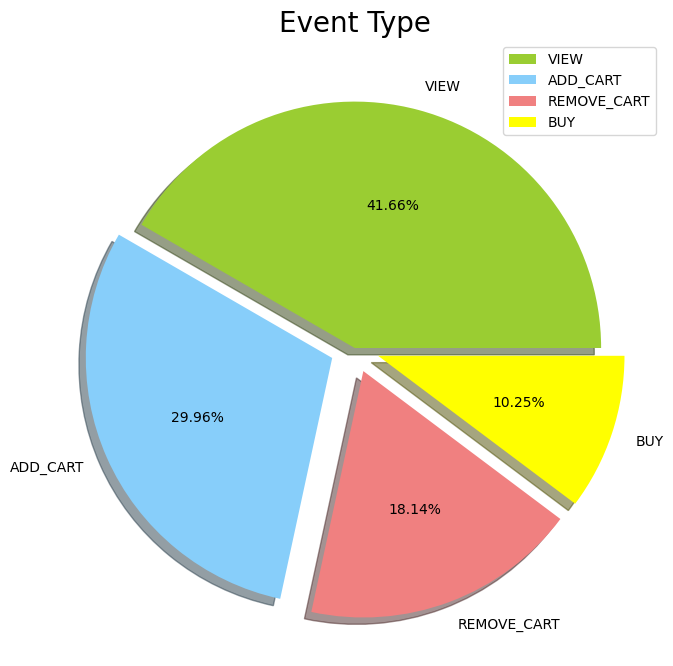

In [58]:
labels = ['VIEW','ADD_CART', 'REMOVE_CART','BUY']
size = train['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral','yellow']
explode = [0, 0.1,0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

**Distribution of Products**

Text(0.5, 1.0, 'Top 10 Products')

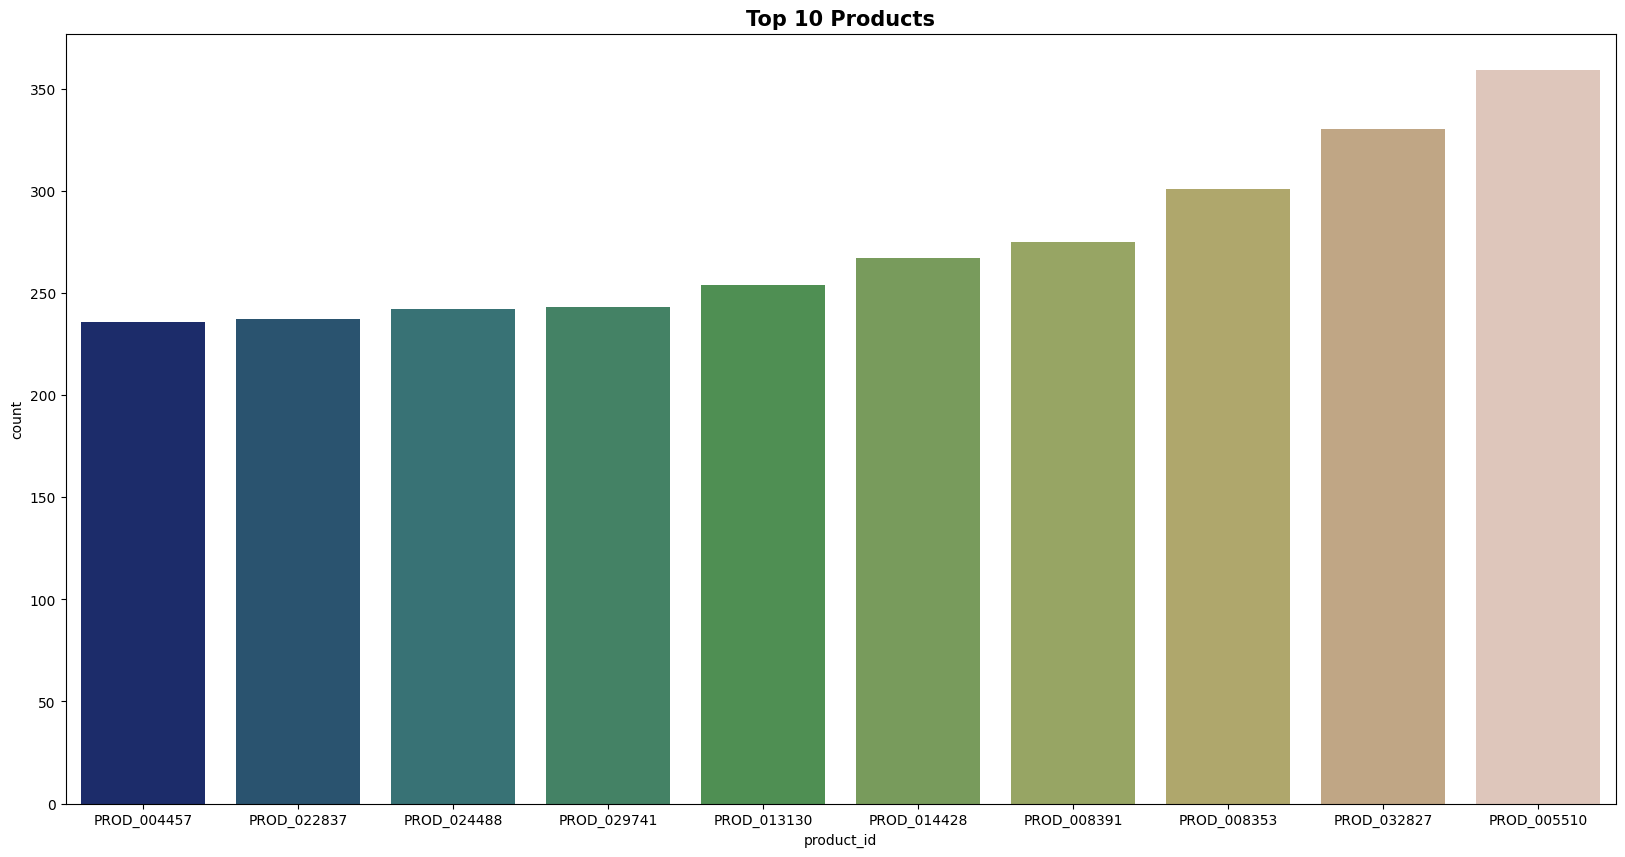

In [59]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id', data=train, palette='gist_earth',
             order=train['product_id'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

**Distribution of Top 30 Category**

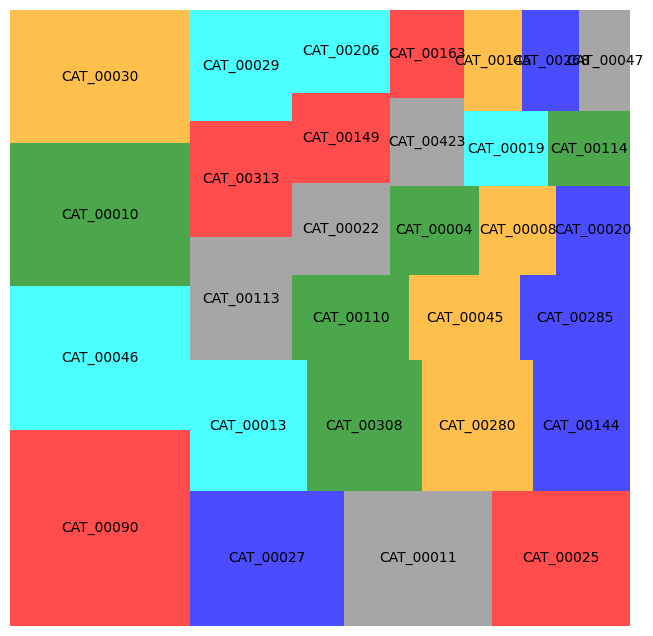

In [60]:
top_category_n = 30
top_category = train.loc[:,'category_id'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

**Distribution od Top 30 User Session**

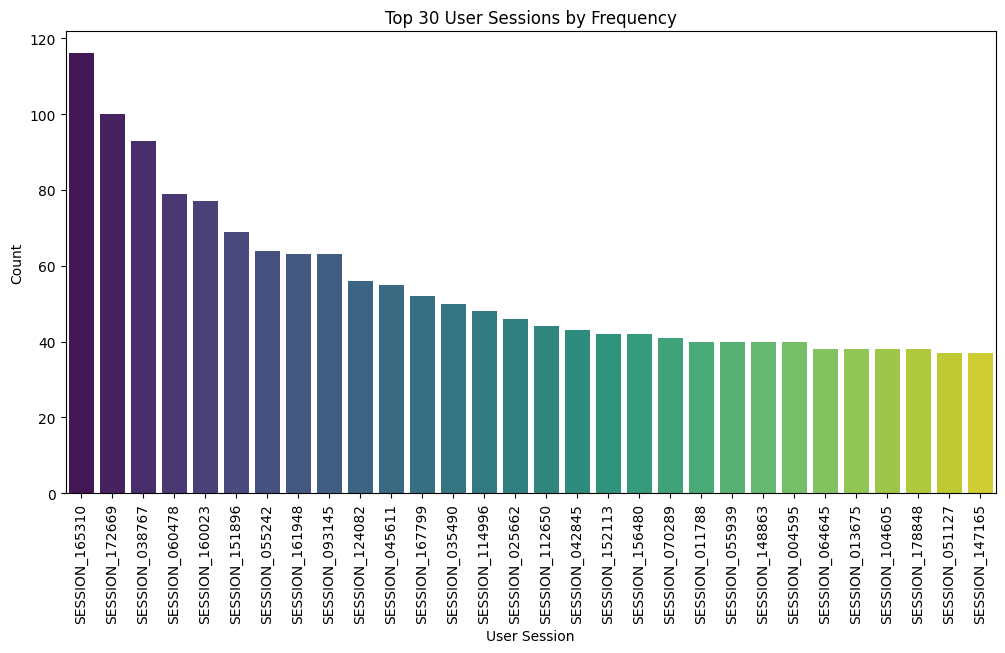

In [61]:
# Count occurrences of each session
top_sessions = train['user_session'].value_counts().head(30)

# Bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=top_sessions.index, y=top_sessions.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('User Session')
plt.ylabel('Count')
plt.title('Top 30 User Sessions by Frequency')
plt.show()

# 3.2 Numerical Variable 🔢¶

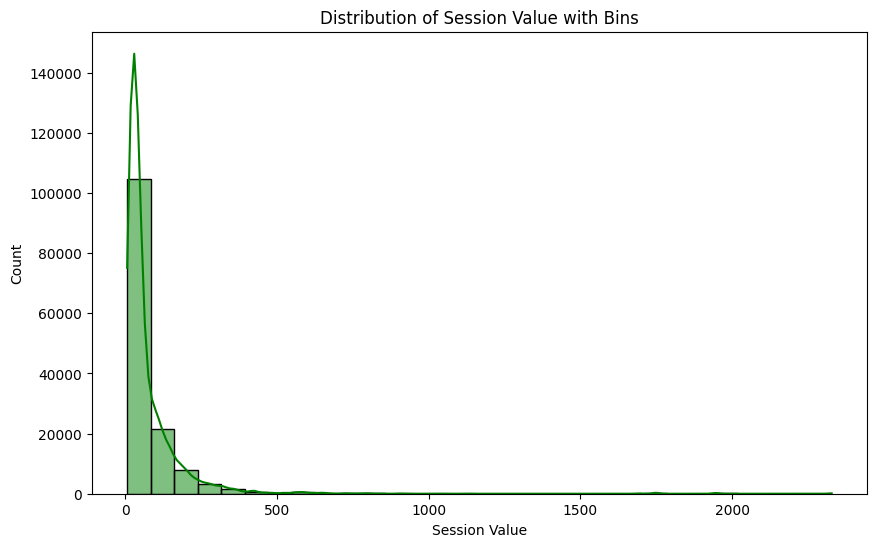

In [62]:
# Plot histogram with bins
plt.figure(figsize=(10,6))
sns.histplot(data=train, x="session_value", bins=30, kde=True, color='green')  # bins=30 divides the range into 30 intervals
plt.xlabel("Session Value")
plt.ylabel("Count")
plt.title("Distribution of Session Value with Bins")
plt.show()


## 3.2 Site Visiting Analysis

Site Visiting Analysis examines how users interact with the website over time.  
It typically involves exploring metrics such as:

- **Number of visits per user** → Identify frequent or one-time visitors.  
- **Session trends over time** → Daily, weekly, or hourly traffic patterns.  
- **Popular event types** → Views, clicks, add-to-cart, and purchases.  
- **Session duration and value** → Measure engagement and revenue contribution.  

This analysis helps understand user behaviour, peak traffic periods, and areas to improve user experience and conversion rates.


## 3.2.1 How many customers visit the site?¶

In [63]:
train["event_time"] = pd.to_datetime(train["event_time"], errors="coerce")
#creating a summary table for general overview
daily_summary_table=train.groupby(by=[train['event_time'].dt.normalize()]).agg(Number_of_daily_visits=('user_session',lambda x: x.nunique()),
                                                                                  Number_of_daily_visitors=('user_id',lambda x: x.nunique())
                                                                                  )
sales_filter=train['event_type']=='BUY'
sales=train.loc[sales_filter].groupby(by=[train['event_time'].dt.normalize()]).agg(number_of_daily_sales=('event_type','count'),
                                                                                      Total_daily_sales=('session_value','sum')
                                                                                      ).reset_index()
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
daily_summary_table['conversion_rate']=daily_summary_table['number_of_daily_sales']/daily_summary_table['Number_of_daily_visits']

## 3.2.2  Daily Visit Statistics

Daily Visits Statistics
--------------------------------------------------
count      21.000000
mean     3443.761905
std       892.865214
min      2600.000000
25%      2898.000000
50%      3246.000000
75%      3459.000000
max      5929.000000
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
--------------------------------------------------
            count         mean          std     min     25%     50%     75%  \
event_time                                                                    
Friday        3.0  3669.666667  1437.945177  2827.0  2839.5  2852.0  4091.0   
Monday        3.0  4230.666667  1471.181271  3348.0  3381.5  3415.0  4672.0   
Saturday      3.0  3893.000000   940.378115  3248.0  3353.5  3459.0  4215.5   
Sunday        3.0  3507.333333   337.153279  3129.0  3373.0  3617.0  3696.5   
Thursday      3.0  2633.666667    37.447741  2600.0  2613.5  2627.0  2650.5   
Tuesday       3.0  3210.000000 

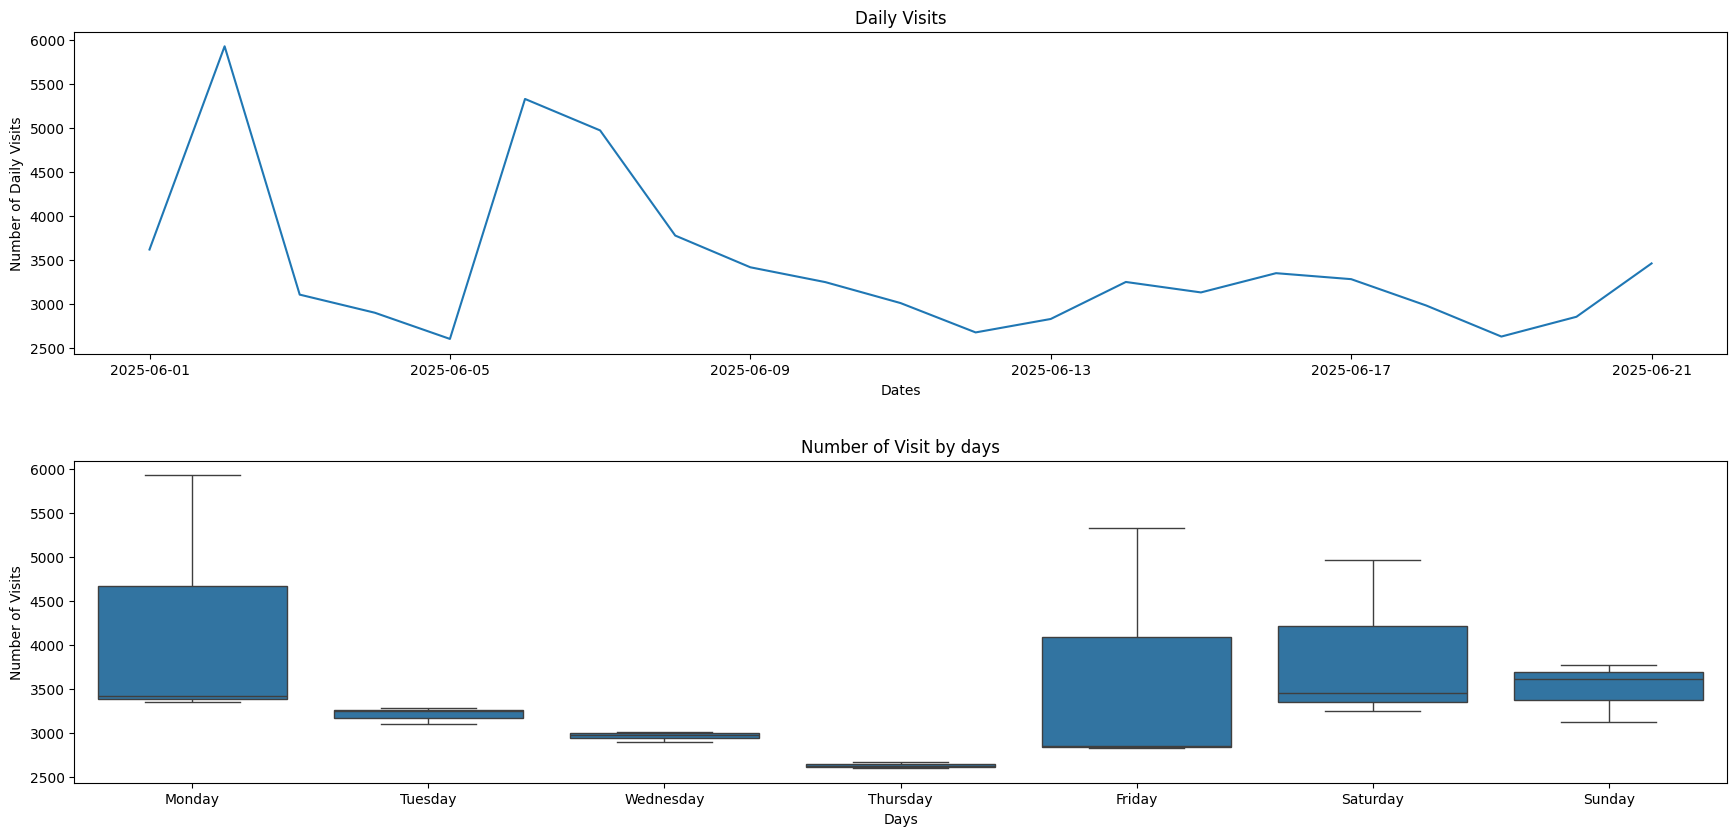

In [64]:
#Daily Visits
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visits'].describe())

#Plotting number of daily visits
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visits',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

## 3.2.3 Daily Visitor Statistics

Daily Visitor Statistics
--------------------------------------------------
count      21.000000
mean     3044.714286
std       865.204377
min      2281.000000
25%      2500.000000
50%      2806.000000
75%      3008.000000
max      5498.000000
Name: Number_of_daily_visitors, dtype: float64
--------------------------------------------------
Visitor Statistics by Dates
--------------------------------------------------
            count         mean          std     min     25%     50%     75%  \
event_time                                                                    
Friday        3.0  3313.666667  1430.146962  2476.0  2488.0  2500.0  3732.5   
Monday        3.0  3810.333333  1462.151269  2925.0  2966.5  3008.0  4253.0   
Saturday      3.0  3400.333333   896.661772  2832.0  2883.5  2935.0  3684.5   
Sunday        3.0  3108.666667   288.585054  2784.0  2995.0  3206.0  3271.0   
Thursday      3.0  2319.333333    49.338964  2281.0  2291.5  2302.0  2338.5   
Tuesday       3.0  2787.66

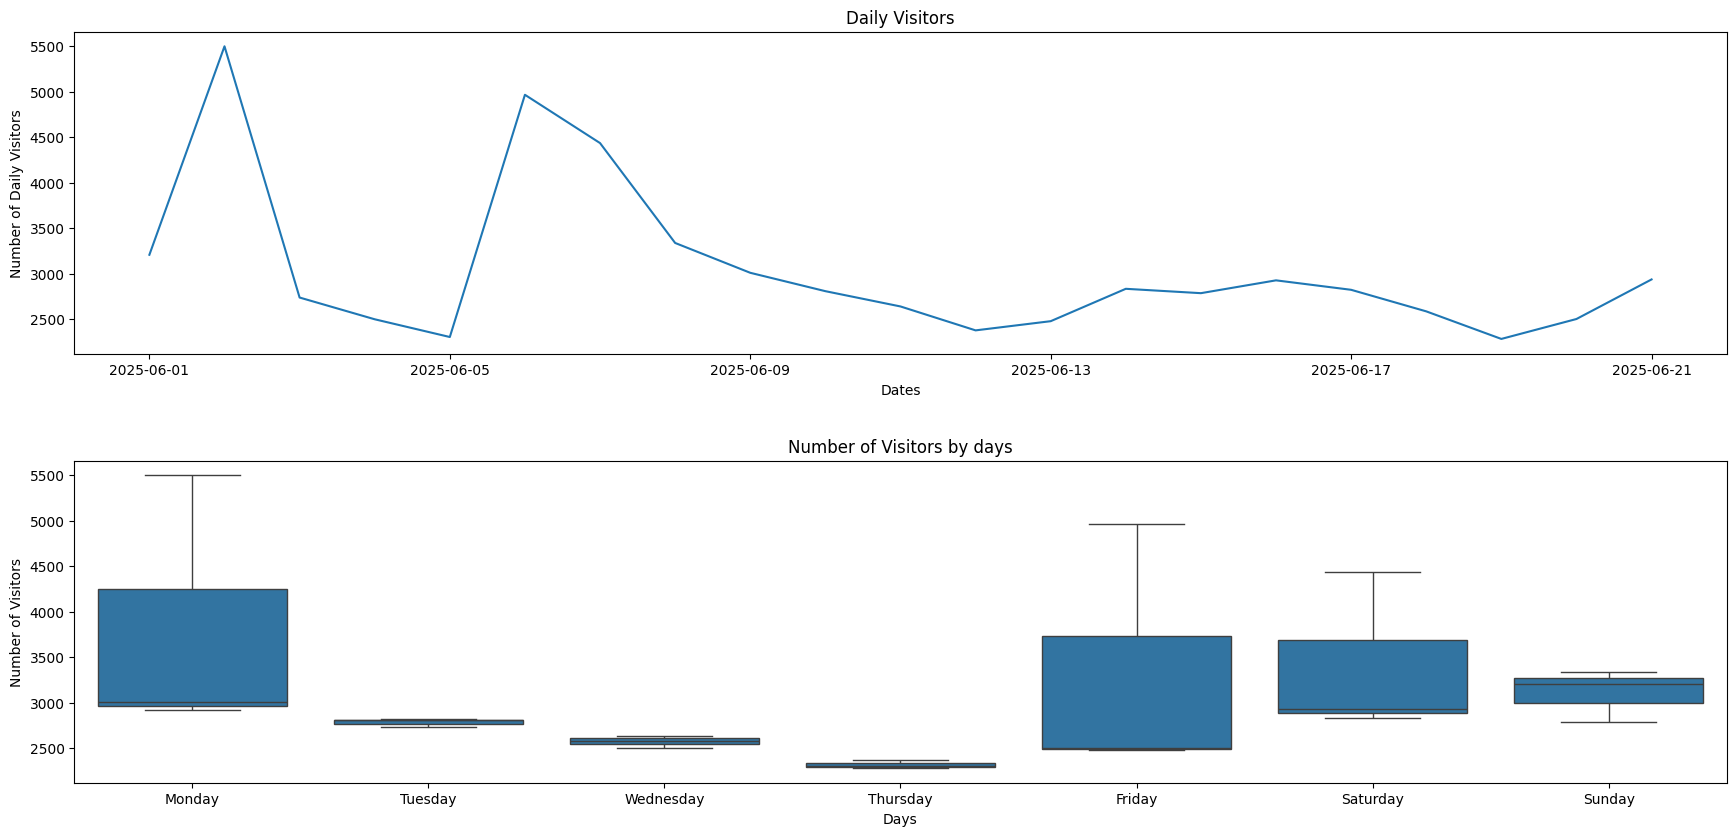

In [65]:
#Daily Visitors
print('Daily Visitor Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visitors'].describe())
print('-'*50)
print('Visitor Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visitors'].describe())

#Plotting number of daily visitors
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visitors',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Visitors')
plt.ylabel('Number of Daily Visitors')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visitors',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visitors by days')
plt.ylabel('Number of Visitors')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

## 3.2.4 Conversion Rate

Conversion Rates Statistics
--------------------------------------------------
count    21.000000
mean      0.206471
std       0.031843
min       0.122889
25%       0.198462
50%       0.212438
75%       0.230992
max       0.244207
Name: conversion_rate, dtype: float64
--------------------------------------------------
Conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        3.0  0.182174  0.051484  0.122889  0.165442  0.207994  0.211816   
Monday        3.0  0.194977  0.053973  0.133749  0.174635  0.215520  0.225591   
Saturday      3.0  0.202114  0.035194  0.162912  0.187675  0.212438  0.221715   
Sunday        3.0  0.210073  0.019347  0.197401  0.198939  0.200477  0.216410   
Thursday      3.0  0.205616  0.006342  0.198462  0.203152  0.207842  0.209194   
Tuesday       3.0  0.2325

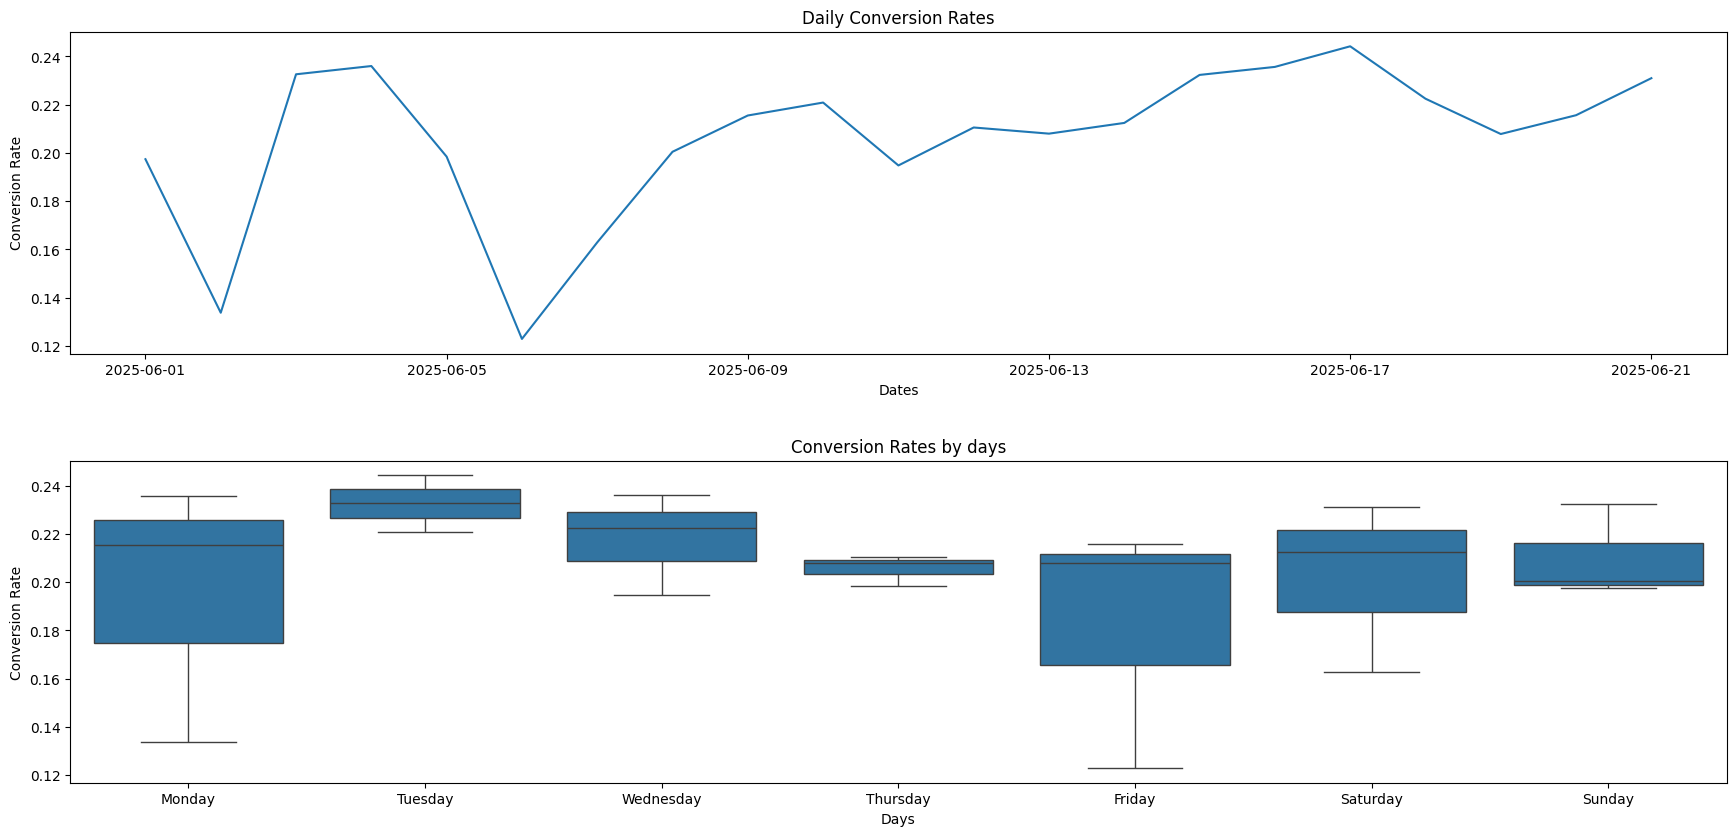

In [66]:
#Conversion rates
print('Conversion Rates Statistics')
print('-'*50)
print(daily_summary_table['conversion_rate'].describe())
print('-'*50)
print('Conversion Rates Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['conversion_rate'].describe())

#Plotting convergance rates
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='conversion_rate',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='conversion_rate',
            data=daily_summary_table,
           ax=ax2)
plt.title('Conversion Rates by days')
plt.ylabel('Conversion Rate')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

# 3.3 Category Analysis

The goal of category analysis is to understand user behavior and sales patterns at the product category level.


In [67]:
#calculating and printing informative numerical information about the dataset.
total_number_of_activity=train.shape[0]
print('Total number of activity:{:,.0f}'.format(total_number_of_activity))
print('-'*50)
total_number_of_visits=train['user_session'].nunique()
print('Total number of sessions:{:,.0f}'.format(total_number_of_visits))
print('-'*50)
total_number_of_visitors=train['user_id'].nunique()
print('Total number of users:{:,.0f}'.format(total_number_of_visitors))
print('-'*50)
number_of_categories=train['category_id'].nunique()
print('The number of categories:{:,.0f}'.format(number_of_categories))

print('-'*50)
number_of_products=train['product_id'].nunique()
print('The number of products:{:,.0f}'.format(number_of_products))

Total number of activity:141,219
--------------------------------------------------
Total number of sessions:70,736
--------------------------------------------------
Total number of users:51,821
--------------------------------------------------
The number of categories:448
--------------------------------------------------
The number of products:26,470


- **Total number of activities:** 141,219  
  - Includes all recorded events such as `view`, `add-to-cart`, and `purchase`.  
  - Provides an overview of overall user engagement.  

- **Total number of visits:** 70,736  
  - Unique user sessions, showing how many times the platform was accessed.  
  - Useful to track session-based engagement trends.  

- **Total number of visitors:** 51,821  
  - Unique users interacting with the site.  
  - Helps identify active users versus one-time visitors.  

- **Number of categories:** 448  
  - Indicates product diversity.  
  - Sub-analysis can reveal which categories drive the most engagement or sales.  

- **Number of products:** 26,470  
  - Total items across all categories.  
  - Helps identify top-selling products or categories with low engagement.  

In [68]:
#creating a summary table that contains an outline of categories and activities
category_summary_table=train.groupby(by=['category_id']).agg(Number_of_views=('category_id','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
sales_filter=train['event_type']=='BUY'
category_sales_summary_table=train.loc[sales_filter].groupby(by=['category_id']).agg(Number_of_purchase=('category_id','count'),
                                                                                      Amount_of_purchase=('session_value','sum'),
                                                                                      Average_purchase_amount=('session_value','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_summary_table=pd.merge(left=category_summary_table,
                               right=category_sales_summary_table,
                               left_on='category_id',
                               right_on='category_id',
                               how='left')
category_summary_table['Conversion_rate']=category_summary_table['Number_of_purchase']/category_summary_table['Number_of_sessions']

## 3.3.1 Most Viewed vs. Most Purchased Categories

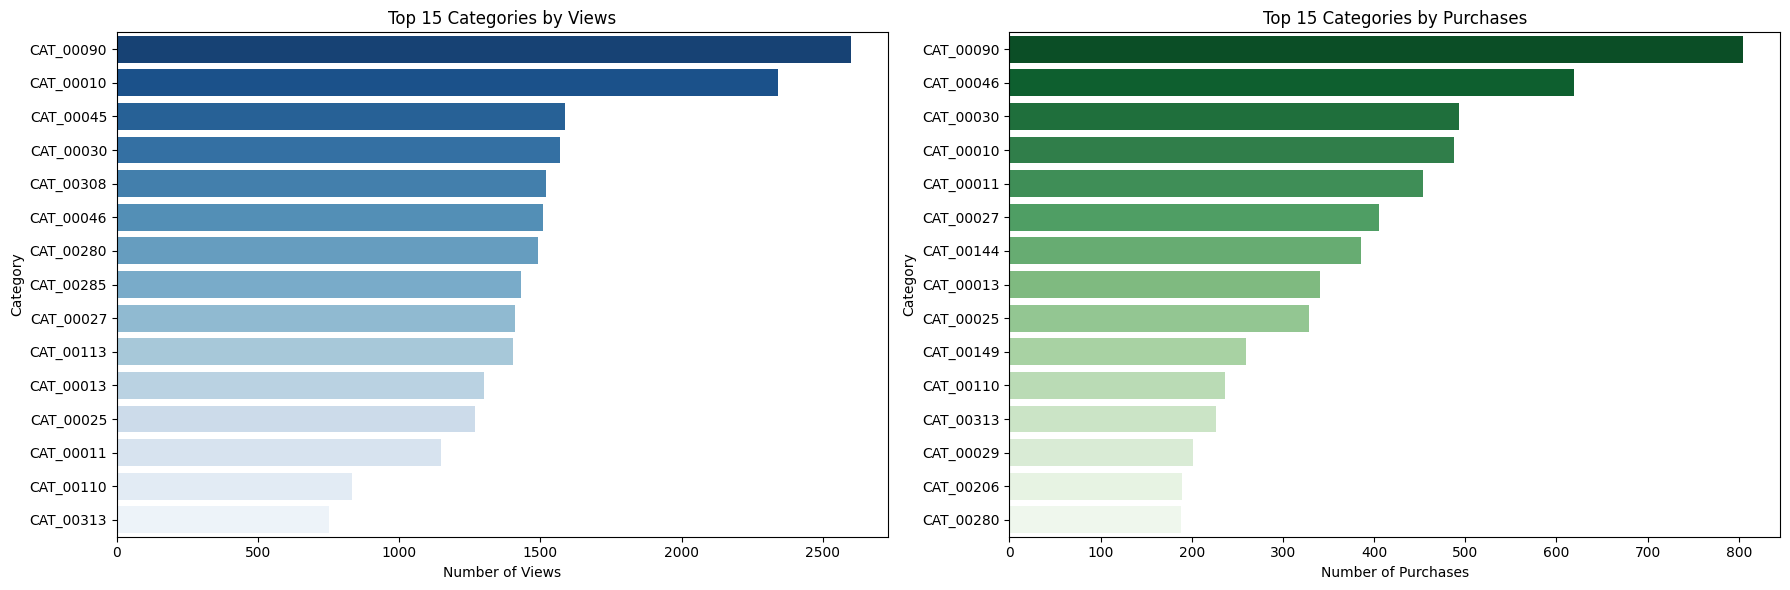

In [69]:
# Aggregate views and purchases per category
category_stats = train.groupby(['category_id', 'event_type']).size().unstack(fill_value=0).reset_index()

# Ensure missing event types are handled
category_stats['VIEW'] = category_stats.get('VIEW', 0)
category_stats['BUY'] = category_stats.get('BUY', 0)

# Sort top 15 categories by views and purchases
top_viewed = category_stats.sort_values('VIEW', ascending=False).head(15)
top_bought = category_stats.sort_values('BUY', ascending=False).head(15)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18,6))

sns.barplot(x='VIEW', y='category_id', data=top_viewed, ax=axes[0], palette='Blues_r')
axes[0].set_title("Top 15 Categories by Views")
axes[0].set_xlabel("Number of Views")
axes[0].set_ylabel("Category")

sns.barplot(x='BUY', y='category_id', data=top_bought, ax=axes[1], palette='Greens_r')
axes[1].set_title("Top 15 Categories by Purchases")
axes[1].set_xlabel("Number of Purchases")
axes[1].set_ylabel("Category")

plt.tight_layout()
plt.show()

The following charts compare the **top 15 categories** by total number of views and purchases:  
- The **left chart** highlights the categories that attract the most attention (views).  
- The **right chart** highlights the categories that drive the most actual sales (purchases).  


## 3.3.2 Top 20 Categories by Number of Users

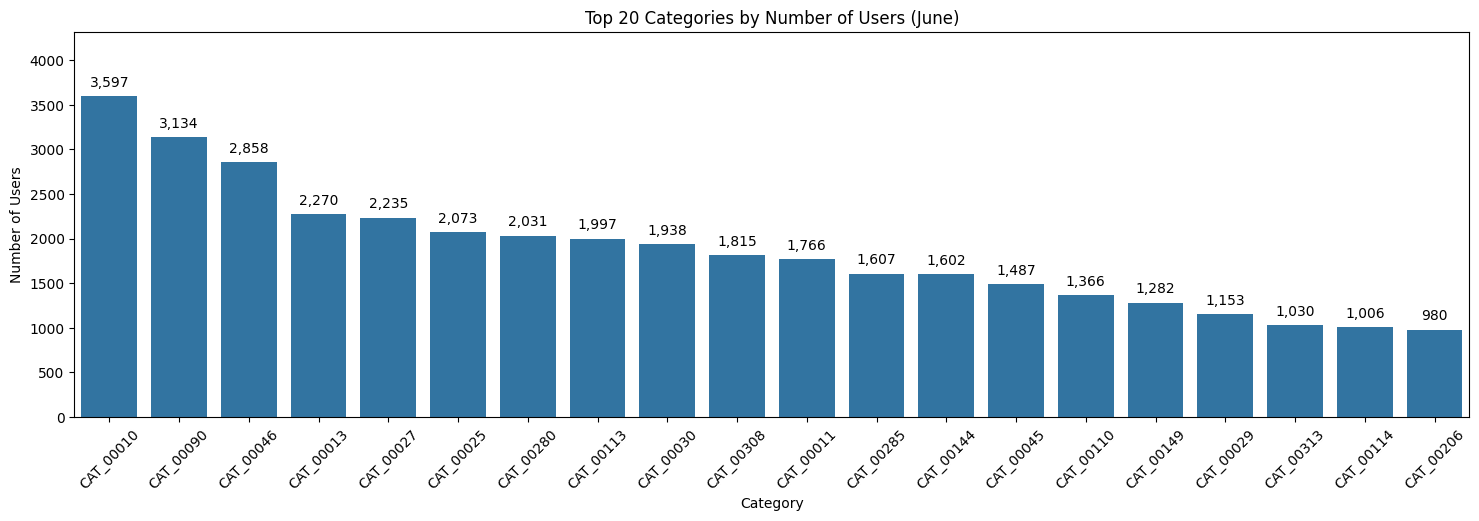

In [70]:

# Select top 20 categories by number of users
top20_users = category_summary_table.sort_values("Number_of_users", ascending=False).head(20)

plt.figure(figsize=(18,5))
plot = sns.barplot(
    x='category_id',
    y='Number_of_users',
    data=top20_users,
    order=top20_users['category_id']  # keep order sorted
)

# Annotate values on bars
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 10),
                  textcoords='offset points')

plt.title('Top 20 Categories by Number of Users (June)')
plt.xlabel('Category')
plt.ylabel('Number of Users')
plt.ylim(0, top20_users['Number_of_users'].max() * 1.2)
plt.xticks(rotation=45)  # rotate labels if needed
plt.show()


## 3.3.3 Top 20 Categories by Conversion Rate

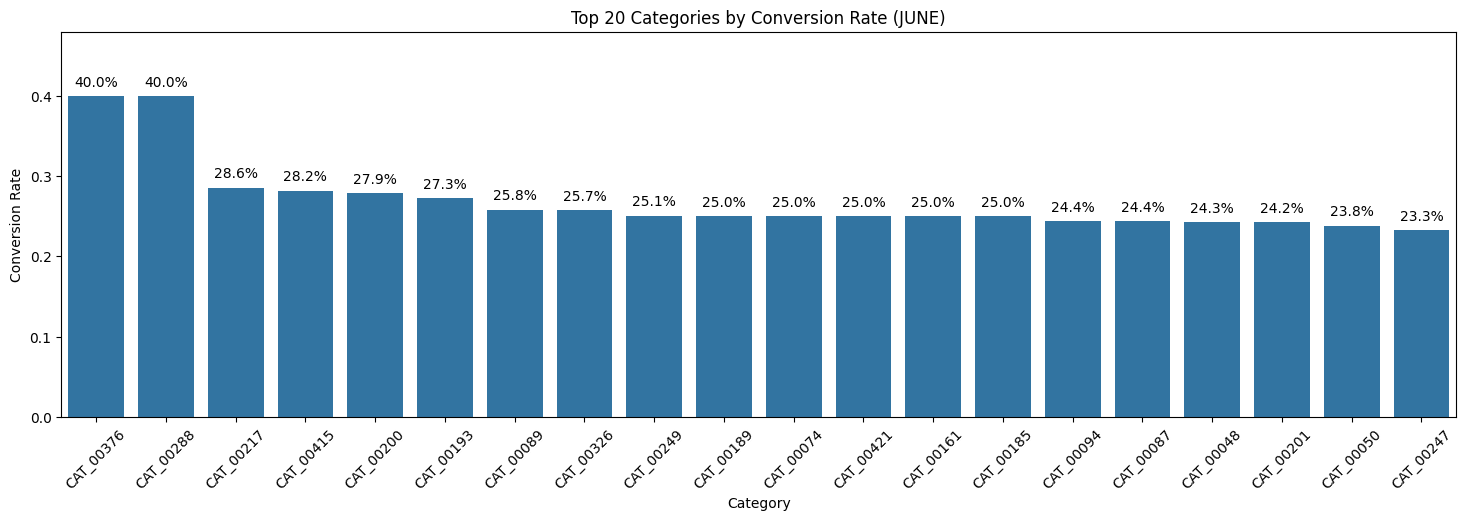

In [71]:
# Select top 20 categories by conversion rate
top20_conv = category_summary_table.sort_values("Conversion_rate", ascending=False).head(20)

plt.figure(figsize=(18,5))
plot = sns.barplot(
    x='category_id',
    y='Conversion_rate',
    data=top20_conv,
    order=top20_conv['category_id']  # keep sorted order
)

# Annotate bars with percentage values
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 10),
                  textcoords='offset points')

plt.title('Top 20 Categories by Conversion Rate (JUNE)')
plt.xlabel('Category')
plt.ylabel('Conversion Rate')
plt.ylim(0, top20_conv['Conversion_rate'].max() * 1.2)
plt.xticks(rotation=45)
plt.show()


## 3.3.4 Turnover by Category

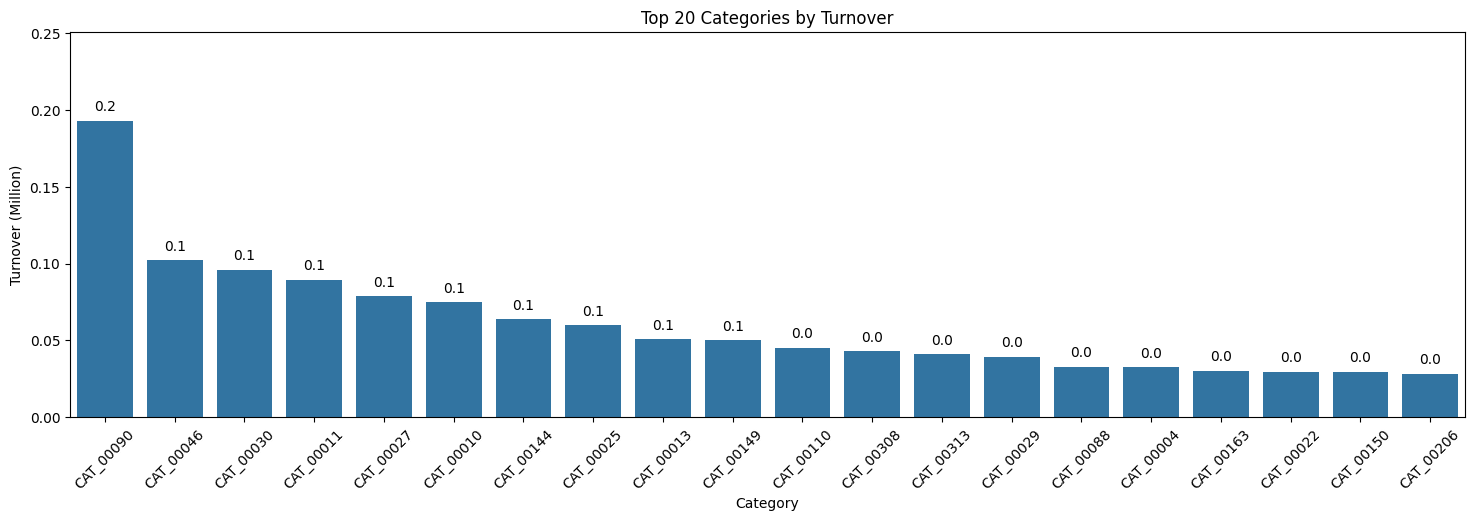

In [72]:
# Aggregate turnover by category
category_turnover_table = (
    category_summary_table.groupby(by=['category_id'])
    .agg(total_turnover=('Amount_of_purchase','sum'))
    .reset_index()
)

# Convert to millions
category_turnover_table['total_turn_over_mio'] = category_turnover_table['total_turnover'] / 1_000_000

# Take top 20 by turnover
top20_turnover = category_turnover_table.sort_values("total_turn_over_mio", ascending=False).head(20)

# Plot
plt.figure(figsize=(18,5))
plot = sns.barplot(
    x='category_id',
    y='total_turn_over_mio',
    data=top20_turnover,
    order=top20_turnover['category_id']
)

# Annotate values on bars
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 10),
                  textcoords='offset points')

plt.title('Top 20 Categories by Turnover')
plt.xlabel('Category')
plt.ylabel('Turnover (Million)')
plt.ylim(0, top20_turnover['total_turn_over_mio'].max() * 1.3)
plt.xticks(rotation=45)
plt.show()


`cat_00090` contributes the largest share with a turnover size of **0.2M**.

Other categories such as `cat_00046`, `cat_00030`, `cat_00011`, `cat_00010`, `cat_00044`, `cat_00025`, `cat_00013`, `cat_000149` each contribute around **0.1M** turnover.

The remaining categories generate negligible (**0.0M**) turnover.

This shows that revenue is highly concentrated in just a few categories, while most categories have very little or no contribution.

# 3.4 Product Analysis

## 3.4.1 Most Viewed vs. Most Purchased Products

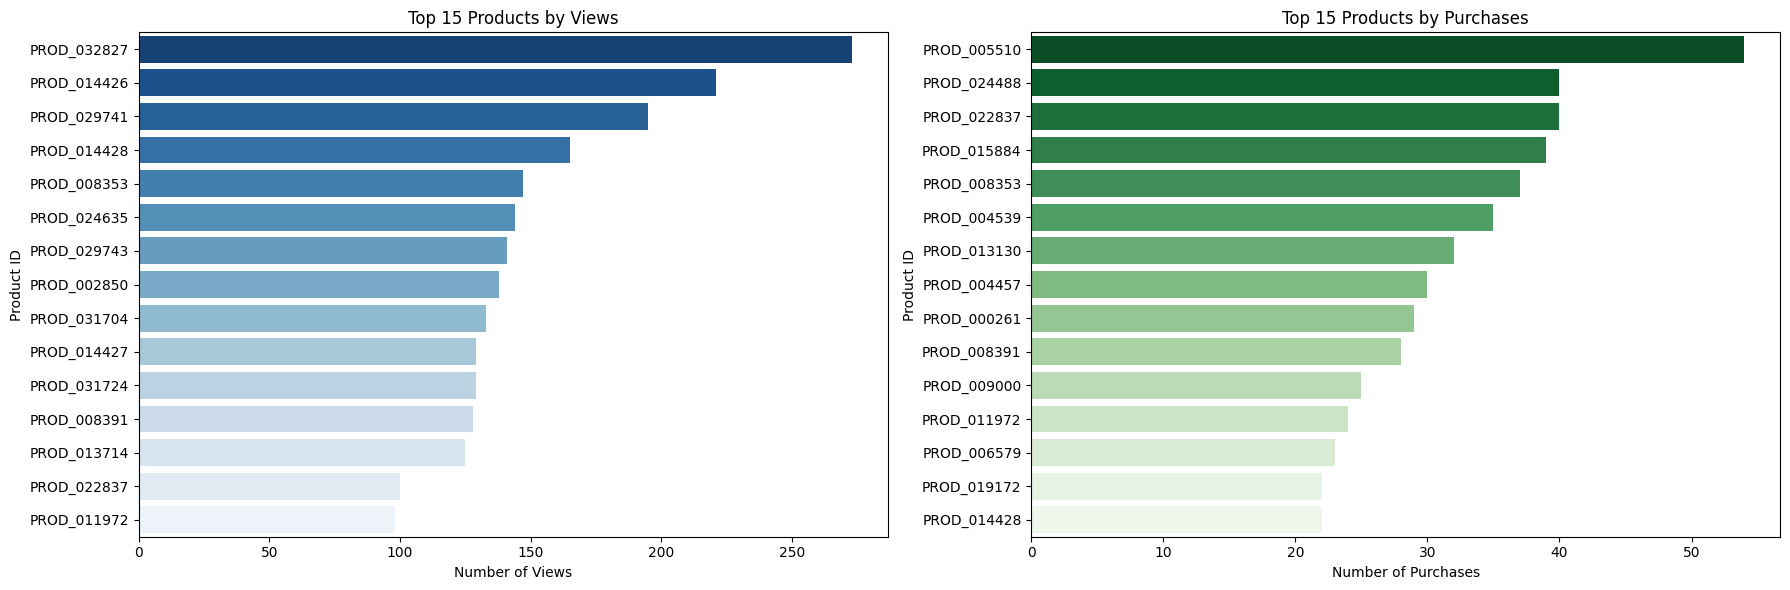

In [73]:

# Aggregate views and purchases per product
product_stats = train.groupby(['product_id', 'event_type']).size().unstack(fill_value=0).reset_index()

# Ensure missing event types are handled
product_stats['VIEW'] = product_stats.get('VIEW', 0)
product_stats['BUY'] = product_stats.get('BUY', 0)

# Sort top 15 products by views and purchases
top_viewed_products = product_stats.sort_values('VIEW', ascending=False).head(15)
top_bought_products = product_stats.sort_values('BUY', ascending=False).head(15)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18,6))

sns.barplot(x='VIEW', y='product_id', data=top_viewed_products, ax=axes[0], palette='Blues_r')
axes[0].set_title("Top 15 Products by Views")
axes[0].set_xlabel("Number of Views")
axes[0].set_ylabel("Product ID")

sns.barplot(x='BUY', y='product_id', data=top_bought_products, ax=axes[1], palette='Greens_r')
axes[1].set_title("Top 15 Products by Purchases")
axes[1].set_xlabel("Number of Purchases")
axes[1].set_ylabel("Product ID")

plt.tight_layout()
plt.show()


## 3.4.2 Number of Products Never Viewed or Bought


The chart below shows how many products were **never viewed** and how many were **never purchased**.  This helps us understand product engagement and highlights the "long tail" of items that do not attract customer attention.

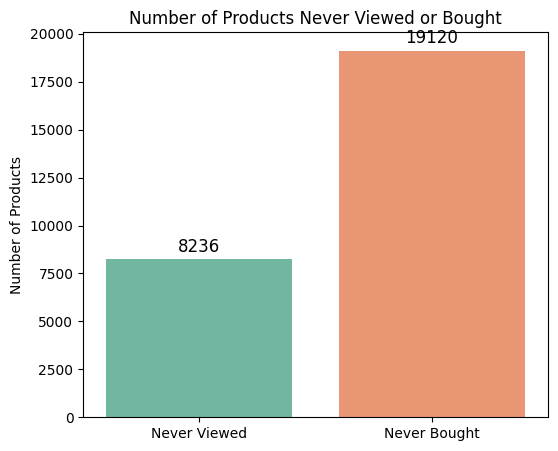

In [74]:
# Görselleştirme için dataframe

product_stats = train.groupby('product_id')['event_type'].value_counts().unstack(fill_value=0)
never_viewed = (product_stats.get('VIEW',0)==0).sum() 
never_bought = (product_stats.get('BUY',0)==0).sum() 

never_stats = pd.DataFrame({
    'Status': ['Never Viewed', 'Never Bought'],
    'Count': [never_viewed, never_bought]
})

# Barplot
plt.figure(figsize=(6,5))
sns.barplot(data=never_stats, x='Status', y='Count', palette='Set2')

# Üstüne sayıları ekleyelim
for i, val in enumerate(never_stats['Count']):
    plt.text(i, val + max(never_stats['Count'])*0.01, str(val), ha='center', va='bottom', fontsize=12)

plt.title("Number of Products Never Viewed or Bought")
plt.ylabel("Number of Products")
plt.xlabel("")
plt.show()


 **8,236 products were never viewed** → These items did not receive any customer attention, which could indicate issues with product placement, recommendations, or visibility on the platform.  
**19,120 products were never purchased** → A large portion of the catalog has zero sales, suggesting a strong "long tail" effect where only a small subset of products drives most purchases.  


## 3.4.3 Cart Abandonment Analysis

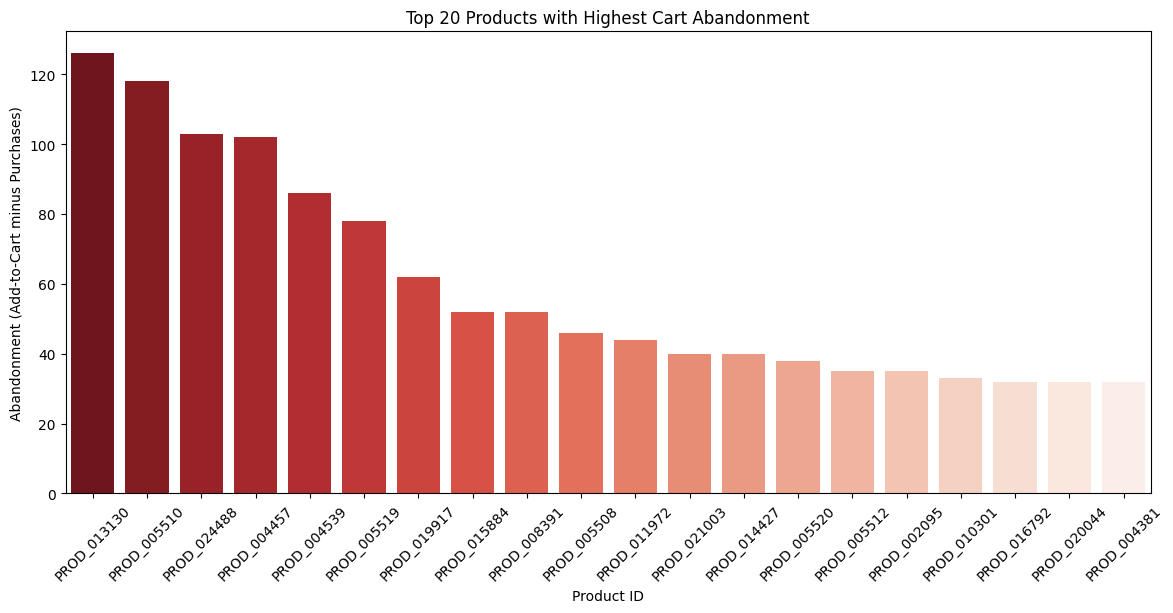

In [75]:
# Cart abandonment analysis
# Count ADD_CART and BUY per product
cart_vs_buy = (
    train.groupby('product_id')['event_type']
      .value_counts()
      .unstack(fill_value=0)
      .reset_index()
)

# Ensure missing columns exist
for col in ['ADD_CART', 'BUY']:
    if col not in cart_vs_buy.columns:
        cart_vs_buy[col] = 0

# Calculate abandonment (added but not bought)
cart_vs_buy['abandonment'] = cart_vs_buy['ADD_CART'] - cart_vs_buy['BUY']
cart_vs_buy = cart_vs_buy.sort_values('abandonment', ascending=False)

# Top 20 abandoned products
top_abandoned = cart_vs_buy.head(20)

# Visualization
plt.figure(figsize=(14,6))
sns.barplot(x='product_id', y='abandonment', data=top_abandoned, palette='Reds_r')
plt.title('Top 20 Products with Highest Cart Abandonment')
plt.xlabel('Product ID')
plt.ylabel('Abandonment (Add-to-Cart minus Purchases)')
plt.xticks(rotation=45)
plt.show()


## 3.4.4 Repeat Purchases / Loyalty Products

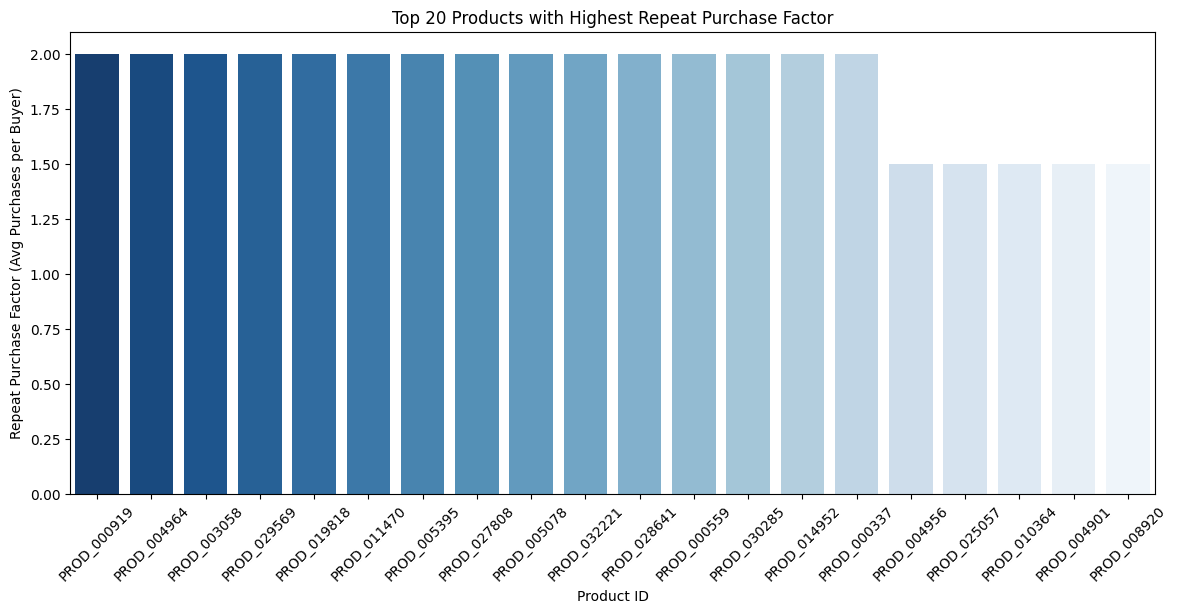

In [76]:
# Repeat Purchases / Loyalty Products

# Count unique users buying each product
repeat_purchases = (
    train[train['event_type'] == 'BUY']
    .groupby('product_id')['user_id']
    .nunique()
    .reset_index(name='unique_buyers')
)

# Count total purchases per product
repeat_purchases['total_purchases'] = (
    train[train['event_type'] == 'BUY']
    .groupby('product_id')['user_id']
    .count()
    .values
)

# Calculate repeat purchase factor (avg purchases per buyer)
repeat_purchases['repeat_factor'] = (
    repeat_purchases['total_purchases'] / repeat_purchases['unique_buyers']
)

# Sort by repeat_factor
loyalty_products = repeat_purchases.sort_values('repeat_factor', ascending=False).head(20)

# Visualization
plt.figure(figsize=(14,6))
sns.barplot(x='product_id', y='repeat_factor', data=loyalty_products, palette='Blues_r')
plt.title('Top 20 Products with Highest Repeat Purchase Factor')
plt.xlabel('Product ID')
plt.ylabel('Repeat Purchase Factor (Avg Purchases per Buyer)')
plt.xticks(rotation=45)
plt.show()


## 3.4.5 Time-to-Purchase Analysis


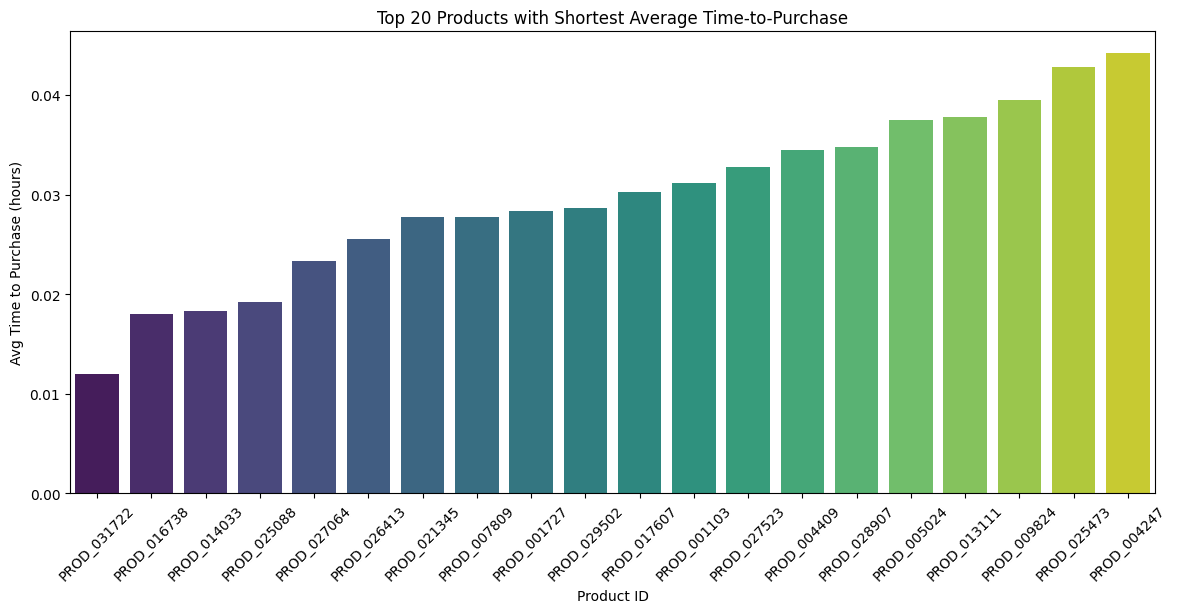

In [77]:
# Time-to-Purchase Analysis

# Filter view and buy events
views = train[train['event_type'] == 'VIEW'][['user_id', 'product_id', 'event_time']]
buys =train[train['event_type'] == 'BUY'][['user_id', 'product_id', 'event_time']]

# Merge to match views and buys per user-product
view_buy = pd.merge(
    views, buys,
    on=['user_id', 'product_id'],
    suffixes=('_view', '_buy')
)

# Keep only cases where view happens before buy
view_buy = view_buy[view_buy['event_time_view'] < view_buy['event_time_buy']]

# Calculate time difference in hours
view_buy['time_to_purchase'] = (
    (view_buy['event_time_buy'] - view_buy['event_time_view']).dt.total_seconds() / 3600
)

# Average time-to-purchase per product
ttp_products = (
    view_buy.groupby('product_id')['time_to_purchase']
    .mean()
    .reset_index()
    .sort_values('time_to_purchase')
    .head(20)
)

# Visualization
plt.figure(figsize=(14,6))
sns.barplot(x='product_id', y='time_to_purchase', data=ttp_products, palette='viridis')
plt.title('Top 20 Products with Shortest Average Time-to-Purchase')
plt.xlabel('Product ID')
plt.ylabel('Avg Time to Purchase (hours)')
plt.xticks(rotation=45)
plt.show()


## 3.4.6 Cross-Selling / Basket Analysis

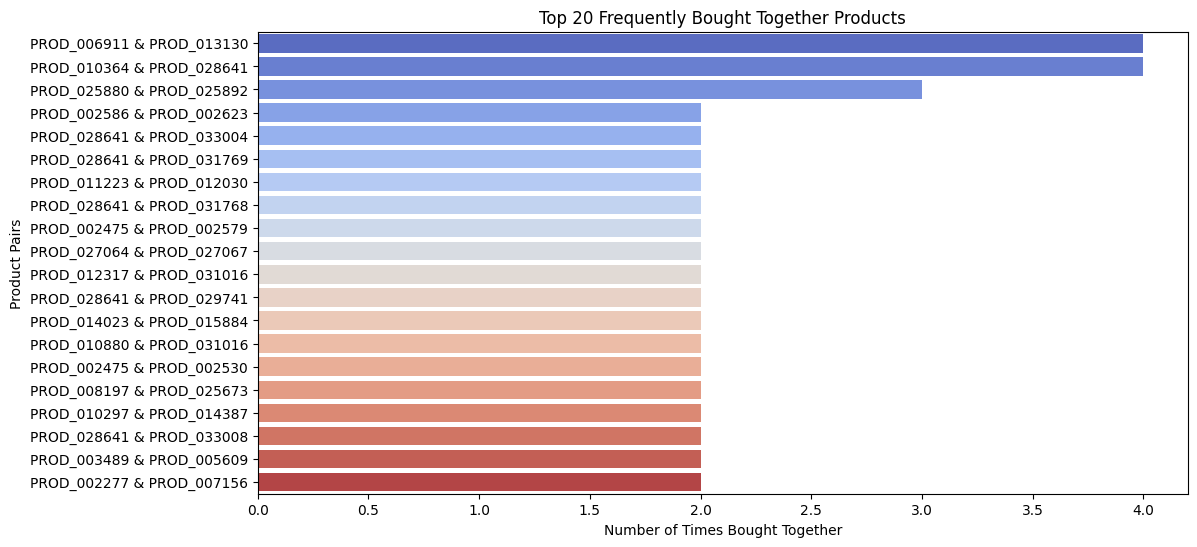

In [78]:

# Filter only purchase events
buys = train[train['event_type'] == 'BUY'][['user_session', 'product_id']]

# Create a list of products per session
session_products = buys.groupby('user_session')['product_id'].apply(list)

# Count co-occurrences using itertools
from itertools import combinations
from collections import Counter

co_occurrences = Counter()

for products in session_products:
    # consider all pairs of products in the session
    for pair in combinations(sorted(products), 2):
        co_occurrences[pair] += 1

# Convert to DataFrame
co_occurrence_df = pd.DataFrame(co_occurrences.items(), columns=['product_pair', 'count'])
co_occurrence_df = co_occurrence_df.sort_values('count', ascending=False).head(20)

# Split product_pair into two columns for easier plotting
co_occurrence_df[['product_1', 'product_2']] = pd.DataFrame(co_occurrence_df['product_pair'].tolist(), index=co_occurrence_df.index)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(x='count', y=co_occurrence_df['product_1'] + ' & ' + co_occurrence_df['product_2'], data=co_occurrence_df, palette='coolwarm')
plt.xlabel('Number of Times Bought Together')
plt.ylabel('Product Pairs')
plt.title('Top 20 Frequently Bought Together Products')
plt.show()


# 3.5 Customer Analysis

In [79]:
#Filtering sales activities
sales_filter=train['event_type']=='BUY'
Customer_table=train.loc[sales_filter].groupby(by=['user_id']).agg(number_of_purchases=('user_id','count'),
                                                                     total_sales=('session_value','sum')).reset_index()

## 3.5.1 Repeated Customers

In [80]:
#Calculating number of customers who bought something
Number_of_customers_who_bought_smt=Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in June.'.format(Number_of_customers_who_bought_smt))

#Calculating number of purchase activities for each customer
print('-'*50)
print('Distribution of Customer by Number of Purchases')
print(Customer_table['number_of_purchases'].value_counts(normalize=True).head(10))
#Calculationg repeat customers number
print('-'*50)
more_than_one_purchase_filter=Customer_table['number_of_purchases']>1
Number_of_customers_who_bought_more_than_once=Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

There are 8,278 customers, who purchased in June.
--------------------------------------------------
Distribution of Customer by Number of Purchases
number_of_purchases
1     0.595917
2     0.230611
3     0.096521
4     0.038536
5     0.018000
6     0.008215
7     0.004953
9     0.002054
8     0.001812
10    0.001691
Name: proportion, dtype: float64
--------------------------------------------------
There are 3,345 repeat customers, who bought more than once.


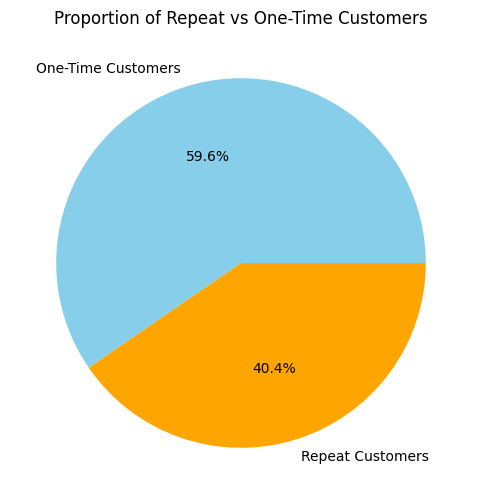

In [81]:
repeat_customers = Customer_table['number_of_purchases'] > 1
counts = repeat_customers.value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=['One-Time Customers','Repeat Customers'], autopct='%1.1f%%', colors=['skyblue','orange'])
plt.title('Proportion of Repeat vs One-Time Customers')
plt.show()

## 3.5.2 Filtering Out Outliers in Customer Sales and Visualising Their Distribution

       number_of_purchases   total_sales
count          8278.000000   8278.000000
mean              1.748128    308.071599
std               1.322012    874.794703
min               1.000000     15.690000
25%               1.000000     87.657500
50%               1.000000    115.575000
75%               2.000000    305.225000
max              29.000000  56460.970000
       number_of_purchases  total_sales
count          7781.000000  7781.000000
mean              1.544789   207.357927
std               0.817203   190.297844
min               1.000000    39.210000
25%               1.000000    87.220000
50%               1.000000   112.820000
75%               2.000000   281.180000
max               6.000000  1003.640000


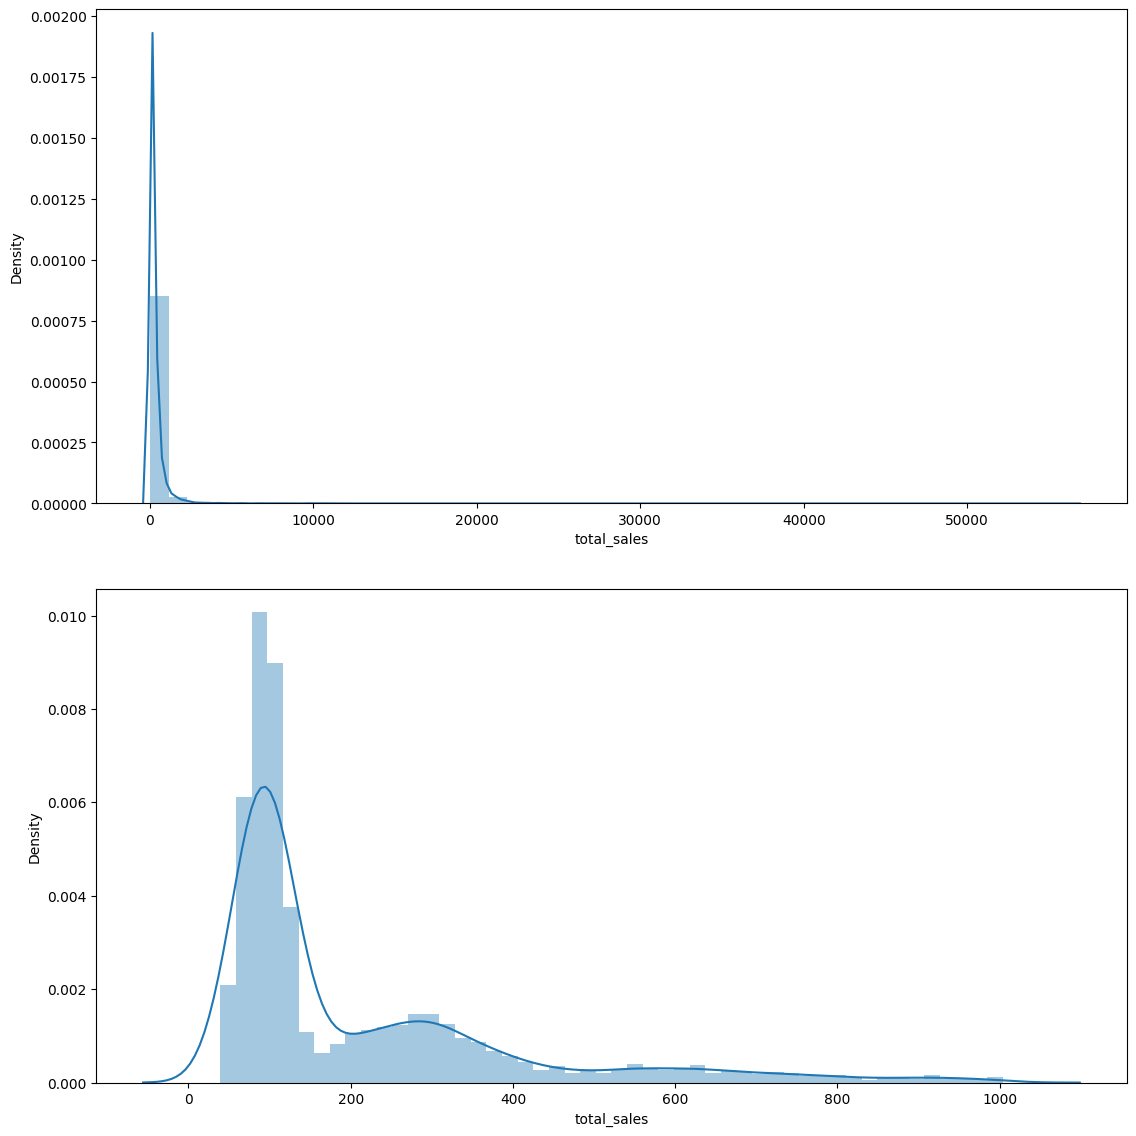

In [82]:
#filtering out the extreme values
sales_threshold=np.percentile(Customer_table['total_sales'],[1,95])
sales_threshold_filter=np.logical_and(Customer_table['total_sales']>=sales_threshold[0],
                                      Customer_table['total_sales']<=sales_threshold[1])
sales_filtered=Customer_table.loc[sales_threshold_filter]
print(Customer_table.describe())
print(sales_filtered.describe())

fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.distplot(Customer_table['total_sales'],
            ax=ax1)

ax2=fig.add_subplot(2,1,2)
sns.distplot(sales_filtered['total_sales'],
            ax=ax2)

fig.tight_layout(pad=3.0);

## 3.5.3 Identifying and Analyzing Most Valuable Customers Based on Top 10% Purchase Amount

In [83]:
#Most valuable customers

#filtering customer with top %10 purchase amount
top10perc_sales_amount=np.percentile(Customer_table['total_sales'],90)
filter_top10perc_sales_amount=Customer_table['total_sales']>=top10perc_sales_amount
top10perc_customers_with_hightest_turnover=Customer_table.loc[filter_top10perc_sales_amount]
regular_customers=Customer_table.loc[~filter_top10perc_sales_amount]

#calculating descriptive statistics
print('Top 10% customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(top10perc_customers_with_hightest_turnover['total_sales'].describe())
print('-'*50)
total_sales_amount=Customer_table['total_sales'].sum()
print('Total sales: {:,.0f}'.format(total_sales_amount))
total_sales_amount_top10perc=top10perc_customers_with_hightest_turnover['total_sales'].sum()
print('Total sales of top 10% customers: {:,.0f}'.format(total_sales_amount_top10perc))

#calculating descriptive statistics
print('Regular customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(regular_customers['total_sales'].describe())
print('-'*50)
total_sales_amount_regular_customers=regular_customers['total_sales'].sum()
print('Total sales of regular customers: {:,.0f}'.format(total_sales_amount_regular_customers))

Top 10% customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count      828.000000
mean      1519.786002
std       2421.576444
min        634.920000
25%        760.400000
50%       1004.405000
75%       1520.550000
max      56460.970000
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales: 2,550,217
Total sales of top 10% customers: 1,258,383
Regular customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count    7450.000000
mean      173.400522
std       133.983859
min        15.690000
25%        85.030000
50%       108.980000
75%       248.110000
max       634.900000
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales of regular customers: 1,291,834


- **Top 10% Customers:**

- Represent 828 customers with much higher spending.

- Average purchase amount is ~1,520, with a few extreme values up to 56,461.

- They contribute ~49% of total sales (1,258,383 out of 2,550,217), showing their outsized impact on revenue.

- **Regular Customers:**

- Represent 7,450 customers with lower spending.

- Average purchase amount is ~173, with a max of 635.

- Contribute the remaining ~51% of total sales (1,291,834), meaning most customers spend less individually but collectively make up a large portion.

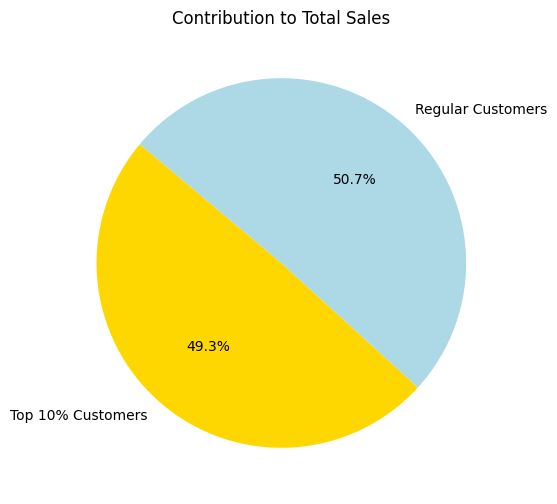

In [84]:
# Sales amounts
sales_data = [total_sales_amount_top10perc, total_sales_amount_regular_customers]
labels = ['Top 10% Customers', 'Regular Customers']
colors = ['gold', 'lightblue']

plt.figure(figsize=(6,6))
plt.pie(sales_data, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Contribution to Total Sales')
plt.show()

## 3.5.3 Customer Segmentation Using KMeans Clustering Based on Total Session Values

Cluster Statistics
--------------------------------------------------
          count         mean          std     min      25%       50%  \
cluster                                                                
0.0      5114.0    95.444685    28.556619   15.69   77.265    93.705   
1.0      1782.0   289.674736    55.098242  192.74  245.010   288.530   
2.0       554.0   519.006119    71.203651  404.86  451.575   524.880   
3.0       828.0  1519.786002  2421.576444  634.92  760.400  1004.405   

               75%       max  
cluster                       
0.0       110.5975    192.72  
1.0       330.5200    404.04  
2.0       578.0325    634.90  
3.0      1520.5500  56460.97  


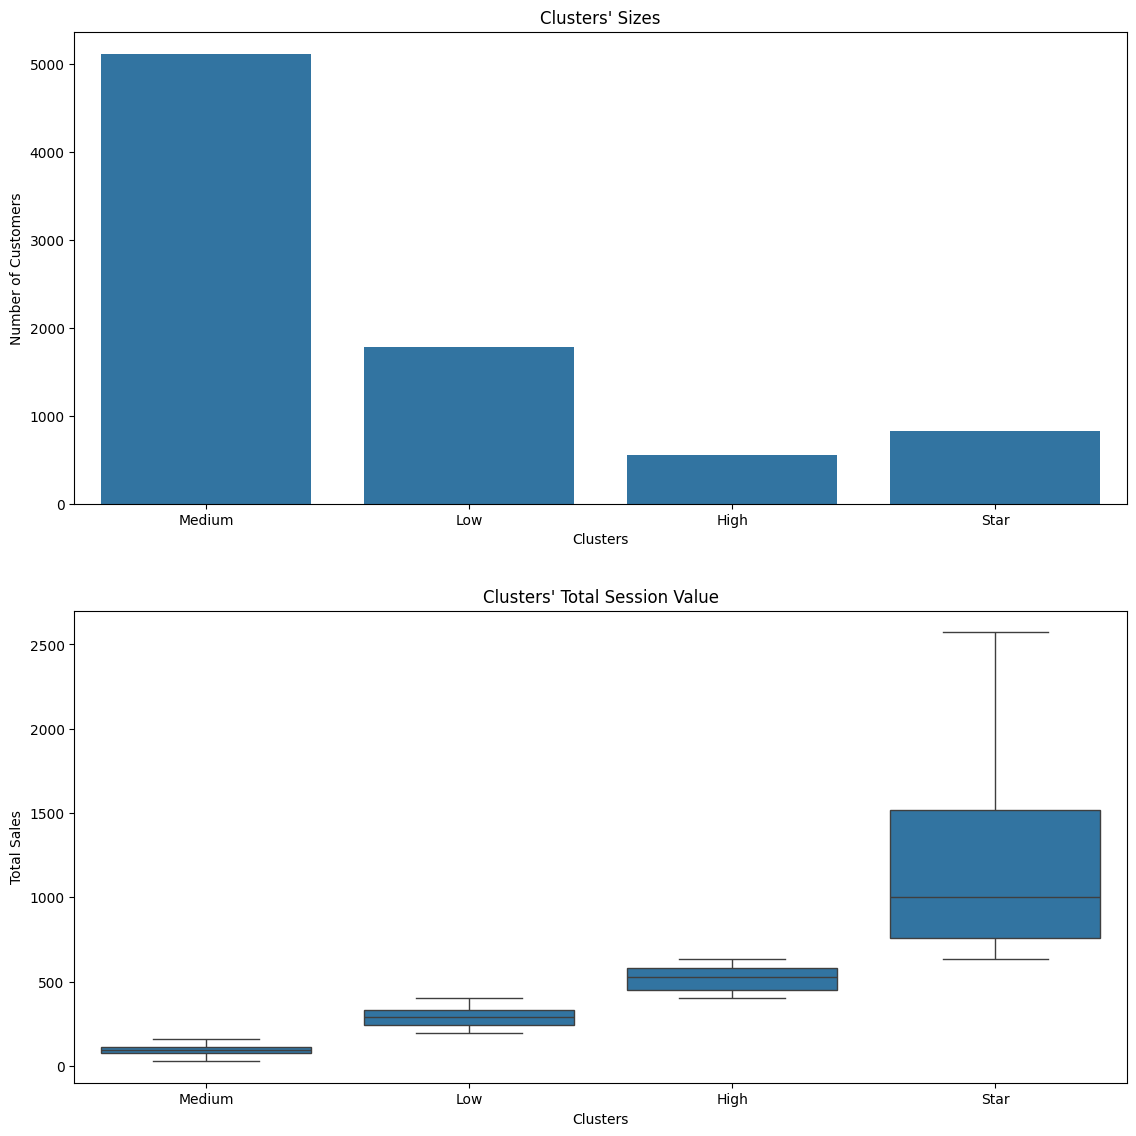

In [85]:
X=regular_customers['total_sales'].values.reshape(-1,1)
regular_customers['cluster']=Clustering_KMeans=KMeans(n_clusters=3,random_state=15).fit_predict(X)

#merging clusters
Customer_table=pd.merge(left=Customer_table,
                        right=regular_customers[['user_id','cluster']],
                        how='left',
                        left_on='user_id',
                        right_on='user_id')
Customer_table['cluster'].fillna(3,inplace=True)

#Plotting the clusters
print('Cluster Statistics')
print('-'*50)
print(Customer_table.groupby(by=['cluster'])['total_sales'].describe())

fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.countplot(x='cluster',data=Customer_table,ax=ax1)
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')
plt.title("Clusters' Sizes")
ax1.set_xticklabels(['Medium','Low','High','Star']);

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x='cluster',y='total_sales',data=Customer_table,ax=ax2,showfliers = False)
plt.xlabel('Clusters')
plt.ylabel('Total Sales')
plt.title("Clusters' Total Session Value")
fig.tight_layout(pad=3.0)
ax2.set_xticklabels(['Medium','Low','High','Star']);

The customers are grouped into 4 clusters based on their total session values:

**Cluster 0 (5,114 customers):**

- Low-value customers, average ~95.
- Most customers fall here, representing the largest segment.

**Cluster 1 (1,782 customers):**

- Medium-value customers, average ~290.
- Higher spending than Cluster 0 but still moderate.

**Cluster 2 (554 customers):**

- High-value customers, average ~519.
- Smaller segment with substantially higher purchases.

**Cluster 3 (828 customers):**

- Top customers, average ~1,520 with some extreme outliers up to 56,461.
- Key revenue drivers, though fewer in number, contributing disproportionately to total sales.

## 3.5.4 Customer Segmentation 

         n_sessions  n_events  n_views  n_adds  n_buys  total_value
cluster                                                            
0              2.00      7.32     1.45    2.50    1.78       868.41
1              1.14      1.65     0.86    0.50    0.07        55.81
2              5.06     44.55     8.81   15.29    4.47     13341.01
3              5.69     15.10     7.72    3.13    0.91      1063.67


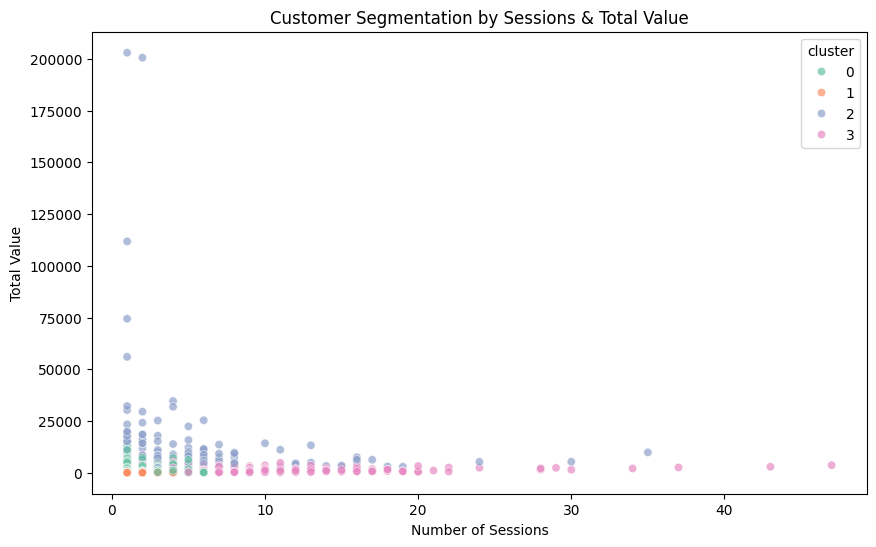

In [86]:


user_stats = train.groupby('user_id').agg(
    n_sessions=('user_session', 'nunique'),
    n_events=('event_type', 'count'),
    n_views=('event_type', lambda x: (x=='VIEW').sum()),
    n_adds=('event_type', lambda x: (x=='ADD_CART').sum()),
    n_buys=('event_type', lambda x: (x=='BUY').sum()),
    total_value=('session_value', 'sum')
).reset_index()


features = ['n_sessions', 'n_events', 'n_views', 'n_adds', 'n_buys', 'total_value']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_stats[features])


kmeans = KMeans(n_clusters=4, random_state=42)
user_stats['cluster'] = kmeans.fit_predict(X_scaled)


cluster_summary = user_stats.groupby('cluster')[features].mean().round(2)
print(cluster_summary)


plt.figure(figsize=(10,6))
sns.scatterplot(
    data=user_stats, 
    x='n_sessions', 
    y='total_value', 
    hue='cluster', 
    palette='Set2', alpha=0.7
)
plt.title("Customer Segmentation by Sessions & Total Value")
plt.xlabel("Number of Sessions")
plt.ylabel("Total Value")
plt.show()


**Cluster 0: Moderate Shoppers**

* **\~2 sessions** on average.
* Around **7 events** (few interactions).
* **1.8 purchases** and **2.5 add-to-carts** → relatively high conversion.
* Spend about **868 value units** total.
👉 These are **occasional but effective buyers** who don’t browse much but convert well.



 **Cluster 1: Browsers / Low-value Users**

* Only **1 session** (almost one-time visitors).
* Very few events (\~1.6), mostly **views**.
* **Almost no purchases (0.07)**.
* Very low spend (**56 value units**).
👉 These are **window shoppers** or casual visitors — they rarely buy.


**Cluster 2: High-value Loyal Customers**

* **\~5 sessions** and **45 events** (very engaged).
* Many interactions: **15 adds-to-cart, 4.5 purchases**.
* Spend is huge: **13,341 value units** on average!
👉 These are your **loyal power-users** — high engagement + high spending.



**Cluster 3: Heavy Browsers with Low Conversion**

* **6 sessions** and **15 events**.
* Many views (**7.7**) but only **0.9 purchases**.
* Spend is moderate (**1,063 value units**).
👉 These users browse a lot, return often, but **rarely convert** → potential churn or frustration.

-------

* **Cluster 2 (High-value)** → Retain with loyalty programs.
* **Cluster 0 (Moderate)** → Can be nurtured into high-value.
* **Cluster 1 (Low-value)** → Marketing efforts might not pay off.
* **Cluster 3 (Heavy Browsers)** → Need conversion optimization (better offers, trust signals).




## 3.5.5 RFM

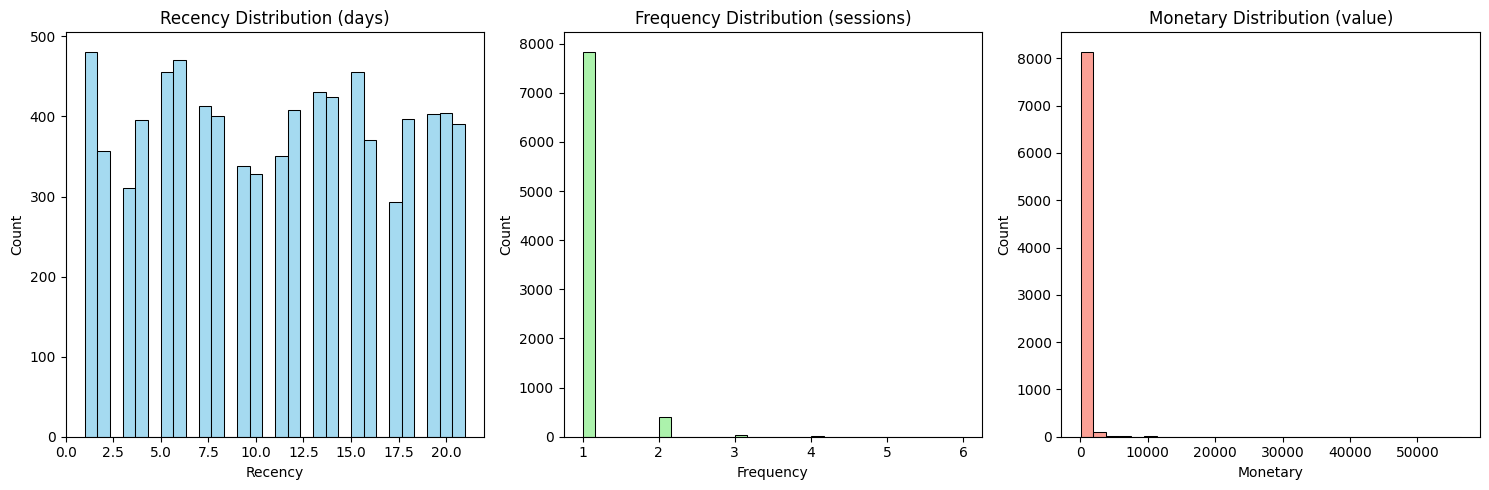

           n_users    Recency  Frequency    Monetary
RFM_Score                                           
114            653   3.689127   1.278714  911.086968
113            629   3.643879   1.128776  201.671431
111            621   3.304348   1.000000   69.981369
112            567   3.622575   1.000000  101.307178
312            546  13.917582   1.000000  100.363736
311            543  14.110497   1.000000   69.451234
412            515  19.093204   1.000000  101.105107
313            513  13.970760   1.050682  200.700175
314            488  13.899590   1.110656  862.005451
214            475   8.898947   1.168421  908.174800


In [87]:


# We only care about purchase events for RFM
purchases = train[train['event_type'] == 'BUY'].copy()

# Snapshot date = last date in dataset
snapshot_date = purchases['event_time'].max() + pd.Timedelta(days=1)

# Aggregate RFM per user
rfm = purchases.groupby('user_id').agg({
    'event_time': lambda x: (snapshot_date - x.max()).days,  # Recency
    'user_session': 'nunique',                              # Frequency (sessions with purchases)
    'session_value': 'sum'                                  # Monetary (total spent)
}).reset_index()

# Rename columns
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']


# Recency (lower is better)
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=False, duplicates="drop") + 1

# Frequency (higher is better)
rfm['F_quartile'] = pd.qcut(rfm['Frequency'], 4, labels=False, duplicates="drop") + 1

# Monetary (higher is better)
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=False, duplicates="drop") + 1

# Combine into RFM score
rfm['RFM_Score'] = (
    rfm['R_quartile'].astype(str) +
    rfm['F_quartile'].astype(str) +
    rfm['M_quartile'].astype(str)
)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30, kde=False, color="skyblue")
plt.title("Recency Distribution (days)")

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30, kde=False, color="lightgreen")
plt.title("Frequency Distribution (sessions)")

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30, kde=False, color="salmon")
plt.title("Monetary Distribution (value)")

plt.tight_layout()
plt.show()


segment_summary = rfm.groupby('RFM_Score').agg({
    'user_id':'count',
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean'
}).rename(columns={'user_id':'n_users'}).sort_values('n_users', ascending=False)

print(segment_summary.head(10))


## Interpretion of result:
**114 (653 users, Recency≈3.7, Frequency≈1.3, Monetary≈911)**

Recently active, not frequent buyers, but when they do buy, they spend a lot.

These are “Big Ticket, Recent Buyers” : great segment to nurture for loyalty.

**113 (629 users, Monetary≈202)**

Recent, low frequency, low monetary.

“New or Light Buyers”: they tried buying recently but are low spenders. Could be nurtured with upsell/cross-sell.

**111 (621 users, Monetary≈70)**

Very recent but lowest frequency and spend.

“Trial Users”: possibly first-time customers, low engagement.

**112 (567 users, Monetary≈101)**

Similar to above, slight improvement in monetary.

“Recent Small Buyers”.

**312 (546 users, Recency≈14, Monetary≈100)**

Long ago buyers, low frequency, small spending.

“At Risk / Hibernating” : unlikely to return without strong re-engagement.

**411 (not in your sample, but would mean Recency=4, Frequency=1, Monetary=1)**

Would represent “Lost Customers”.

**314 (488 users, Recency≈13.9, Frequency≈1.1, Monetary≈862)**

Haven’t bought recently, low frequency, but very high monetary when active.

“High-Value At Risk”: critical to target with win-back campaigns.

**214 (475 users, Recency≈8.9, Frequency≈1.17, Monetary≈908)**

Medium recency, low frequency, very high spenders.

“Occasional Big Spenders”: they return sometimes and drop large purchases.

## 3.5.6 Churn / Retention Analysis

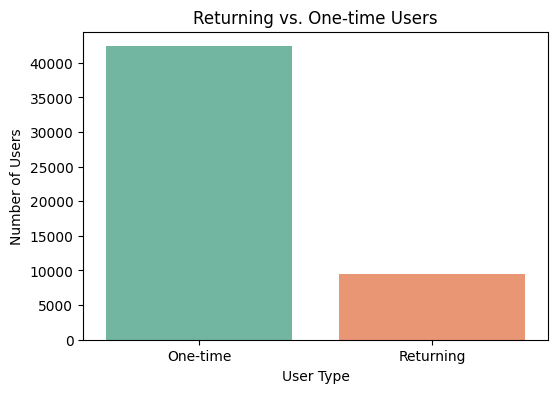

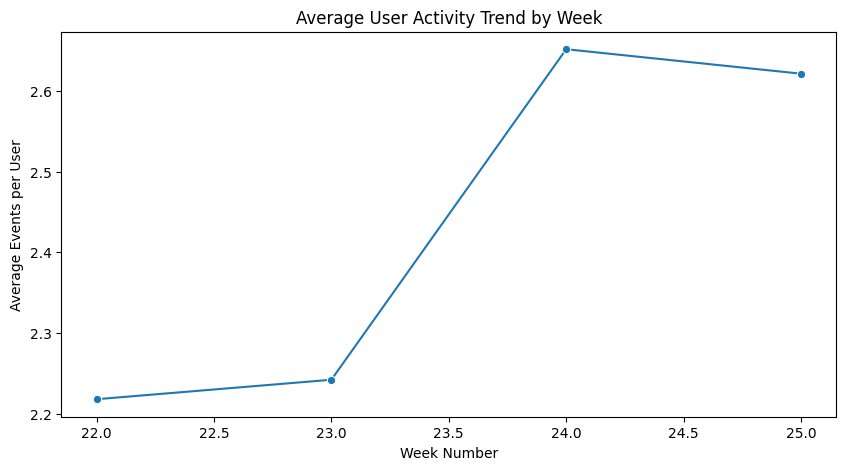

Declining activity users (%):
decline_flag
0    95.80286
1     4.19714
Name: proportion, dtype: float64


In [88]:

# Returning vs. One-time Users

user_sessions = train.groupby('user_id')['user_session'].nunique().reset_index(name='n_sessions')
user_sessions['user_type'] = user_sessions['n_sessions'].apply(lambda x: 'Returning' if x > 1 else 'One-time')

# Plot distribution
plt.figure(figsize=(6,4))
sns.countplot(x='user_type', data=user_sessions, palette='Set2')
plt.title('Returning vs. One-time Users')
plt.xlabel('User Type')
plt.ylabel('Number of Users')
plt.show()



# Churn / Declining Activity Analysis (Weekly)
# Convert event_time to week of the month
train['week'] = train['event_time'].dt.isocalendar().week

# Count events per user per week
user_activity = train.groupby(['user_id','week']).size().reset_index(name='n_events')

# Average weekly activity trend
activity_trend = user_activity.groupby('week')['n_events'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='week', y='n_events', data=activity_trend, marker='o')
plt.title('Average User Activity Trend by Week')
plt.xlabel('Week Number')
plt.ylabel('Average Events per User')
plt.xticks(rotation=0)
plt.show()

# Flag users with declining activity week-over-week
user_activity['prev_events'] = user_activity.groupby('user_id')['n_events'].shift(1)
user_activity['decline_flag'] = (user_activity['n_events'] < user_activity['prev_events']).astype(int)

declining_users = user_activity.groupby('user_id')['decline_flag'].max().reset_index()
declining_users_summary = declining_users['decline_flag'].value_counts(normalize=True) * 100

print("Declining activity users (%):")
print(declining_users_summary)


**User Types:**

The first graph shows the distribution of user types:

One-time users: ~40,000

Returning users: ~10,000

**Weekly Activity Trend:**

Week 22: Average 2.2 events per user

Week 23: Activity increases

Week 24: Peaks at 2.4 events

Week 25: Slight decrease

**Declining Activity Users:**

Users showing a week-over-week decline: ~4.2%

Users without decline: ~95.8%

Despite a small drop in week 25, most users maintain or increase their activity. Monitoring these trends helps identify potential churn and target retention campaigns.

## 3.5.7 Behavior Path Analysis

              event_sequence  count
0                       VIEW  30145
1                   ADD_CART  11792
2                REMOVE_CART   2819
3                VIEW → VIEW   2423
4                        BUY   2155
5        ADD_CART → ADD_CART   1978
6            ADD_CART → VIEW   1961
7     ADD_CART → REMOVE_CART    774
8  REMOVE_CART → REMOVE_CART    713
9         VIEW → REMOVE_CART    687


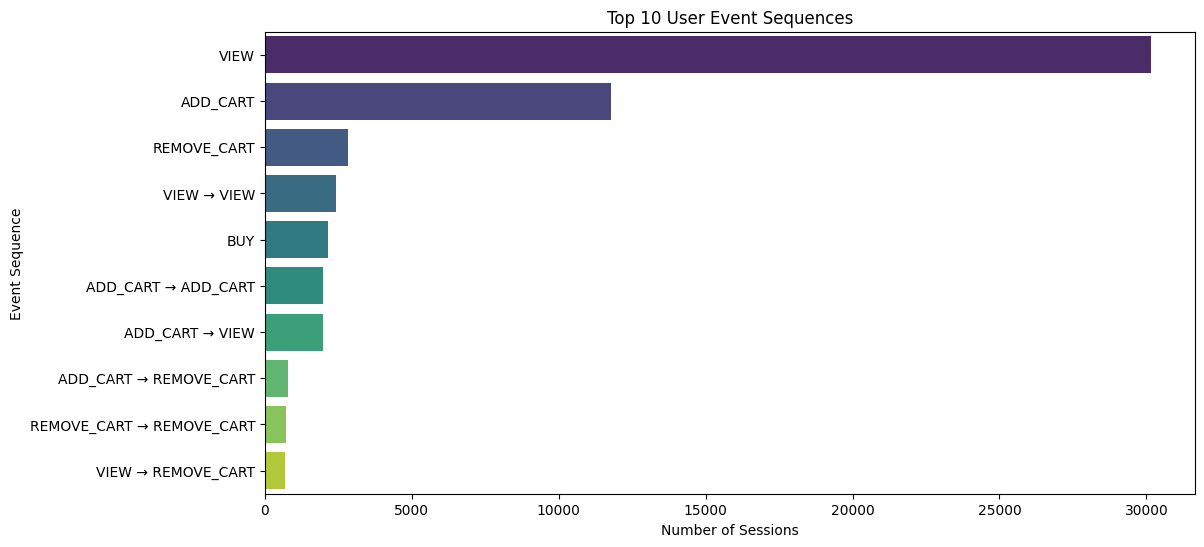

In [89]:
# Build event sequences per user session
session_paths = (
    train.groupby('user_session')['event_type']
    .apply(lambda x: ' → '.join(x))
    .reset_index(name='event_sequence')
)

# Count frequency of each unique path
path_counts = session_paths['event_sequence'].value_counts().reset_index()
path_counts.columns = ['event_sequence', 'count']

# Show top 10 most common paths
top_paths = path_counts.head(10)
print(top_paths)

# Optional: visualize top paths
plt.figure(figsize=(12,6))
sns.barplot(y='event_sequence', x='count', data=top_paths, palette='viridis')
plt.title('Top 10 User Event Sequences')
plt.xlabel('Number of Sessions')
plt.ylabel('Event Sequence')
plt.show()


Most sessions consist of a single action, predominantly views or add-to-cart events.

Multi-step sequences are less frequent, indicating that many users leave after one or two interactions.

ADD_CART → REMOVE_CART and VIEW → REMOVE_CART sequences highlight cart abandonment behaviour, which can be investigated further.

The BUY event appears relatively infrequently, suggesting opportunities to optimise conversion from add-to-cart to purchase.

## 3.5.8 Cohort Analysis

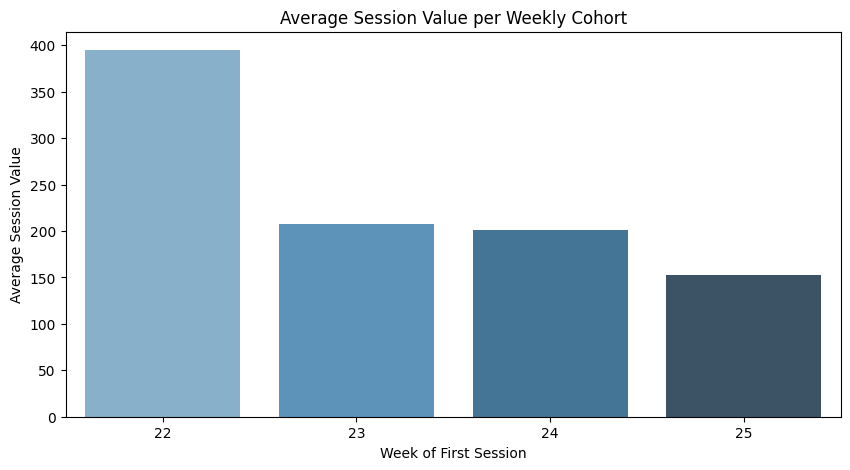

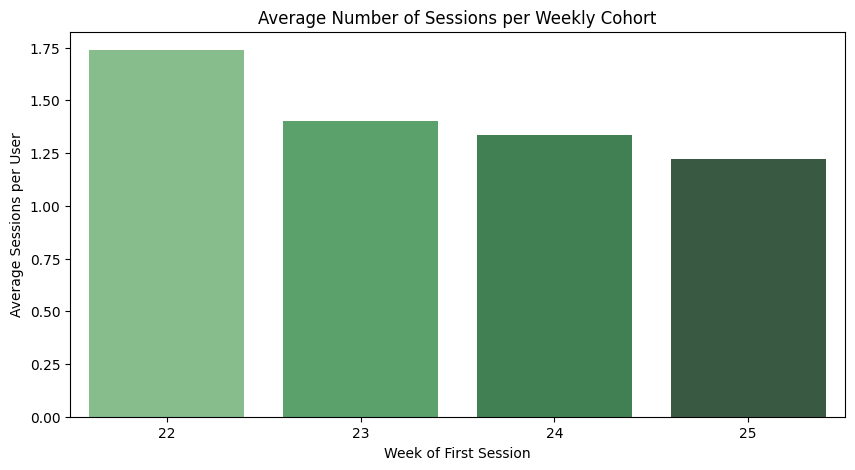

In [90]:
# Create a cohort based on the first session date within the month
train['first_session_date'] = train.groupby('user_id')['event_time'].transform('min').dt.date

# Count total sessions and total value per user
user_summary = train.groupby('user_id').agg(
    n_sessions=('user_session', 'nunique'),
    total_value=('session_value', 'sum'),
).reset_index()

# Assign "cohorts" based on first week of the month
train['first_week'] = train['first_session_date'].apply(lambda d: pd.Timestamp(d).week)

user_summary = user_summary.merge(
    train[['user_id','first_week']].drop_duplicates(),
    on='user_id',
    how='left'
)

# Analyze average session value and sessions per cohort (week)
cohort_analysis = user_summary.groupby('first_week').agg(
    avg_session_value=('total_value','mean'),
    avg_sessions_per_user=('n_sessions','mean')
).reset_index()

# Visualize
plt.figure(figsize=(10,5))
sns.barplot(data=cohort_analysis, x='first_week', y='avg_session_value', palette='Blues_d')
plt.title('Average Session Value per Weekly Cohort')
plt.xlabel('Week of First Session')
plt.ylabel('Average Session Value')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=cohort_analysis, x='first_week', y='avg_sessions_per_user', palette='Greens_d')
plt.title('Average Number of Sessions per Weekly Cohort')
plt.xlabel('Week of First Session')
plt.ylabel('Average Sessions per User')
plt.show()


Week 22 shows the highest engagement, with an average session value of 400 and 1.75 sessions per user.

Weeks 23 and 24 have lower engagement, averaging 200 per session and 1.25 sessions per user.

Week 25 shows a further decline, with 150 average session value and ~1.2 sessions per user.
This highlights that early-week users tend to spend more and visit more frequently, even within a single month.

# 3.6 Time Distribution Analysis

## 3.6.1 Visualization of Event distribution Across Hours of the Day

In [91]:
train['hour'] = train['event_time'].apply(lambda t: t.hour)
event_types = ["ADD_CART", "REMOVE_CART", "VIEW", "BUY"]

event_by_hour = {}
for event_type in event_types:
    event_count = train[train.event_type == event_type].groupby("hour")["event_type"].count()
    event_by_hour[event_type] = event_count

# Dict → DataFrame
event_count = pd.DataFrame(event_by_hour).fillna(0)

# Bar chart
fig = px.bar(
    event_count,
    x=event_count.index,        # saat
    y=event_types,              # kolonlar
    title="Distribution of Events by Hour",
    labels={"x": "Hour in a Day", "value": "Number of Events", "variable": "Event Type"},
    template="plotly_white"
)

fig.show()


In [92]:
# Event type percent by hour
for event_type in event_types:
    event_count[f'{event_type}_percent'] = (
        event_count[event_type] / event_count[event_type].sum()
    )

# Line plot
fig = px.line(
    event_count,
    x=event_count.index,
    y=[f'{event_type}_percent' for event_type in event_types],
    title="Percentage Distribution of Events by Hour",
    labels={"x": "Hour in a Day", "value": "Percentage", "variable": "Event Type"},
    template="plotly_white"
)

fig.show()


## 3.6.2 Temporal Distribution of User Events

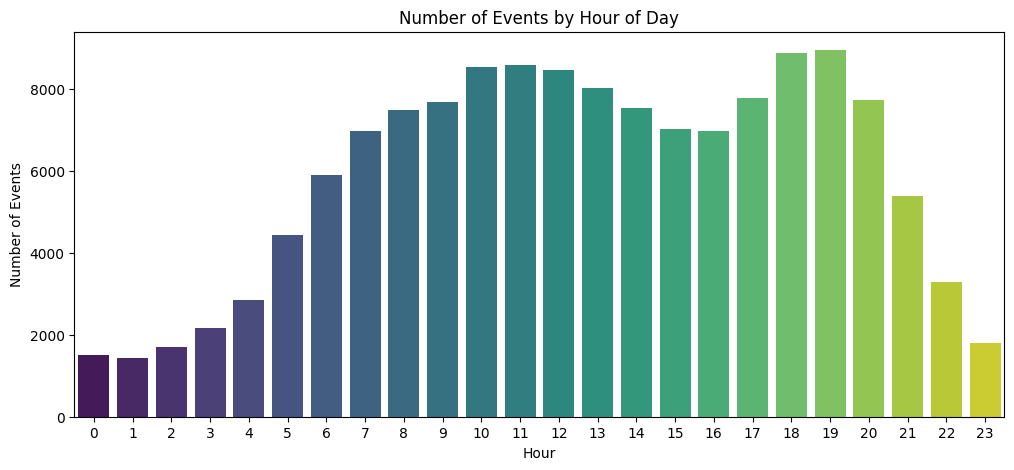

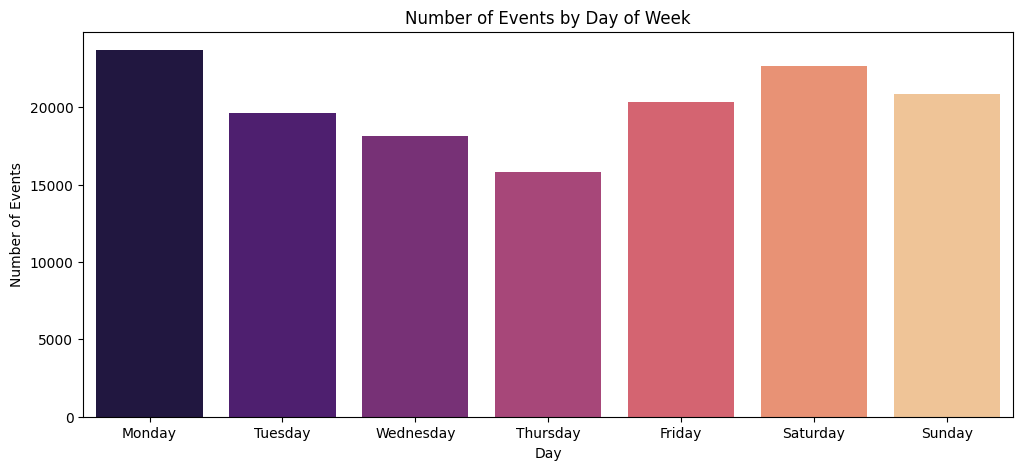

In [53]:
train['hour'] = train['event_time'].dt.hour
train['day_of_week'] = train['event_time'].dt.day_name()
train['month'] = train['event_time'].dt.month_name()


events_per_session = train.groupby('user_session').agg({
    'hour': 'first', 
    'day_of_week': 'first', 
    'event_type': 'count' 
}).reset_index().rename(columns={'event_type': 'event_count'})

plt.figure(figsize=(12,5))
sns.countplot(data=events_per_session, x='hour', palette='viridis')
plt.title('Number of Sessions by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Sessions')
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(
    data=events_per_session, 
    x='day_of_week', 
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], 
    palette='magma'
)
plt.title('Number of Sessions by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Sessions')
plt.show()



The first plot shows the "Number of Events by Hour of Day." We can observe that the highest number of events occurs between 18:00 and 19:00, while the fewest events happen at 0:00, 1:00, and 23:00. This indicates that user activity is concentrated in the evening hours.  

The second plot shows the "Number of Events by Day of Week." The highest activity is observed on Monday, while Thursday has the lowest number of events. This suggests that user engagement varies throughout the week, potentially influenced by workweek patterns and shopping behavior.


## 3.6.3 Hourly Analysis of User Behavior and Session Value

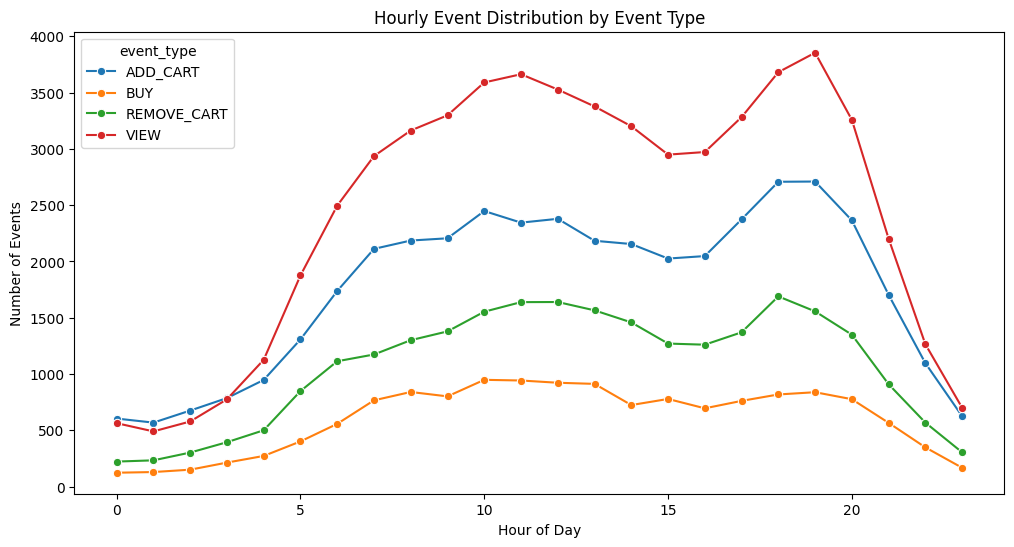

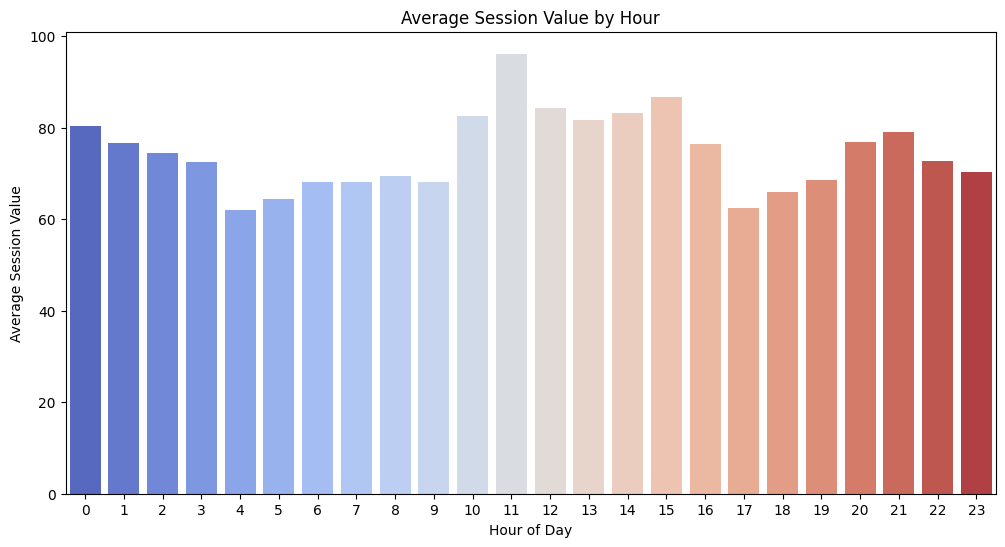

In [54]:
# Hourly event counts by type
hourly_events = train.groupby(['hour', 'event_type']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_events, x='hour', y='count', hue='event_type', marker='o')
plt.title('Hourly Event Distribution by Event Type')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.show()

# Average session value by hour
hourly_value = train.groupby('hour')['session_value'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=hourly_value, x='hour', y='session_value', palette='coolwarm')
plt.title('Average Session Value by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Session Value')
plt.show()

The first plot shows the relationship between event types and time of day. From the graph, we can see that the highest number of product views occurs around 11 AM and 8 PM. Similarly, most add-to-cart events happen around 8 PM. The peak purchase (`BUY`) times are between 10 AM and 3 PM. Additionally, the average session value clearly peaks around 11 AM. These patterns indicate distinct user behavior depending on the time of day, which could be useful for optimizing marketing campaigns, promotions, or website engagement strategies.


## 3.6.4 Session Time Differences vs. Session Value by Event Type

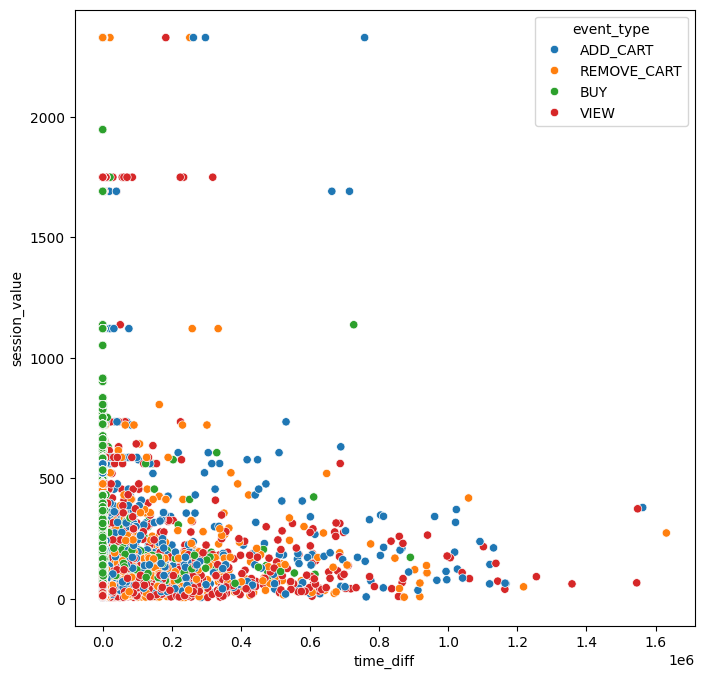

In [55]:
# Sort by session and event time
df_sorted = train.sort_values(['user_session', 'event_time']).copy()

# Compute time difference (seconds) between consecutive events in the same session
df_sorted['time_diff'] = df_sorted.groupby('user_session')['event_time'].diff().dt.total_seconds().fillna(0)

# Scatter plot
sns.scatterplot(
    x='time_diff', 
    y='session_value', 
    hue='event_type', 
    data=df_sorted
)
plt.show()


This plot shows the time intervals (`time_diff`) between consecutive events within each user session and their corresponding `session_value`. Points are colored by `event_type` to visualize how different actions relate to session value over time.


Looking at the plot, we can see that most purchase (`BUY`) events occur with a `time_diff` of 0 seconds, suggesting that users often complete purchases immediately after adding items to their cart. In contrast, other event types like `VIEW` or `ADD_CART` show more spread-out time distributions, indicating that users take more time to browse or consider items before taking action. This highlights differences in user behavior depending on event type and could inform session-based predictive modeling or targeted interventions to increase conversions.


# 3.7 Anomaly Detection Analysis

Anomaly detection in e-commerce data focuses on identifying unusual user behavior or data inconsistencies that could indicate errors, fraud, or interesting patterns. Key analyses include:


## 3.7.1 Unusual Session Lengths

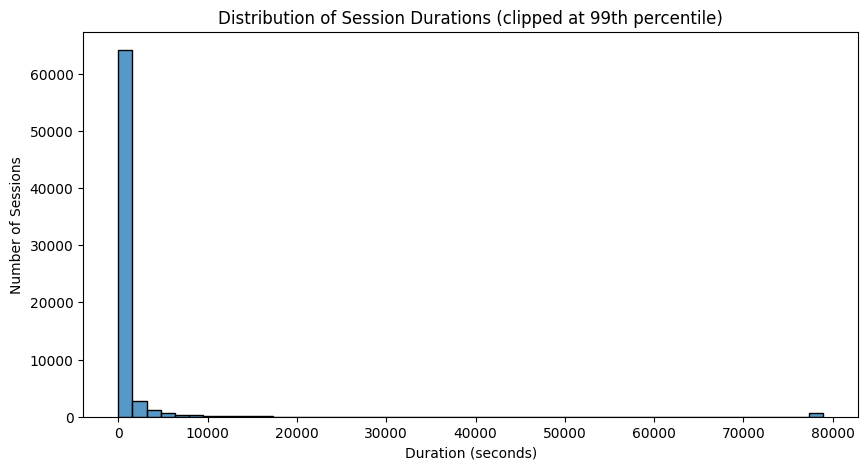

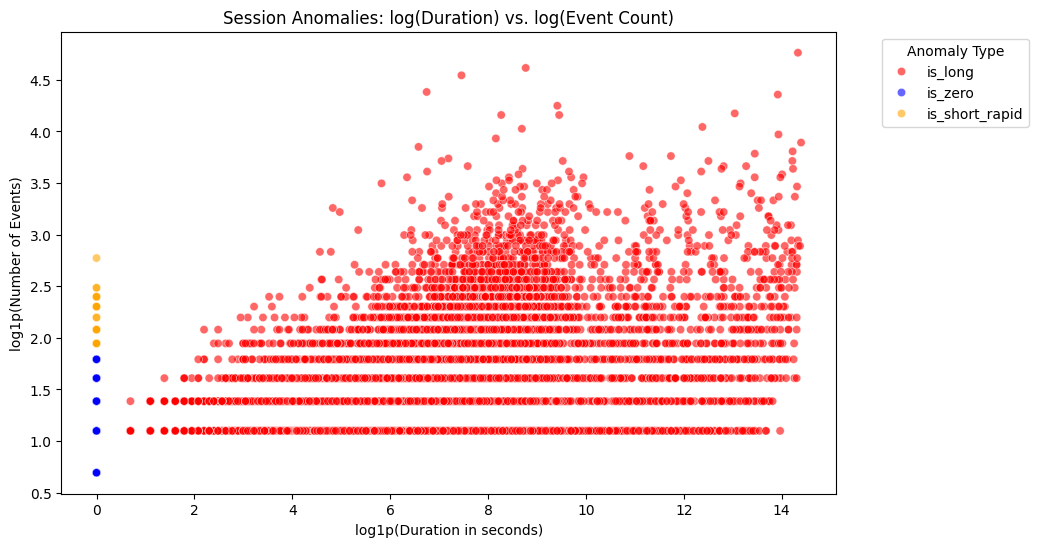

Total sessions: 70736
Long sessions (IQR): 14701
Short & rapid sessions: 30
Zero-duration sessions: 48067


In [56]:
#Session-level aggregation
session_stats = train.groupby('user_session').agg(
    user_id=('user_id','first'),
    n_events=('event_type','count'),
    start_time=('event_time','min'),
    end_time=('event_time','max')
).reset_index()

# Duration in seconds
session_stats['duration_s'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds()
session_stats['duration_s'] = session_stats['duration_s'].clip(lower=0)

# Detect anomalies
# Long sessions: IQR rule
q1 = session_stats['duration_s'].quantile(0.25)
q3 = session_stats['duration_s'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

session_stats['is_long'] = session_stats['duration_s'] > upper_bound

# Short but many events
threshold = session_stats['n_events'].quantile(0.95)
session_stats['is_short_rapid'] = (session_stats['duration_s'] <= 1) & (session_stats['n_events'] >= threshold)

# Zero-duration
session_stats['is_zero'] = session_stats['duration_s'] == 0

#Visualizations ---
plt.figure(figsize=(10,5))
sns.histplot(session_stats['duration_s'].clip(upper=session_stats['duration_s'].quantile(0.99)), bins=50, kde=False)
plt.title("Distribution of Session Durations (clipped at 99th percentile)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Sessions")
plt.show()

# Scatterplot duration vs. events
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=session_stats,
    x=np.log1p(session_stats['duration_s']),
    y=np.log1p(session_stats['n_events']),
    hue=session_stats[['is_long','is_short_rapid','is_zero']].idxmax(axis=1), # pick anomaly label
    palette={'is_long':'red','is_short_rapid':'orange','is_zero':'blue'},
    alpha=0.6
)
plt.title("Session Anomalies: log(Duration) vs. log(Event Count)")
plt.xlabel("log1p(Duration in seconds)")
plt.ylabel("log1p(Number of Events)")
plt.legend(title="Anomaly Type", bbox_to_anchor=(1.05,1))
plt.show()

# Summary 
print("Total sessions:", len(session_stats))
print("Long sessions (IQR):", session_stats['is_long'].sum())
print("Short & rapid sessions:", session_stats['is_short_rapid'].sum())
print("Zero-duration sessions:", session_stats['is_zero'].sum())


Total sessions: 70,736
→ This is the full population of user sessions in the dataset.

Long sessions (IQR rule): 14,701 (~21%)
→ A significant portion of sessions last much longer than expected.
Could be:
Abandoned browser tabs left open

Logging artifacts where the end time was not recorded properly

Real long browsing behavior (rare, but possible)

Short & rapid sessions: 30 (~0.04%)
→ Very short sessions (≤ 1 second) with unusually high event counts.
 These look like bot or automated activity (impossible for a human).

Zero-duration sessions: 48,067 (~68%)
→ Most sessions start and end at the same timestamp.
 Likely a data quality issue: timestamps may be truncated or only recorded once per session.

## 3.7.2 High Activity Users (Bots / Fraud)

Total users: 51821
Users with > 100 events: 6


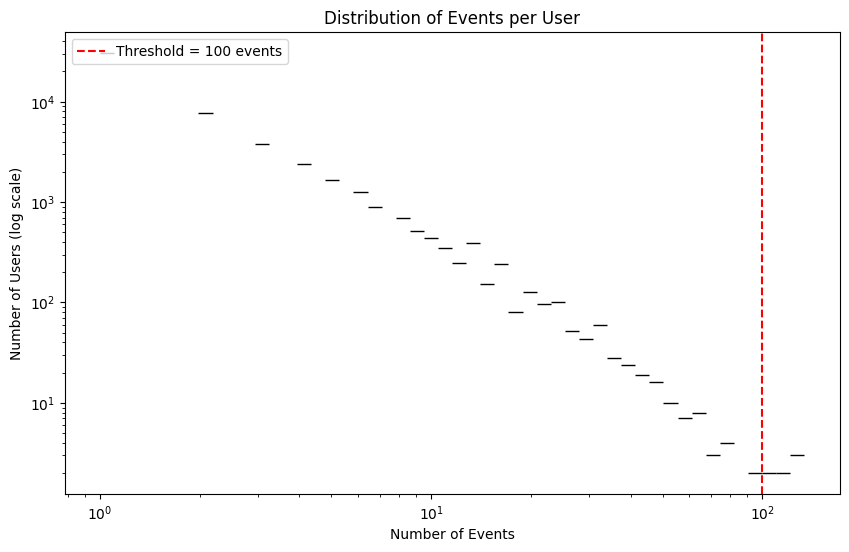

user_id  n_events
13075  USER_026471       134
14924  USER_030306       132
22665  USER_046288       123
15800  USER_032174       119
2640   USER_005285       116
39818  USER_078681       106

In [57]:
# count total events per user
user_event_counts = train.groupby('user_id')['event_type'].count().reset_index(name='n_events')

# Define threshold for anomaly
threshold = 100
high_activity_users = user_event_counts[user_event_counts['n_events'] > threshold]

print(f"Total users: {user_event_counts.shape[0]}")
print(f"Users with > {threshold} events: {high_activity_users.shape[0]}")

# Visualize distribution of user event counts
plt.figure(figsize=(10,6))
sns.histplot(user_event_counts['n_events'], bins=50, log_scale=(True, True), color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold} events')
plt.title("Distribution of Events per User")
plt.xlabel("Number of Events")
plt.ylabel("Number of Users (log scale)")
plt.legend()
plt.show()

# Show suspicious users
high_activity_users.sort_values('n_events', ascending=False).head(10)


Out of 51,821 users, only 6 users exceed 100 events.

These users are extreme outliers compared to the overall distribution of user activity.

Likely candidates for bots or fraudulent behavior, since normal users rarely perform so many actions in the same dataset.

## 3.7.3 Purchase without View or Add-to-Cart

Purchases without prior VIEW or ADD_CART: 12859


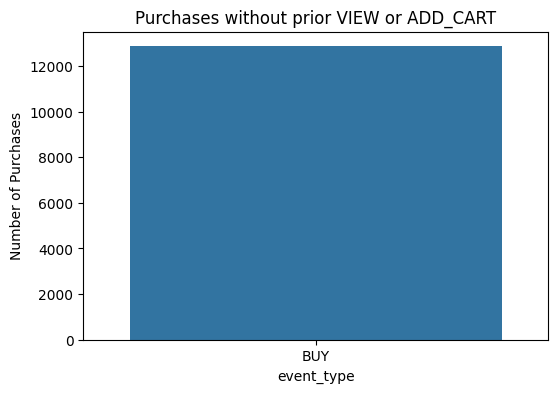

In [58]:
# Filter events
add_cart = train[train['event_type'] == 'ADD_CART']
view = train[train['event_type'] == 'VIEW']
buy = train[train['event_type'] == 'BUY']

# Create sets of viewed and added products per user
viewed_products = set(zip(view['user_id'], view['product_id']))
added_products = set(zip(add_cart['user_id'], add_cart['product_id']))

# Identify purchases without prior view or add-to-cart
buy_without_view_add = buy[~buy.apply(lambda x: (x['user_id'], x['product_id']) in viewed_products.union(added_products), axis=1)]

# Number of suspicious purchases
print(f"Purchases without prior VIEW or ADD_CART: {buy_without_view_add.shape[0]}")

# Visualize
plt.figure(figsize=(6,4))
sns.countplot(x='event_type', data=buy_without_view_add)
plt.title('Purchases without prior VIEW or ADD_CART')
plt.ylabel('Number of Purchases')
plt.show()


Number of purchases without prior VIEW or ADD_CART: 12,859

This indicates that ~12.8k purchases happened without users first viewing or adding the product to their cart.

Possible reasons: logging errors, UX issues, or suspicious/fraudulent activity.

## 3.7.4 Remove from Cart without Add

Number of REMOVE_CART events without prior ADD_CART: 23719


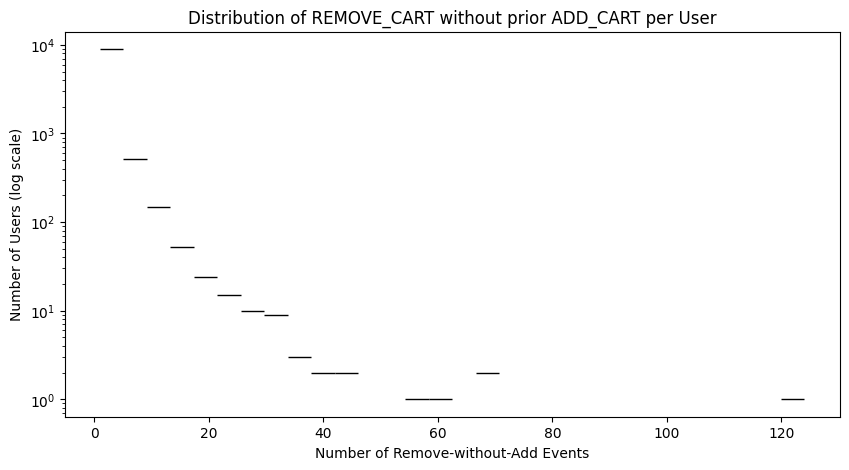

In [59]:
# Identify remove-cart events without prior add-cart
add_cart = train[train['event_type'] == 'ADD_CART']
remove_cart = train[train['event_type'] == 'REMOVE_CART']

added_products = set(zip(add_cart['user_id'], add_cart['product_id']))

remove_without_add = remove_cart[~remove_cart.apply(lambda x: (x['user_id'], x['product_id']) in added_products, axis=1)]
print(f"Number of REMOVE_CART events without prior ADD_CART: {remove_without_add.shape[0]}")
# Count per user
remove_user_counts = remove_without_add['user_id'].value_counts().reset_index()
remove_user_counts.columns = ['user_id', 'remove_without_add_count']

plt.figure(figsize=(10,5))
sns.histplot(remove_user_counts['remove_without_add_count'], bins=30, log_scale=(False, True))
plt.title('Distribution of REMOVE_CART without prior ADD_CART per User')
plt.xlabel('Number of Remove-without-Add Events')
plt.ylabel('Number of Users (log scale)')
plt.show()


Observation: 23,719 REMOVE_CART events were recorded without a prior ADD_CART.

Implication: This could indicate data inconsistencies, UX issues, or unusual user behaviour.

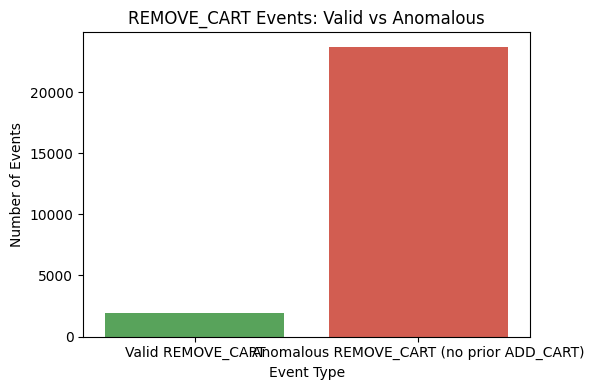

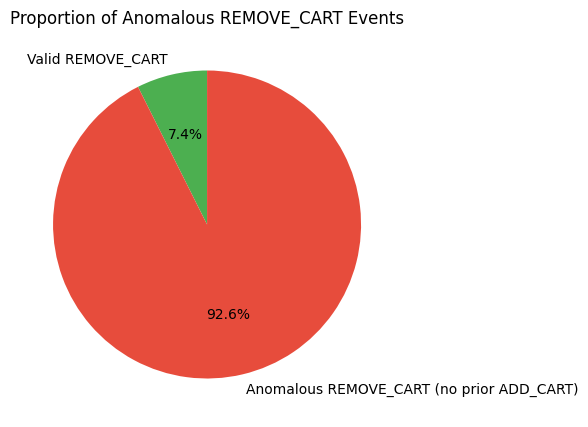

In [60]:
# Count normal vs anomalous remove events
remove_counts = pd.Series({
    "Valid REMOVE_CART": len(remove_cart) - len(remove_without_add),
    "Anomalous REMOVE_CART (no prior ADD_CART)": len(remove_without_add)
})

# Bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=remove_counts.index, y=remove_counts.values, palette=["#4CAF50","#E74C3C"])
plt.title("REMOVE_CART Events: Valid vs Anomalous")
plt.ylabel("Number of Events")
plt.xlabel("Event Type")
plt.tight_layout()
plt.show()

# Optional: Pie chart for proportions
plt.figure(figsize=(5,5))
plt.pie(remove_counts.values, labels=remove_counts.index, autopct="%1.1f%%", colors=["#4CAF50","#E74C3C"], startangle=90)
plt.title("Proportion of Anomalous REMOVE_CART Events")
plt.show()


## 3.7.5 Unusual Category/Product Mix

Number of unusual products: 8


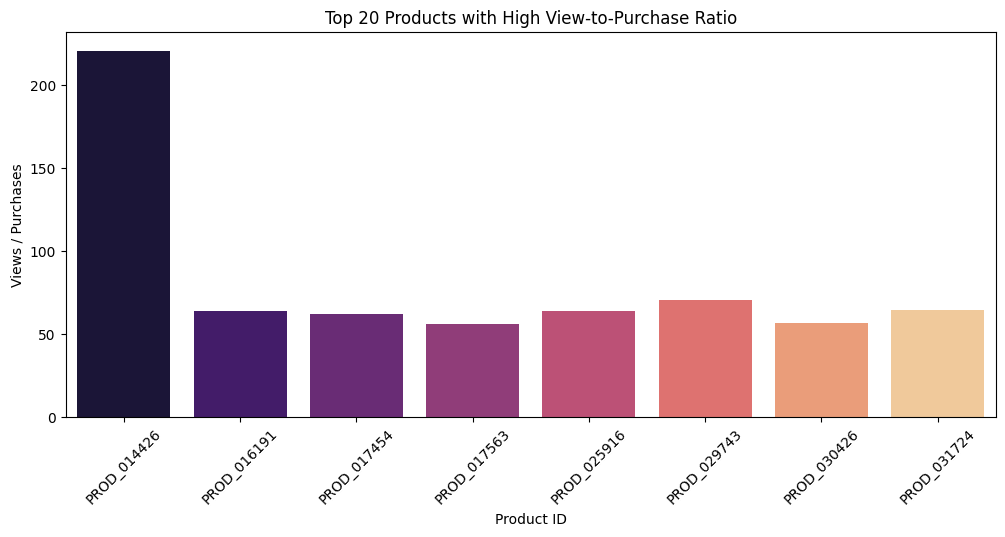

In [66]:

# Aggregate product-level stats
product_stats = train.groupby('product_id')['event_type'].value_counts().unstack(fill_value=0)

# Compute ratios: views vs purchases
product_stats['view_to_buy_ratio'] = product_stats.get('VIEW', 0) / (product_stats.get('BUY', 0) + 1)  # +1 to avoid division by zero

# Identify unusual products
unusual_products = product_stats[product_stats['view_to_buy_ratio'] > 50]  # threshold can be adjusted
print(f"Number of unusual products: {unusual_products.shape[0]}")

# Visualize top 20 products by extreme ratio
plt.figure(figsize=(12,5))
sns.barplot(
    x=unusual_products.index, 
    y=unusual_products['view_to_buy_ratio'].values, 
    palette='magma'
)
plt.xticks(rotation=45)
plt.title('Top 20 Products with High View-to-Purchase Ratio')
plt.ylabel('Views / Purchases')
plt.xlabel('Product ID')
plt.show()



We analysed the relationship between product views and purchases to detect user behaviour or performance anomalies.

- Products viewed frequently but rarely purchased (or vice versa) are considered unusual.

-  There are 8 products in the dataset that exhibit this unusual behaviour.

These products may indicate potential issues such as poor pricing, lack of trust, misalignment with customer preferences, or data logging inconsistencies.

## 3.7.6 Sudden Spikes in Activity

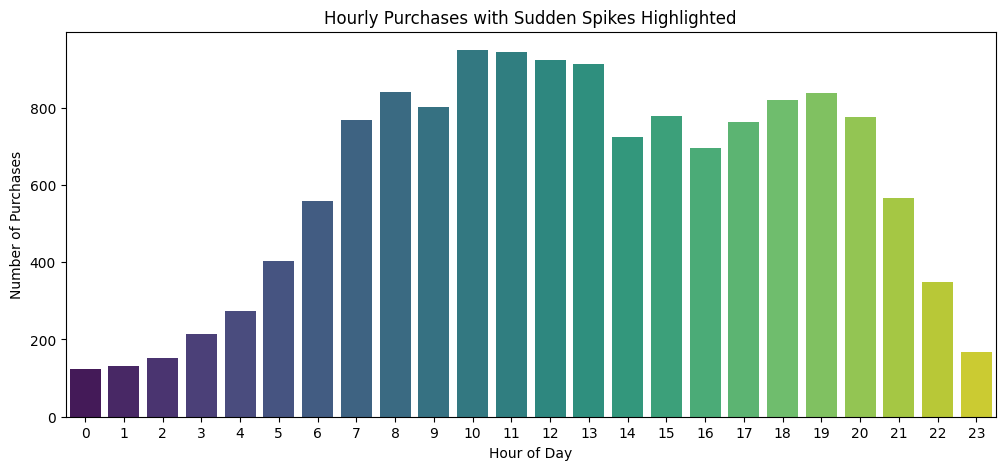

In [62]:
# Aggregate purchases by hour
purchases_by_hour = train[train['event_type']=='BUY'].groupby('hour').size().reset_index(name='n_purchases')

# Compute mean and threshold for spike detection (e.g., 3x mean)
mean_purchases = purchases_by_hour['n_purchases'].mean()
spike_threshold = mean_purchases * 3

# Flag spikes
purchases_by_hour['spike_flag'] = purchases_by_hour['n_purchases'] > spike_threshold

# Visualization
plt.figure(figsize=(12,5))
sns.barplot(x='hour', y='n_purchases', data=purchases_by_hour, palette='viridis')
for idx, row in purchases_by_hour.iterrows():
    if row['spike_flag']:
        plt.text(row.name, row['n_purchases']+5, '⚠️', ha='center', va='bottom', fontsize=14)
plt.title('Hourly Purchases with Sudden Spikes Highlighted')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Purchases')
plt.show()



Hours 10, 11, and 12 show the highest number of purchases, approximately 800, indicating peak activity.

Hours 0, 1, 2, 3, 23 have the lowest purchase counts, less than 200, suggesting minimal activity.


The sudden spikes in activity could be caused by several factors:

Flash sales or promotions: During special discounts or marketing campaigns, many users may purchase at the same time, causing a natural spike in purchases.

Automated activity (bots): If automated scripts are interacting with the site (e.g., testing, scraping, or fraudulent purchases), this can artificially inflate event counts in a short period.

Logging issues or duplicate records: Sometimes spikes are not real user behaviour but errors in the data collection process, such as repeated logging of the same event or system glitches.

## 3.7.7 Suspicious Session Value


Total suspicious sessions: 238


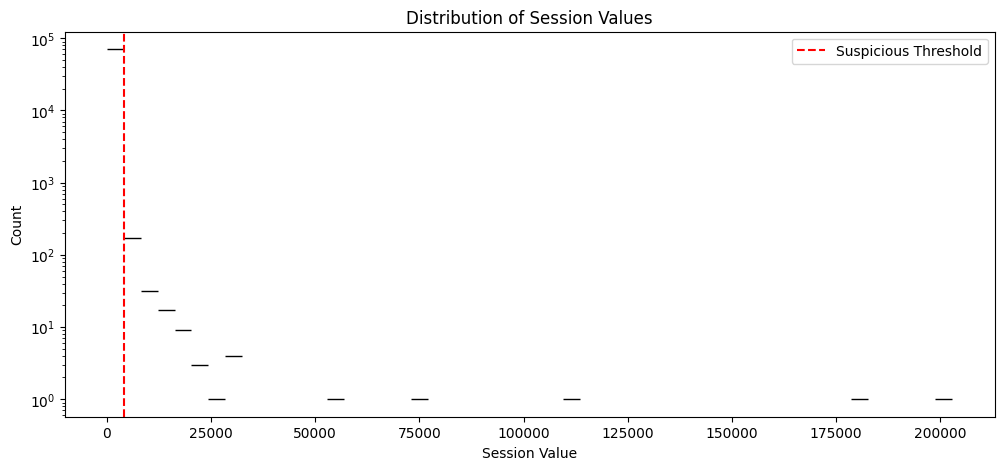

In [63]:


# Aggregate session value per session
session_values = train.groupby('user_session')['session_value'].sum().reset_index()

# Define threshold for suspiciously high session value
threshold = session_values['session_value'].mean() + 3 * session_values['session_value'].std()
suspicious_sessions = session_values[session_values['session_value'] > threshold]

print(f"Total suspicious sessions: {len(suspicious_sessions)}")

# Visualize session values
plt.figure(figsize=(12,5))
sns.histplot(session_values['session_value'], bins=50, log_scale=(False, True), color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label='Suspicious Threshold')
plt.title('Distribution of Session Values')
plt.xlabel('Session Value')
plt.ylabel('Count')
plt.legend()
plt.show()


The histogram above shows the distribution of all session values, with the red line marking the threshold for suspicious sessions.

We identified 238 sessions with unusually high session_value, far above the typical range. These sessions could indicate test transactions, data errors, or potential fraudulent activity. By flagging these outliers, we can investigate them further and ensure more reliable analytics and modelling.


## 3.7.8 Event Order Anomalies

Number of sessions with event order anomalies: 3822


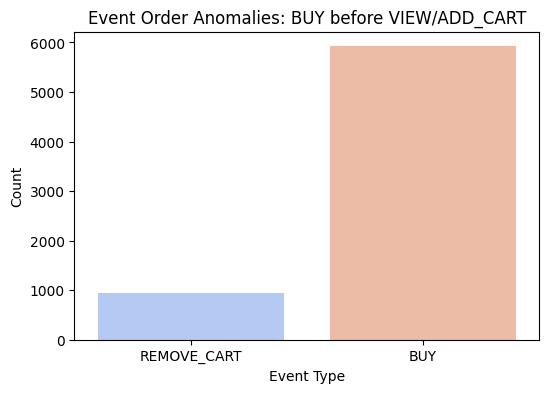

In [64]:
#Find sessions where BUY happens before any VIEW or ADD_CART
buy_first_sessions = train.groupby('user_session').filter(
    lambda x: (x['event_type'].eq('BUY') & ~x['event_type'].isin(['VIEW','ADD_CART']).cummax()).any()
)

print(f"Number of sessions with event order anomalies: {buy_first_sessions['user_session'].nunique()}")

plt.figure(figsize=(6,4))
sns.countplot(x='event_type', data=buy_first_sessions, palette='coolwarm')
plt.title('Event Order Anomalies: BUY before VIEW/ADD_CART')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


We identified 3,822 sessions where the sequence of events did not follow the expected logical flow.

BUY before VIEW/ADD_CART (≈6,000 events):
Purchases occurring without prior product views or add-to-cart actions. This may indicate logging issues, bot-like activity, or test transactions.

REMOVE_CART without prior ADD_CART (≈1,000 events):
Users are removing products they never added. This suggests inconsistencies in event tracking or possible data corruption.

Total users: 51821
Users with churn anomalies (stopped before last week): 37563


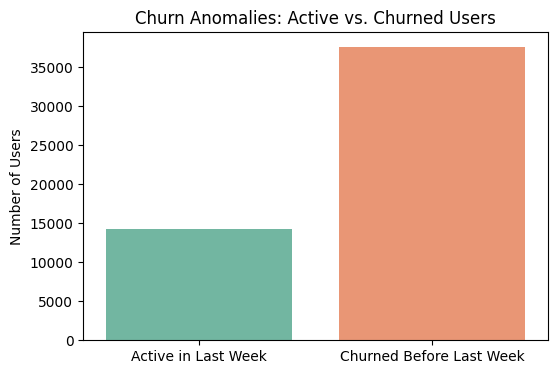

In [65]:
# Count activity per user per week
user_week_activity = (
    train.groupby(['user_id', 'week'])
    .size()
    .reset_index(name='n_events')
)

# Find last active week for each user
last_active = user_week_activity.groupby('user_id')['week'].max().reset_index(name='last_week')

# Detect churn anomalies: users who were active before, but no activity in the last week
latest_week = user_week_activity['week'].max()
churn_users = last_active[last_active['last_week'] < latest_week]

print(f"Total users: {train['user_id'].nunique()}")
print(f"Users with churn anomalies (stopped before last week): {len(churn_users)}")

# --- Visualization ---
plt.figure(figsize=(6,4))
sns.barplot(x=['Active in Last Week','Churned Before Last Week'],
            y=[train['user_id'].nunique()-len(churn_users), len(churn_users)],
            palette='Set2')
plt.title("Churn Anomalies: Active vs. Churned Users")
plt.ylabel("Number of Users")
plt.show()


We analysed weekly user activity to detect users who stopped engaging before the final week of observation.

Total users: 51,821

Churn anomalies (inactive before last week): ~37,563

Still active in last week: ~15,000

The chart shows a significant imbalance: the majority of users became inactive before the last observed week.

This may suggest:

Natural churn users typically visit only once or a few times.

Short-term engagement, many users don’t return after their first session.

Retention opportunities focusing on converting occasional users into repeat users could have a large impact.

# 4. Feature Engineering

## 4.1  Data Preparation

Before feature engineering, we need to combine the **train** and **test** datasets while ensuring consistency of `session_value` across overlapping sessions.


In [ ]:
df = pd.read_csv("/kaggle/input/datathon-2025/train.csv")
df['is_test'] = 0

test_df = pd.read_csv("/kaggle/input/datathon-2025/test.csv")

test_df['is_test'] = 1

common_sessions = set(df.user_session.unique()).intersection(set(test_df.user_session.unique()))
common_values = df.loc[df['user_session'].isin(common_sessions)].copy()
common_values = common_values.groupby('user_session')['session_value'].first().reset_index()


df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

df['session_value'] = df.groupby('user_session')['session_value'].ffill()
df['session_value'] = df.groupby('user_session')['session_value'].bfill()


df.head()

event_time event_type   product_id category_id      user_id  \
0  2025-06-19 10:23:07+00:00   ADD_CART  PROD_011223   CAT_00054  USER_097562   
1  2025-06-07 21:34:45+00:00   ADD_CART  PROD_005519   CAT_00144  USER_006535   
2  2025-06-21 21:29:09+00:00   ADD_CART  PROD_000577   CAT_00273  USER_047199   
3  2025-06-09 09:10:20+00:00   ADD_CART  PROD_019235   CAT_00442  USER_082028   
4  2025-06-19 11:13:58+00:00   ADD_CART  PROD_001702   CAT_00025  USER_096574   

     user_session  session_value  is_test  
0  SESSION_158779          90.29        0  
1  SESSION_029987          16.39        0  
2  SESSION_022134          64.27        0  
3  SESSION_161308          41.67        0  
4  SESSION_182859          86.11        0

## 4.2 Detecting Clickstream Anomalies

In this section, we implement a feature engineering function `detect_clickstream_anomalies()` that extracts **session-level and event-level anomaly features** from raw clickstream data.  


In [69]:
def detect_clickstream_anomalies(to_check_df: pd.DataFrame):
    
    df = to_check_df.copy()

  
    req = ['event_time','event_type','product_id','category_id','user_id','user_session']
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise ValueError(f"Eksik kolon(lar): {miss}")

    #  Parse & normalize 
    df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce', utc=False)

    def _norm_event_type(x):
        if pd.isna(x): return 'UNKNOWN'
        s = str(x).strip().upper()
        aliases = {
            'VIEW_PRODUCT':'VIEW','PRODUCT_VIEW':'VIEW','PAGEVIEW':'VIEW','PAGE_VIEW':'VIEW','DETAIL_VIEW':'VIEW',
            'ADD_TO_CART':'ADD_CART','ADD_CART':'ADD_CART',
            'REMOVE_FROM_CART':'REMOVE_CART','REMOVE_CART':'REMOVE_CART',
            'BUY':'PURCHASE','ORDER':'PURCHASE','CHECKOUT':'PURCHASE','PURCHASE':'PURCHASE','VIEW':'VIEW'
        }
        v = aliases.get(s, s)
        return v if v in {'VIEW','ADD_CART','REMOVE_CART','PURCHASE'} else 'UNKNOWN'

    df['event_type_norm'] = df['event_type'].map(_norm_event_type)

    # Stable sorting (does not touch tz)
    df = df.sort_values(['user_session','event_time','event_type_norm','product_id','category_id'], kind='mergesort')

    #Event-level 
    g = df.groupby('user_session', sort=False, observed=True)
    df['delta_s'] = g['event_time'].diff().dt.total_seconds()

    def _run_ids(s: pd.Series) -> pd.Series:
        return (s != s.shift(1)).cumsum()
    df['etype_run_id'] = g['event_type_norm'].transform(_run_ids)

    # Exact copy of the event (session, product, category, type, time are the same)
    df['is_exact_duplicate'] = df.duplicated(
        subset=['user_session','product_id','category_id','event_type_norm','event_time'],
        keep=False
    )

    # Same timestamp repetitions (within session)
    df['is_dupe_timestamp_in_sess'] = g['event_time'].transform(lambda s: s.duplicated(keep=False))

    # ADD/REMOVE 
    df_ar = df[df['event_type_norm'].isin(['ADD_CART','REMOVE_CART'])].copy()
    g_prod_ar = df_ar.groupby(['user_session','product_id'], sort=False, observed=True)
    df_ar['prev_action'] = g_prod_ar['event_type_norm'].shift(1)
    df_ar['is_double_add'] = (df_ar['event_type_norm'].eq('ADD_CART') & df_ar['prev_action'].eq('ADD_CART'))
    df_ar['is_switch'] = (df_ar['event_type_norm'] != df_ar['prev_action']) & df_ar['prev_action'].notna()
    alternations = g_prod_ar['is_switch'].sum().groupby(level=0).sum(min_count=1)

    # Session metrics (core) 
    def _eq_count(s, v): return (s == v).sum()

    session = g.agg(
        n_events=('event_time','size'),
        start_time=('event_time','min'),
        end_time=('event_time','max'),
        n_views=('event_type_norm', lambda s: _eq_count(s,'VIEW')),
        n_adds=('event_type_norm', lambda s: _eq_count(s,'ADD_CART')),
        n_removes=('event_type_norm', lambda s: _eq_count(s,'REMOVE_CART')),
        n_purchases=('event_type_norm', lambda s: _eq_count(s,'PURCHASE')),
        unique_products=('product_id', pd.Series.nunique),
        unique_categories=('category_id', pd.Series.nunique),
        has_missing_event_time=('event_time', lambda s: s.isna().any()),
    ).reset_index()

    # Time / Speed
    session['duration_seconds'] = (session['end_time'] - session['start_time']).dt.total_seconds().fillna(0).clip(lower=0)
    session['events_per_minute'] = session['n_events'] / np.maximum(session['duration_seconds'] / 60.0, 1.0)

    # Delta statistical
    delta_stats = g['delta_s'].agg(['min','median','mean','std'])
    delta_stats.columns = ['min_delta_s','median_delta_s','mean_delta_s','std_delta_s']
    session = session.merge(delta_stats, left_on='user_session', right_index=True, how='left')
    session[['min_delta_s','median_delta_s','mean_delta_s','std_delta_s']] = \
        session[['min_delta_s','median_delta_s','mean_delta_s','std_delta_s']].fillna(0)

    # Gap Metrics
    max_gap = g['delta_s'].max().rename('max_gap_seconds')
    min_gap = g['delta_s'].min().rename('min_gap_seconds')
    session = session.merge(max_gap, on='user_session', how='left').merge(min_gap, on='user_session', how='left')
    session[['max_gap_seconds','min_gap_seconds']] = session[['max_gap_seconds','min_gap_seconds']].fillna(0)

    # First/Last event type
    first_event = g['event_type_norm'].first().rename('first_event_type')
    last_event = g['event_type_norm'].last().rename('last_event_type')
    session = session.merge(first_event, on='user_session', how='left').merge(last_event, on='user_session', how='left')

    # Streak metrics
    run_sizes = df.groupby(['user_session','etype_run_id'], observed=True).size().rename('run_len')
    run_types = df.groupby(['user_session','etype_run_id'], observed=True)['event_type_norm'].first().rename('run_type')
    runs = pd.concat([run_sizes, run_types], axis=1).reset_index()
    # longest general series
    max_run = runs.groupby('user_session', observed=True)['run_len'].max().rename('max_same_event_streak')
    session = session.merge(max_run, on='user_session', how='left')

    # longest series by event
    streaks = runs.pivot_table(index='user_session', columns='run_type', values='run_len', aggfunc='max', fill_value=0)
    for col in ['VIEW','ADD_CART','REMOVE_CART','PURCHASE','UNKNOWN']:
        if col not in streaks.columns: streaks[col] = 0
    streaks = streaks.rename(columns={
        'VIEW':'max_view_streak',
        'ADD_CART':'max_add_streak',
        'REMOVE_CART':'max_remove_streak',
        'PURCHASE':'max_purchase_streak',
        'UNKNOWN':'max_unknown_streak'
    }).reset_index()
    session = session.merge(streaks, on='user_session', how='left')

    # Streak ratio
    session['max_event_streak_ratio'] = np.where(session['n_events'] > 0,
                                                 session['max_same_event_streak'] / session['n_events'], np.nan)

    # Duplicate event count
    dup_counts = df.groupby('user_session', observed=True)['is_exact_duplicate'].sum().rename('n_duplicate_events')
    session = session.merge(dup_counts, on='user_session', how='left').fillna({'n_duplicate_events':0})
    session['n_duplicate_events'] = session['n_duplicate_events'].astype(int)

    # Duplicate timestamp count (by row)
    dup_ts_counts = df.groupby('user_session', observed=True)['is_dupe_timestamp_in_sess'].sum().rename('n_duplicate_timestamps')
    session = session.merge(dup_ts_counts, on='user_session', how='left').fillna({'n_duplicate_timestamps':0})
    session['n_duplicate_timestamps'] = session['n_duplicate_timestamps'].astype(int)

    # Alternation (ADD<->REMOVE)
    session = session.merge(alternations.rename('add_remove_alternations'), on='user_session', how='left')
    session['add_remove_alternations'] = session['add_remove_alternations'].fillna(0).astype(int)

    # Product-session based times (secure join)
    first_times = (
        df.groupby(['user_session','product_id','event_type_norm'], observed=True)['event_time']
          .min()
          .unstack()   # index: (user_session, product_id)
    )
    for col in ['VIEW','ADD_CART','REMOVE_CART','PURCHASE']:
        if col not in first_times.columns:
            first_times[col] = pd.NaT

    last_remove_times = (
        df[df['event_type_norm'].eq('REMOVE_CART')]
          .groupby(['user_session','product_id'], observed=True)['event_time']
          .max()
          .rename('last_remove_time')
    )
    ft = first_times.copy().join(last_remove_times.to_frame(), how='left')

    # Category inconsistency
    cat_incons = (df.groupby(['user_session','product_id'], observed=True)['category_id'].nunique() > 1)
    cat_incons_by_session = cat_incons.groupby(level=0).any().rename('category_inconsistency')

    # Double-add (product-base)
    double_add_by_product = df_ar.groupby(['user_session','product_id'], observed=True)['is_double_add'].any()
    double_add_by_session = double_add_by_product.groupby(level=0).any().rename('double_add_without_remove')

    # REMOVE > ADD (product-base)
    counts_up = (
        df.groupby(['user_session','product_id','event_type_norm'], observed=True)
          .size().unstack(fill_value=0)
    )
    for col in ['VIEW','ADD_CART','REMOVE_CART','PURCHASE','UNKNOWN']:
        if col not in counts_up.columns: counts_up[col] = 0
    remove_gt_add = (counts_up['REMOVE_CART'] > counts_up['ADD_CART'])
    remove_gt_add_by_session = remove_gt_add.groupby(level=0).any().rename('remove_without_add')

    # ADD before VIEW or no VIEW
    add_without_prior_view = (counts_up['ADD_CART'] > 0) & (ft['VIEW'].isna() | (ft['ADD_CART'] < ft['VIEW']))
    add_without_prior_view_by_session = add_without_prior_view.groupby(level=0).any().rename('adds_without_view')

    # PURCHASE before ADD/VIEW (or not)
    purchase_wo_prior = (counts_up['PURCHASE'] > 0) & (
        (ft['ADD_CART'].isna() | (ft['PURCHASE'] < ft['ADD_CART'])) &
        (ft['VIEW'].isna() | (ft['PURCHASE'] < ft['VIEW']))
    )
    purchase_wo_prior_by_session = purchase_wo_prior.groupby(level=0).any().rename('purchase_without_add_or_view')

    # After PURCHASE, the same product has been REMOVE
    purchase_after_remove_same_product = (
        (counts_up['PURCHASE'] > 0) & ft['last_remove_time'].notna() & (ft['last_remove_time'] > ft['PURCHASE'])
    )
    purchase_after_remove_by_session = purchase_after_remove_same_product.groupby(level=0).any().rename('purchase_then_remove_same_product')

    # Ratio and fraction metrics
    def safe_div(a, b):
        a = np.asarray(a, dtype=float)
        b = np.asarray(b, dtype=float)
        return np.where(b > 0, a / b, np.nan)

    actions = session['n_adds'] + session['n_removes'] + session['n_purchases']
    session['ratio_add_per_view']         = safe_div(session['n_adds'],      session['n_views'])
    session['ratio_remove_per_add']       = safe_div(session['n_removes'],   session['n_adds'])
    session['ratio_purchase_per_view']    = safe_div(session['n_purchases'], session['n_views'])
    session['ratio_actions_per_view']     = safe_div(actions,                session['n_views'])
    session['ratio_purchase_per_action']  = safe_div(session['n_purchases'], actions)

    # ADDITIONAL METRICS WITH DESIRED NAMES
    session['n_unique_products']    = session['unique_products']
    session['n_unique_categories']  = session['unique_categories']
    session['duration_s']           = session['duration_seconds']
    session['events_per_min']       = session['events_per_minute']
    # rates (with desired names)
    session['remove_to_add_ratio']    = safe_div(session['n_removes'], session['n_adds'])
    session['purchase_to_add_ratio']  = safe_div(session['n_purchases'], session['n_adds'])
    session['view_to_event_ratio']    = safe_div(session['n_views'], session['n_events'])
    # gece fraksiyonu (00:00–05:59)
    hours = df['event_time'].dt.hour
    is_night = (hours >= 0) & (hours < 6)
    frac_night = (is_night.groupby(df['user_session']).sum() /
                  g['event_time'].size().clip(lower=1))
    session = session.merge(frac_night.rename('frac_events_night'), left_on='user_session', right_index=True, how='left')
    # delta == 0 fraction (first delta NaN)
    zero_delta_frac = (df['delta_s'].eq(0).groupby(df['user_session']).sum() /
                       g['delta_s'].apply(lambda s: s.notna().sum()).clip(lower=1))
    session = session.merge(zero_delta_frac.rename('frac_zero_delta'), left_on='user_session', right_index=True, how='left')

    # Quantile-based thresholds (for outlier flags)
    def q(series, p, fb):
        s = pd.Series(series).dropna()
        if s.empty: return fb
        val = float(s.quantile(p))
        return fb if pd.isna(val) else val

    q99_duration = q(session['duration_seconds'], 0.99, 4*3600)
    q99_epm      = q(session['events_per_minute'], 0.99, 60.0)
    q99_maxgap   = q(session['max_gap_seconds'], 0.99, 1800.0)
    q99_run      = q(session['max_same_event_streak'], 0.99, 50.0)
    q99_alt      = q(session['add_remove_alternations'], 0.99, 10.0)

    # Rates (lower/upper end)
    def qpair(s, lo_fb, hi_fb): return q(s, 0.01, lo_fb), q(s, 0.99, hi_fb)
    add_per_view_lo, add_per_view_hi                 = qpair(session['ratio_add_per_view'],        0.0, 10.0)
    remove_per_add_lo, remove_per_add_hi             = qpair(session['ratio_remove_per_add'],      0.0, 10.0)
    purchase_per_view_lo, purchase_per_view_hi       = qpair(session['ratio_purchase_per_view'],   0.0, 5.0)
    actions_per_view_lo, actions_per_view_hi         = qpair(session['ratio_actions_per_view'],    0.0, 20.0)
    purchase_per_action_lo, purchase_per_action_hi   = qpair(session['ratio_purchase_per_action'], 0.0, 1.0)
    # yeni oran metrikleri için de eşikler
    remove_to_add_lo, remove_to_add_hi               = qpair(session['remove_to_add_ratio'],       0.0, 10.0)
    purchase_to_add_lo, purchase_to_add_hi           = qpair(session['purchase_to_add_ratio'],     0.0, 10.0)
    view_to_event_lo, view_to_event_hi               = qpair(session['view_to_event_ratio'],       0.0, 1.0)

    # Fraction thresholds
    q99_night_frac = q(session['frac_events_night'], 0.99, 0.9)
    q99_zero_frac  = q(session['frac_zero_delta'],   0.99, 0.9)
    q99_dup_ts     = q(session['n_duplicate_timestamps'], 0.99, 5.0)

    # Heuristic Flags ---
    flags = pd.DataFrame({'user_session': session['user_session']})

    # Duration / Speed / Formation
    flags['very_long_duration']            = session['duration_seconds'] > max(q99_duration, 4*3600)
    flags['too_short_with_many_events']    = (session['duration_seconds'] < 5) & (session['n_events'] >= 10)
    flags['bursty_event_rate']             = session['events_per_minute'] > q99_epm
    flags['large_inactive_gap']            = session['max_gap_seconds'] > q99_maxgap

    first_purchase_time = df[df['event_type_norm'].eq('PURCHASE')].groupby('user_session', observed=True)['event_time'].min()
    t0 = session.set_index('user_session')['start_time']
    tdiff = (first_purchase_time - t0).dt.total_seconds()
    flags = flags.merge(tdiff.rename('t_to_first_purchase_s'), left_on='user_session', right_index=True, how='left')
    flags['purchase_as_first_event']       = session['first_event_type'].eq('PURCHASE')
    flags['purchase_too_fast']             = flags['t_to_first_purchase_s'].fillna(np.inf) <= 5.0
    flags.drop(columns=['t_to_first_purchase_s'], inplace=True)
    flags['remove_at_start']               = session['first_event_type'].eq('REMOVE_CART')
    flags['many_consecutive_same_events']  = session['max_same_event_streak'] > q99_run

    # Streak
    flags['long_view_streak']              = session['max_view_streak']   > q(session['max_view_streak'], 0.99, 50.0)
    flags['long_add_streak']               = session['max_add_streak']    > q(session['max_add_streak'], 0.99, 20.0)
    flags['long_remove_streak']            = session['max_remove_streak'] > q(session['max_remove_streak'], 0.99, 20.0)
    flags['consecutive_purchases']         = session['max_purchase_streak'] >= 2
    flags['excessive_add_remove_alternation'] = session['add_remove_alternations'] > max(q99_alt, 10)

    # Count / diversity
    flags['multiple_purchases']            = session['n_purchases'] >= 2
    flags['many_categories_touched']       = session['unique_categories'] > q(session['unique_categories'], 0.99, 50.0)
    flags['many_unique_products']          = session['unique_products'] > q(session['unique_products'], 0.99, 200.0)
    flags['no_view_session']               = session['n_views'] == 0
    flags['no_view_but_action']            = (session[['n_adds','n_removes','n_purchases']].sum(axis=1) > 0) & (session['n_views'] == 0)

    # Product/transaction discrepancies
    flags = (
        flags
        .merge(cat_incons_by_session, on='user_session', how='left')
        .merge(double_add_by_session, on='user_session', how='left')
        .merge(remove_gt_add_by_session, on='user_session', how='left')
        .merge(add_without_prior_view_by_session, on='user_session', how='left')
        .merge(purchase_wo_prior_by_session, on='user_session', how='left')
        .merge(purchase_after_remove_by_session, on='user_session', how='left')
    )
    for c in ['category_inconsistency','double_add_without_remove','remove_without_add',
              'adds_without_view','purchase_without_add_or_view','purchase_then_remove_same_product']:
        flags[c] = flags[c].fillna(False)

    # Data Quality / fraction-based
    flags['missing_event_time_in_session'] = session['has_missing_event_time']
    flags['duplicate_events_present']      = session['n_duplicate_events'] > 0
    flags['many_duplicate_timestamps']     = session['n_duplicate_timestamps'] > max(q99_dup_ts, 0)
    flags['high_frac_zero_delta']          = session['frac_zero_delta'] > q99_zero_frac
    flags['high_frac_events_night']        = session['frac_events_night'] > q99_night_frac

    # Ratio Flags
    flags['high_adds_per_view']            = session['ratio_add_per_view']        > add_per_view_hi
    flags['low_adds_per_view']             = session['ratio_add_per_view']        < add_per_view_lo
    flags['high_removes_per_add']          = session['ratio_remove_per_add']      > remove_per_add_hi
    flags['low_removes_per_add']           = session['ratio_remove_per_add']      < remove_per_add_lo
    flags['high_purchases_per_view']       = session['ratio_purchase_per_view']   > purchase_per_view_hi
    flags['low_purchases_per_view']        = session['ratio_purchase_per_view']   < purchase_per_view_lo
    flags['high_actions_per_view']         = session['ratio_actions_per_view']    > actions_per_view_hi
    flags['low_actions_per_view']          = session['ratio_actions_per_view']    < actions_per_view_lo
    flags['high_purchase_per_action']      = session['ratio_purchase_per_action'] > purchase_per_action_hi
    flags['low_purchase_per_action']       = session['ratio_purchase_per_action'] < purchase_per_action_lo

    
    flags['high_remove_to_add_ratio']      = session['remove_to_add_ratio']       > remove_to_add_hi
    flags['low_remove_to_add_ratio']       = session['remove_to_add_ratio']       < remove_to_add_lo
    flags['high_purchase_to_add_ratio']    = session['purchase_to_add_ratio']     > purchase_to_add_hi
    flags['low_purchase_to_add_ratio']     = session['purchase_to_add_ratio']     < purchase_to_add_lo
    flags['high_view_to_event_ratio']      = session['view_to_event_ratio']       > view_to_event_hi
    flags['low_view_to_event_ratio']       = session['view_to_event_ratio']       < view_to_event_lo

    # --- Exit ---
    session_out = session.merge(flags, on='user_session', how='left')

    flag_cols = [c for c in session_out.columns
                 if c not in {'user_session','start_time','end_time','first_event_type','last_event_type',
                              'unique_products','unique_categories','duration_seconds','events_per_minute',
                              'max_gap_seconds','min_gap_seconds','n_events','n_views','n_adds','n_removes','n_purchases',
                              'min_delta_s','median_delta_s','mean_delta_s','std_delta_s',
                              'max_view_streak','max_add_streak','max_remove_streak','max_purchase_streak','max_unknown_streak',
                              'add_remove_alternations','ratio_add_per_view','ratio_remove_per_add','ratio_purchase_per_view',
                              'ratio_actions_per_view','ratio_purchase_per_action','n_duplicate_events',
                              'n_unique_products','n_unique_categories','duration_s','events_per_min',
                              'remove_to_add_ratio','purchase_to_add_ratio','view_to_event_ratio',
                              'frac_events_night','n_duplicate_timestamps','max_same_event_streak','max_event_streak_ratio',
                              'frac_zero_delta','has_missing_event_time'}]

    # bool normalization
    for c in flag_cols:
        if session_out[c].dtype != bool:
            session_out[c] = session_out[c].fillna(False).astype(bool)

    session_out['flags_count'] = session_out[flag_cols].sum(axis=1).astype(int)
    session_out['flags_list']  = session_out.apply(lambda r: [c for c in flag_cols if r[c]], axis=1)

    # Event-level 
    event_flags = df[['user_session','event_time','event_type','event_type_norm','product_id','category_id','user_id','is_exact_duplicate']].copy()
    da_idx = df_ar[df_ar['is_double_add']].index
    event_flags['double_add_row'] = event_flags.index.isin(da_idx)

    return session_out, event_flags

In [70]:
to_check_df = df.copy()
session_out, event_flags = detect_clickstream_anomalies(to_check_df)
session_out = session_out.fillna(0)

In [71]:
anomalies_cat_columns = [
    "very_long_duration",
    "too_short_with_many_events",
    "bursty_event_rate",
    "large_inactive_gap",
    "purchase_as_first_event",
    "purchase_too_fast",
    "remove_at_start",
    "many_consecutive_same_events",
    "long_view_streak",
    "long_add_streak",
    "long_remove_streak",
    "consecutive_purchases",
    "excessive_add_remove_alternation",
    "multiple_purchases",
    "many_categories_touched",
    "many_unique_products",
    "no_view_session",
    "no_view_but_action",
    "category_inconsistency",
    "double_add_without_remove",
    "remove_without_add",
    "adds_without_view",
    "purchase_without_add_or_view",
    "purchase_then_remove_same_product",
    "missing_event_time_in_session",
    "duplicate_events_present",
    "many_duplicate_timestamps",
    "high_frac_zero_delta",
    "high_frac_events_night",
    "high_adds_per_view",
    "low_adds_per_view",
    "high_removes_per_add",
    "low_removes_per_add",
    "high_purchases_per_view",
    "low_purchases_per_view",
    "high_actions_per_view",
    "low_actions_per_view",
    "high_purchase_per_action",
    "low_purchase_per_action",
    "high_remove_to_add_ratio",
    "low_remove_to_add_ratio",
    "high_purchase_to_add_ratio",
    "low_purchase_to_add_ratio",
    "high_view_to_event_ratio",
    "low_view_to_event_ratio"
]
anomalies_columns = [
    "unique_products",
    "unique_categories",
    "events_per_minute",
    "min_delta_s",
    "median_delta_s",
    "mean_delta_s",
    "std_delta_s",
    "max_gap_seconds",
    "min_gap_seconds",
    "max_same_event_streak",
    "max_view_streak",
    "max_add_streak",
    "max_remove_streak",
    "max_purchase_streak",
    "add_remove_alternations",
    "max_event_streak_ratio",
    "n_duplicate_events",
    "n_duplicate_timestamps",
    "add_remove_alternations",
    "ratio_add_per_view",
    "ratio_remove_per_add",
    "ratio_purchase_per_view",
    "remove_to_add_ratio",
    "purchase_to_add_ratio",
    "frac_events_night",
    "frac_zero_delta",
    "flags_count"
] + anomalies_cat_columns
anomalies_columns = list(set(anomalies_columns))

In [72]:
pd.set_option('display.max_columns', None)
session_out.sort_values('flags_count', ascending=False).head(5)

user_session  n_events                start_time  \
81171  SESSION_152113        42 2025-06-03 15:59:17+00:00   
20622  SESSION_038767        93 2025-06-15 11:31:45+00:00   
33368  SESSION_062681        77 2025-06-24 23:36:32+00:00   
31396  SESSION_058928        14 2025-06-21 18:42:20+00:00   
61267  SESSION_114996        87 2025-06-01 00:13:40+00:00   

                       end_time  n_views  n_adds  n_removes  n_purchases  \
81171 2025-06-04 06:50:48+00:00        0       1         36            5   
20622 2025-06-15 12:00:35+00:00        0       1         63           29   
33368 2025-06-30 21:12:30+00:00        5      34         36            2   
31396 2025-06-21 19:02:28+00:00        0       1          9            4   
61267 2025-06-30 12:13:39+00:00        7      29         40           11   

       unique_products  unique_categories  has_missing_event_time  \
81171               25                 18                   False   
20622               81                 15                   False   
33368               65                 18                   False   
31396               13                 11                   False   
61267               76                 26                   False   

       duration_seconds  events_per_minute  min_delta_s  median_delta_s  \
81171           53491.0           0.047111          0.0             3.0   
20622            1730.0           3.225434          0.0             7.5   
33368          509758.0           0.009063          0.0            99.5   
31396            1208.0           0.695364          0.0            35.0   
61267         2548799.0           0.002048          0.0            77.0   

       mean_delta_s    std_delta_s  max_gap_seconds  min_gap_seconds  \
81171   1304.658537    7966.749047          51062.0              0.0   
20622     18.804348      51.012224            438.0              0.0   
33368   6707.342105   50405.227242         439042.0              0.0   
31396     92.923077     167.549725            617.0              0.0   
61267  29637.197674  104063.390582         758050.0              0.0   

      first_event_type last_event_type  max_same_event_streak  max_add_streak  \
81171      REMOVE_CART        PURCHASE                     34               1   
20622      REMOVE_CART        PURCHASE                     46               1   
33368         ADD_CART        PURCHASE                     10               7   
31396      REMOVE_CART        ADD_CART                      9               1   
61267      REMOVE_CART            VIEW                     10               4   

       max_purchase_streak  max_remove_streak  max_view_streak  \
81171                    3                 34                0   
20622                   17                 46                0   
33368                    2                 10                1   
31396                    4                  9                0   
61267                   10                  9                2   

       max_unknown_streak  max_event_streak_ratio  n_duplicate_events  \
81171                   0                0.809524                   9   
20622                   0                0.494624                   0   
33368                   0                0.129870                   2   
31396                   0                0.642857                   2   
61267                   0                0.114943                   2   

       n_duplicate_timestamps  add_remove_alternations  ratio_add_per_view  \
81171                      14                        0            0.000000   
20622                      29                        1            0.000000   
33368                       5                        6            6.800000   
31396                       6                        0            0.000000   
61267                      14                        7            4.142857   

       ratio_remove_per_add  ratio_purchase_per_view  ratio_actions_per_view  \
81171         

In [73]:
event_flags.double_add_row.sum()

np.int64(2045)

In [74]:
df = df.merge(session_out[['user_session'] + anomalies_columns], on='user_session', how='left')

## 4.3 Session, User, and Temporal Features


In this step, we enrich the clickstream dataset with **user-level**, **session-level**, and **time-based** features.  These features capture user activity intensity, timing patterns, 
and behavioral ratios useful for downstream modeling.

In [75]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=False)
test_df['event_time'] = pd.to_datetime(test_df['event_time'], utc=False)
df.sort_values(['event_time'], inplace=True)

df.loc[df['user_session'].isin(common_sessions), 'is_test'] = 0

Normalize `session_value` by dividing it by the number of events in the session and store the session length as `weight`. To fairly scale session values across sessions of different lengths by normalizing with event count, while preserving session size as a weighting factor.   

In [76]:
df['session_count'] = df.groupby('user_session')['user_session'].transform('count')
df['session_value'] = df['session_value']/df['session_count']
df['weight'] = df['session_count']
df.drop(columns=['session_count'], inplace=True)

Extracts detailed time components and computes session-level temporal features (min, max, std, diffs, normalized timestamps) to capture event timing patterns within each session.  


In [77]:
df['start_dayofweek'] = df['event_time'].dt.dayofweek
df['start_hour'] = df['event_time'].dt.hour
df['start_minute'] = df['event_time'].dt.minute
df['start_day'] = df['event_time'].dt.day
df['start_second'] = df['event_time'].dt.second

df["timestamp"] = df['event_time'].astype(int) / 10**9

df["max_timestamp"] = df.groupby(['user_session', 'is_test'])['timestamp'].transform('max')
df["min_timestamp"] = df.groupby(['user_session', 'is_test'])['timestamp'].transform('min')
df["std_timestamp"] = df.groupby(['user_session', 'is_test'])['timestamp'].transform('std').fillna(0)
df["time_diff"] = df.groupby(['user_session', 'is_test'])['timestamp'].diff().fillna(0)
df["total_time_diff"] = df["max_timestamp"] - df["min_timestamp"]
df['timestamp_scaled'] = (df['timestamp'] - df['min_timestamp']) / (df['max_timestamp'] - df['min_timestamp'])
df['timestamp_scaled'].fillna(1, inplace=True)

Generates user-level, session-level, and temporal interaction features (counts, ratios, averages, cyclic time encodings, and recency metrics) to capture customer behavior patterns and product/category dynamics within sessions.  

In [78]:

df['customer_purchase_count'] = df.groupby('user_id')['event_type'].transform(lambda x: (x == "BUY").sum())

df['customer_view_count'] = df.groupby('user_id')['event_type'].transform(lambda x: (x == "VIEW").sum())

df['customer_ADD_count'] = df.groupby('user_id')['event_type'].transform(lambda x: (x == "ADD_CART").sum())

df['customer_REMOVE_count'] = df.groupby('user_id')['event_type'].transform(lambda x: (x == "REMOVE_CART").sum())



#Purchase Ratio

df['customer_purchase_ratio'] = df['customer_purchase_count'] / (
    df['customer_view_count'] + 1e-6)

#Abondon Ratio
df['customer_abandon_ratio'] = df['customer_REMOVE_count'] / (
    df['customer_ADD_count'] + 1e-6
)
#Add Cart Ratio
df['customer_add_rate'] = df['customer_ADD_count'] / (
    df['customer_view_count'] + 1e-6
)

# Last Purchase Ratio
last_purchase = df[df['event_type'] == 'BUY'].groupby('user_id')['event_time'].transform('max')
df['customer_days_since_last_purchase'] = (df['event_time'].max() - last_purchase).dt.days.fillna(-1)



# Total Session Count
# Event Count Session Base
df['session_event_count'] = df.groupby('user_session')['event_type'].transform('count')

# Session Count User Base
df['customer_session_count'] = df.groupby('user_id')['user_session'].transform('nunique')

# Average Event per Session Use Base
df['customer_avg_events_per_session'] = df['session_event_count'] / (df['customer_session_count'] + 1e-6)

# Compute average time gap, number of unique products, and number of unique categories per session
df['avg_time_diff'] = df.groupby(['user_session', 'is_test'])['time_diff'].transform('mean')
df['n_unique_products'] = df.groupby(['user_session', 'is_test'])['product_id'].transform('nunique')
df['n_unique_categories'] = df.groupby(['user_session', 'is_test'])['category_id'].transform('nunique')


#Count of events for each product within a session up to the current event
df['product_session_event_count'] = df.groupby(['user_session', 'product_id']).cumcount() + 1

# Count of events for each category within a session up to the current event
df['category_session_event_count'] = df.groupby(['user_session', 'category_id']).cumcount() + 1


# Hour (24-hour cycle)
df['hour_sin'] = np.sin(2 * np.pi * df['start_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['start_hour'] / 24)

# Day of Week (7-day cycle)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['start_dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['start_dayofweek'] / 7)


# Time since last interaction with the same product in the current session
df['time_since_last_product_interaction'] = df.groupby(['user_session', 'product_id'])['event_time'].diff().dt.total_seconds().fillna(0)

# Time since last interaction with the same category in the current session
df['time_since_last_category_interaction'] = df.groupby(['user_session', 'category_id'])['event_time'].diff().dt.total_seconds().fillna(0)

In [79]:
# Control Same Columns
cols_to_drop = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
df = df.drop(columns=cols_to_drop)

print(df.filter(like='_x').columns)  
print(df.filter(like='_y').columns)  


Index([], dtype='object')
Index([], dtype='object')


 ## 4.4 Session Position & Event Distribution Features

This code calculates each event’s relative position within its session (`position_scaled`), 
counts and normalizes the number of different event types per session (`CNT_*`, `scaled_CNT_*`), 
computes the variability of these event counts (`CNT_STD`), 
optionally log-scales `session_value`, fills missing purchase recency values, 
and finally sorts the dataset chronologically.  `session_cumsum` is a running counter of events within each session, representing the sequential position of an event (1st, 2nd, 3rd, …) in that session.  


In [80]:
df['session_cumsum'] = 1
df['session_cumsum'] = df.groupby(['user_session', 'is_test'])['session_cumsum'].cumsum()

df['event_count_by_session'] = df.groupby(['user_session', 'is_test'])['event_type'].transform('count')

df['position_scaled'] = df['session_cumsum'] / df['event_count_by_session']


events = df['event_type'].unique()
cnt_cols = []
for event in events:
    new_col = "CNT_{}".format(event)
    cnt_cols.append(new_col)
    df[new_col] = (df['event_type'] == event).astype(int).astype(np.float32)
df[cnt_cols] = df.groupby(['user_session', 'is_test'])[cnt_cols].transform('sum')

for cnt_col in cnt_cols:
    df["scaled_{0}".format(cnt_col)] = df[cnt_col] / df['event_count_by_session']

    
df['CNT_STD'] = df[cnt_cols].std(axis=1)

if LOG_SCALE:
    df["session_value"] = np.log1p(df["session_value"])

df['customer_days_since_last_purchase'].fillna(-1, inplace=True)

df = df.sort_values(by=['event_time']).reset_index(drop=True)

## 4.5 Categorical Encoding & Embedding Features

This code takes key categorical variables (`user_id`, `start_dayofweek`, `event_type`, `product_id`, `category_id`), label-encodes them into numeric form, and then applies **Truncated SVD** to generate low-dimensional embeddings.These embeddings act like compressed one-hot vectors, capturing categorical relationships in a more compact and information-rich way,  making them suitable for clustering, similarity analysis, or feeding into ML models.  


In [81]:

#Categorical feature list
cat_features = ['user_id', 'start_dayofweek', 'event_type', 'product_id', 'category_id']

#Label encode categorical features
encoded_df = df[cat_features].copy()
encoders = {}

for col in cat_features:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    encoders[col] = le


#Simple embedding: one-hot-like embedding
#Embedding Size
embedding_dim = 5  
svd = TruncatedSVD(n_components=embedding_dim, random_state=42)
embeddings = svd.fit_transform(encoded_df)
embeddings = pd.DataFrame(
    embeddings,
    index=df['user_session'],  # session veya user_id bazlı
    columns=[f'emb_{i}' for i in range(embedding_dim)]
)

## 4.6  Session-Level Embedding Clustering

This code first aggregates the low-dimensional embeddings to a **session-level average**, then applies **KMeans clustering** with multiple cluster sizes (5, 10, 20, 25) to capture session similarity patterns.The resulting cluster labels (`emb_cluster_*`) are added back to the original DataFrame as categorical features,which can be used as additional inputs for models lik3 CatBoost to encode session-level behavioral patterns.


In [82]:

# Create Average Embedding Session Base 
session_embeddings = embeddings.groupby('user_session').mean()

# Cluster embeddings session base
cluster_sizes = [5, 10, 20,25]
cluster_features = pd.DataFrame(index=session_embeddings.index)

for k in cluster_sizes:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(session_embeddings.values)
    cluster_features[f'emb_cluster_{k}'] = cluster_labels.astype(str)

# Merge cluster features back to original df 
df = df.merge(cluster_features, on='user_session', how='left')

print("Original df shape:", df.shape)
print("New df shape:", df.shape)

catboost_features = cat_features + [f'emb_cluster_{k}' for k in cluster_sizes]
print("CatBoost Categorical Features:", catboost_features)

Original df shape: (204170, 130)
New df shape: (204170, 130)
CatBoost Categorical Features: ['user_id', 'start_dayofweek', 'event_type', 'product_id', 'category_id', 'emb_cluster_5', 'emb_cluster_10', 'emb_cluster_20', 'emb_cluster_25']


 Splitting Test and Train 

In [83]:
new_test_df = df[df['is_test'] == 1].copy().drop(columns=['is_test']).reset_index(drop=True)
new_df = df[df['is_test'] == 0].copy().drop(columns=['is_test']).reset_index(drop=True)

# 5. CatBoost Regression with Stratified Group K-Fold Cross-Validation

Trains a CatBoost regressor to predict `session_value` using stratified group K-Fold cross-validation, aggregates predictions per session, evaluates MSE, saves fold models, and extracts feature importances.  

In [74]:

if SAMPLE:
    sampled_df = new_df.sample(frac=0.2, random_state=1337)

    X = sampled_df.drop(columns=["session_value", 'user_session', 'event_time'])
    y = sampled_df["session_value"]
else:
    X = new_df.drop(columns=["user_session", "session_value", 'event_time','weight'])
    y = new_df["session_value"]



y_bins = pd.qcut(y, q=20, duplicates='drop')
y_bins = pd.Categorical(y_bins).codes

# Stratified K-Fold
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Model path
models_dir = Path("catboost_models_5_cv")
models_dir.mkdir(parents=True, exist_ok=True)

fold = 1
scores = []
fi_dfs = []
use_iso_forest = True

for train_idx, val_idx in skf.split(X, y_bins, new_df['user_session']):
    print(f"\n===== Fold {fold} =====")
    model_path = models_dir / f"catboost_fold_{fold}.cbm"
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(
        iterations=30000,
        early_stopping_rounds=200,
        random_seed=1,
        depth=4,
        learning_rate=0.1,
        task_type="CPU",
        objective="RMSE",
        cat_features=catboost_features,
        verbose=100,
        max_bin=256,
    )
    
   
    model.fit(X_train, y_train, eval_set=Pool(X_val, y_val, cat_features=catboost_features),
                                              # weight=np.log1p(new_df.loc[val_idx, 'weight']) if 'weight' in new_df.columns else None),
              sample_weight=np.log1p(new_df.loc[train_idx, 'weight']) if 'weight' in new_df.columns else None)
    model.save_model(str(model_path))  
    
    if LOG_SCALE:
        preds = new_df.loc[val_idx, ['user_session']].copy()
        preds['session_value_pred'] = np.expm1(model.predict(X_val))
        preds['session_value'] = np.expm1(y_val.values)
        preds = preds.groupby('user_session').agg({'session_value_pred': 'sum', 'session_value': 'sum'})
        mse = mean_squared_error(preds['session_value_pred'], preds['session_value'])
    else:
        preds = new_df.loc[val_idx, ['user_session']].copy()
        preds['session_value_pred'] = model.predict(X_val)
        preds['session_value'] = y_val.values

        preds = preds.groupby('user_session').agg({'session_value_pred': 'sum', 'session_value': 'sum'})
        mse = mean_squared_error(preds['session_value_pred'], preds['session_value'])
    print(f"Fold {fold} MSE: {mse:.4f}")
    scores.append(mse)

    importances = model.get_feature_importance(Pool(X_val, y_val, cat_features=catboost_features))

    # Put into DataFrame for readability
    feature_importances_df = pd.DataFrame({
        "feature": X_val.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    fi_dfs.append(feature_importances_df)

    #Save Model
    model.save_model(str(model_path))
    print(f"Model kaydedildi: {model_path} (best_iteration={model.best_iteration_})")

    fold += 1

print(f"\nAverage MSE across folds: {np.mean(scores):.4f}")



===== Fold 1 =====
0:	learn: 14.8839548	test: 17.5780051	best: 17.5780051 (0)	total: 90.6ms	remaining: 45m 19s
100:	learn: 5.8157160	test: 7.9210363	best: 7.9210363 (100)	total: 2.66s	remaining: 13m 7s
200:	learn: 5.5783929	test: 7.7286755	best: 7.7286211 (199)	total: 5.05s	remaining: 12m 29s
300:	learn: 5.4784268	test: 7.6639984	best: 7.6639984 (300)	total: 7.53s	remaining: 12m 22s
400:	learn: 5.4238166	test: 7.6388741	best: 7.6388741 (400)	total: 9.9s	remaining: 12m 10s
500:	learn: 5.3900671	test: 7.6250554	best: 7.6248353 (499)	total: 12.2s	remaining: 11m 59s
600:	learn: 5.3610833	test: 7.6161383	best: 7.6161383 (600)	total: 14.6s	remaining: 11m 54s
700:	learn: 5.3407582	test: 7.6116072	best: 7.6114198 (695)	total: 17s	remaining: 11m 49s
800:	learn: 5.3223893	test: 7.6079923	best: 7.6079923 (800)	total: 19.4s	remaining: 11m 45s
900:	learn: 5.3079369	test: 7.6070462	best: 7.6067048 (826)	total: 21.7s	remaining: 11m 41s
1000:	learn: 5.2929929	test: 7.6040217	best: 7.6040029 (997)	tot

Loads previously trained CatBoost models for each fold, predicts on a new test set, and extracts feature importances without retraining the models.


In [75]:

sample=False
if sample:
    sampled_df = new_df.sample(frac=0.2, random_state=1337)

    X = sampled_df.drop(columns=["session_value", 'user_session', 'event_time'])
    y = sampled_df["session_value"]
else:
    X = new_df.drop(columns=["session_value", 'user_session', 'event_time', 'weight'])
    y = new_df["session_value"]

# Hedefi bin'leme (örn. 10 quantile bin)
y_bins = pd.qcut(y, q=20, duplicates='drop')
y_bins = pd.Categorical(y_bins).codes

# Stratified K-Fold
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Model dosyaları için klasörü garanti altına al
models_dir = Path("catboost_models_5_cv")
models_dir.mkdir(parents=True, exist_ok=True)

fold = 1
scores = []
fi_dfs = []
preds = []

for train_idx, val_idx in skf.split(X, y_bins, new_df['user_session']):
    print(f"\n===== Fold {fold} =====")
    model_path = models_dir / f"catboost_fold_{fold}.cbm"
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostRegressor(
    )
    model.load_model(model_path)
    pred = model.predict(new_test_df[X.columns])
    preds.append(pred)
    importances = model.get_feature_importance(Pool(X_val, y_val, cat_features=catboost_features))

    # Put into DataFrame for readability
    feature_importances_df = pd.DataFrame({
        "feature": X_val.columns,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    fi_dfs.append(feature_importances_df)
    fold += 1


===== Fold 1 =====

===== Fold 2 =====

===== Fold 3 =====

===== Fold 4 =====

===== Fold 5 =====


Aggregates feature importances from all folds by averaging them and sorts the features to identify the top 50 most important ones.  


In [76]:
fi_df = (
    pd.concat(fi_dfs)
      .groupby('feature', as_index=False)['importance']
      .mean()
      .sort_values(by='importance', ascending=False)
      .reset_index(drop=True)
)

# Show top 50
fi_df.head(50)


feature  importance
0                    scaled_CNT_BUY   32.753025
1                           CNT_STD    9.623947
2                    median_delta_s    7.732810
3            event_count_by_session    4.706963
4               scaled_CNT_ADD_CART    4.584298
5               session_event_count    4.182723
6                   max_gap_seconds    3.326507
7                   total_time_diff    2.742350
8            scaled_CNT_REMOVE_CART    2.721812
9                     avg_time_diff    2.685349
10  customer_avg_events_per_session    2.352821
11                         hour_cos    1.594011
12                          user_id    1.415590
13                    std_timestamp    1.407767
14          customer_purchase_count    1.400135
15                     mean_delta_s    1.275109
16                         hour_sin    1.266750
17                max_remove_streak    1.109519
18          customer_purchase_ratio    1.055787
19                       event_type    1.036460
20           customer_session_count    0.910436
21                  CNT_REMOVE_CART    0.902982
22            max_same_event_streak    0.767206
23                   max_add_streak    0.699592
24                          CNT_BUY    0.664685
25                       start_hour    0.631301
26                  start_dayofweek    0.578082
27                    min_timestamp    0.519405
28               remove_without_add    0.343724
29          purchase_as_first_event    0.332483
30              max_purchase_streak    0.329603
31                adds_without_view    0.308578
32            purchase_to_add_ratio    0.258442
33                    dayofweek_sin    0.254222
34                    max_timestamp    0.241701
35                  frac_zero_delta    0.236609
36                     CNT_ADD_CART    0.233597
37                    dayofweek_cos    0.226131
38                purchase_too_fast    0.175894
39                  scaled_CNT_VIEW    0.162233
40                unique_categories    0.161374
41                        start_day    0.153572
42     purchase_without_add_or_view    0.145165
43              n_unique_categories    0.123183
44                        timestamp    0.117907
45                  unique_products    0.090656
46                events_per_minute    0.086918
47     category_session_event_count    0.078985
48                   emb_cluster_25    0.075462
49                   emb_cluster_20    0.072757

## 5.1 Catboost Submission

In [77]:
submission = new_test_df[['user_session']]
submission['session_value'] = np.mean(preds, axis=0)

submission = pd.concat([
    common_values,
    submission.groupby('user_session').agg({'session_value': 'sum'}).reset_index(),
    
])

submission.to_csv("Catboost_submission.csv", index=False)

 # 6. AutoGluon Tabular Predictor for Session Value

The code creates an AutoGluon `TabularPredictor` to predict `session_value`,  configures a custom feature generator for numeric, categorical, and datetime features, and trains an ensemble of multiple models (GBM, CatBoost, XGBoost, NN, RF, XT, FastAI, FT_Transformer) with bagging and stacking while ignoring non-predictive columns.  

In [79]:
y_bins = pd.qcut(y, q=20, duplicates='drop')
y_bins = pd.Categorical(y_bins).codes

# Stratified K-Fold
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Model dosyaları için klasörü garanti altına al
models_dir = Path("catboost_models_5_cv")
models_dir.mkdir(parents=True, exist_ok=True)

fold = 1
scores = []
fi_dfs = []
preds = []

new_df['groups'] = 0

for train_idx, val_idx in skf.split(X, y_bins, new_df['user_session']):
    new_df.loc[val_idx, 'groups'] = fold
    fold += 1

In [80]:

train_dataset= TabularDataset(new_df)

fg = AutoMLPipelineFeatureGenerator(
    enable_text_ngram_features=False,        # extracting n-grams from text
    enable_text_special_features=False,       # special statistics such as text length, capitalization rate
    enable_datetime_features=True,           # history parsing
    enable_categorical_features=True,        # categorical optimization
    enable_numeric_features=True,             # numerical optimization
    pre_drop_useless=False,                # drop meaningless columns
    
)

#create predictor with hyperparameters
predictor = TabularPredictor(label='session_value', learner_kwargs={'ignored_columns': ['user_session', 'weights']}, groups='groups')

predictor.fit(train_dataset, hyperparameters={
	'NN_TORCH': [{}],
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, {'learning_rate': 0.03, 'num_leaves': 128, 'feature_fraction': 0.9, 'min_data_in_leaf': 3, 'ag_args': {'name_suffix': 'Large', 'priority': 0, 'hyperparameter_tune_kwargs': None}}],
	'CAT': [{}, {'ag_args_fit': {'num_gpus': 0, 'num_cpus': 8}}],
    #'CAT': [{}],
	'XGB': [{}, {'ag_args_fit': {'num_gpus': 0, 'num_cpus': 8}}],
	'FASTAI': [{}],
	'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
    'FT_TRANSFORMER': [{}],
},
ag_args_fit={'num_gpus': 0, 'num_cpus': 8},
num_bag_folds=5,
num_bag_sets=1,
num_stack_levels=1,
feature_generator=fg,
verbosity=2


)

No path specified. Models will be saved in: "AutogluonModels/ag-20250909_140738"
Verbosity: 2 (Standard Logging)


=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:55 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T8122
CPU Count:          8
Memory Avail:       10.77 GB / 24.00 GB (44.9%)
Disk Space Avail:   577.15 GB / 926.35 GB (62.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for 

Displays a leaderboard of all trained models in the AutoGluon predictor, showing their performance metrics and ranking them by default evaluation score.  

In [81]:
predictor.leaderboard()

model  score_val              eval_metric  pred_time_val  \
0      WeightedEnsemble_L3  -7.515189  root_mean_squared_error       8.666502   
1      WeightedEnsemble_L2  -7.521537  root_mean_squared_error       2.030666   
2        CatBoost_2_BAG_L1  -7.540501  root_mean_squared_error       0.413712   
3          CatBoost_BAG_L1  -7.540501  root_mean_squared_error       0.423208   
4     ExtraTreesMSE_BAG_L2  -7.570054  root_mean_squared_error       7.398948   
5        CatBoost_2_BAG_L2  -7.571097  root_mean_squared_error       6.502192   
6          CatBoost_BAG_L2  -7.571097  root_mean_squared_error       6.503427   
7         XGBoost_2_BAG_L2  -7.571482  root_mean_squared_error       6.691398   
8           XGBoost_BAG_L2  -7.571482  root_mean_squared_error       6.698273   
9         XGBoost_2_BAG_L1  -7.585732  root_mean_squared_error       0.435382   
10          XGBoost_BAG_L1  -7.585732  root_mean_squared_error       0.447300   
11       LightGBMXT_BAG_L2  -7.590996  root_mean_squared_error       6.477506   
12  RandomForestMSE_BAG_L2  -7.592446  root_mean_squared_error       7.600093   
13       LightGBMXT_BAG_L1  -7.597697  root_mean_squared_error       0.455831   
14         LightGBM_BAG_L2  -7.615873  root_mean_squared_error       6.447863   
15  NeuralNetFastAI_BAG_L2  -7.647632  root_mean_squared_error       6.953285   
16    LightGBMLarge_BAG_L2  -7.648636  root_mean_squared_error       6.573466   
17         LightGBM_BAG_L1  -7.750726  root_mean_squared_error       0.217377   
18    LightGBMLarge_BAG_L1  -7.755852  root_mean_squared_error       0.344468   
19    ExtraTreesMSE_BAG_L1  -7.869307  root_mean_squared_error       0.961099   
20  NeuralNetFastAI_BAG_L1  -7.888261  root_mean_squared_error       0.715441   
21  RandomForestMSE_BAG_L1  -7.928592  root_mean_squared_error       1.013332   
22   NeuralNetTorch_BAG_L2  -7.976333  root_mean_squared_error       7.395448   
23   NeuralNetTorch_BAG_L1  -8.327214  root_mean_squared_error       0.906313   

       fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   3469.347919                0.000923           0.105561            3   
1    748.104105                0.000804           0.061230            2   
2    420.563141                0.413712         420.563141            1   
3    430.110298                0.423208         430.110298            1   
4   2450.309804                1.065486         282.652394            2   
5   2218.306910                0.168730          50.649499            2   
6   2218.625719                0.169964          50.968309            2   
7   2188.572707                0.357936          20.915297            2   
8   2188.630344                0.364811          20.972934            2   
9     49.220339                0.435382          49.220339            1   
10    48.750074                0.447300          48.750074            1   
11  2179.356740                0.144044          11.699330            2   
12  3186.589964                1.266631        1018.932554            2   
13    20.524578                0.455831          20.524578            1   
14  2178.785198                0.114400          11.127788            2   
15  2383.314565                0.619823         215.657155            2   
16  2190.605269                0.240004          22.947859            2   
17    13.543467                0.217377          13.543467            1   
18    26.843332                0.344468          26.843332            1   
19   231.991855                0.961099         231.991855            1   
20   248.187660                0.715441         248.187660            1   
21   571.228685                1.013332         571.228685            1   
22  2270.063253                1.061986         102.405843            2   
23   106.693982                0.906313         106.693982            1   

    can_infer  fit_order  
0        True         24  
1        True         12  
2        True          5  
3        Tr

Generates predictions for `session_value` on the new test dataset using the trained AutoGluon predictor.  

In [45]:
#predictor.predict(new_test_df)

## 6.1  AutoGluon Submission

In [ ]:
submission = new_test_df[['user_session']].reset_index(drop=True)
submission['session_value'] = predictor.predict(new_test_df).values

submission = pd.concat([
    common_values,
    submission.groupby('user_session').agg({'session_value': 'sum'}).reset_index(),
    
])

submission.to_csv("autogluon_submission.csv", index=False)

# 7. Result and Recommendations for the E-Commerce Company

## 7.1 Result 


We trained multiple machine learning models using AutoGluon Tabular to predict our target variable. Below are the key findings:

**AutoGluon Leaderboard:**

The best-performing model is **WeightedEnsemble_L3**, with the lowest validation error (Root Mean Squared Error ≈ 7.51).

CatBoost models performed consistently well across different bagging levels, showing strong stability.

Simpler models like RandomForest and ExtraTrees had higher error, but provided useful diversity for ensembles.

Neural networks (FastAI, Torch) underperformed compared to tree-based models.

**CatBoost Performance:**

CatBoost’s average MSE across folds: 189.40, confirming its strength on tabular data.

This indicates CatBoost is highly competitive, but the stacked ensemble (WeightedEnsemble_L3) combines multiple models for slightly better performance.



General Summary of This Work

In this project, we:

- Analyzed e-commerce behavioral data: sessions, users, events (view, add_cart, remove_cart, purchase).

- Performed anomaly detection: detected unusual sessions, bots, suspicious purchases, event-order anomalies, and churn patterns.

- Explored user & product behavior: RFM analysis, cart abandonment, time-to-purchase, repeat purchases, and basket analysis.

- Built predictive models: using AutoGluon to automate model selection and tuning.


Evaluated performance:

- Ensemble models outperformed single learners.

- CatBoost was the best single model with MSE ≈ 189.4.

- Ensembles provided robustness and slightly better accuracy.

## 7.2 Recommendation



### 7.2.1 User Engagement & Retention

A huge portion of users churn after a single session or become inactive quickly.

**Action**

Introduce loyalty programs (points, discounts, free shipping).

Use personalised email/SMS reminders for users who abandon their carts or haven’t returned in a while.

Encourage re-engagement with special offers in high-churn segments.

### 7.2.2 Cart Abandonment & Conversion

Many products are added to carts but not purchased, and many purchases occur without prior viewing or add-to-cart events (anomalous flow).

**Action**

Optimise checkout flow → fewer steps, transparent pricing.

Add trust signals (secure payment logos, return policies).

Use exit-intent promotions (discount pop-up when leaving cart).

Investigate UX/data logging issues for purchases without a view/cart.

### 7.2.3 Product & Category Optimisation

Some products are viewed thousands of times but never purchased.

Other categories/products show extreme imbalance (very high views but almost zero buys).

**Action**

Reassess pricing strategy or product presentation (e.g., poor images, lack of reviews).

Identify top-viewed but low-conversion products → investigate if competitors offer better alternatives.

Promote cross-sell bundles (products frequently bought together).

### 7.2.4 Fraud & Anomaly Monitoring

Detected suspicious sessions with extremely high session values and users with unusually high event counts (possible bots).

**Action**

Implement fraud detection systems (threshold-based + machine learning).

Monitor for abnormal traffic spikes (flash sale vs. bot attack).

Flag high-value sessions for manual review.

### 7.2.5 Time-Based Strategy

Purchases spike around 10–12 AM and 8 PM, while very low at night.

**Action**

Run targeted promotions during peak hours to maximize sales.

Use personalized notifications during off-peak hours to balance engagement.

### 7.2.6 Data Quality & Tracking Improvements

Event order anomalies (BUY before VIEW, REMOVE without ADD) indicate tracking/logging inconsistencies.

**Action**

Audit event logging pipeline.

Ensure event order integrity (VIEW → ADD → BUY).

This will improve both analytics quality and model performance.